# Segmentation Example

> Train a U-Net for pixelwise segmentation of the prostate


In [1]:
%load_ext autoreload
%autoreload 2


In [2]:
# !pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

In [1]:
# !pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu128

In [2]:
# !pip install -r requirements.txt

In [6]:
# # Otherwise install core libs directly:
# !pip install monai["all"] ignite matplotlib pyyaml munch

In [2]:
pip list 

Package                            Version
---------------------------------- ------------
absl-py                            2.3.0
alembic                            1.16.1
annotated-types                    0.7.0
anyio                              4.9.0
astor                              0.8.1
asttokens                          3.0.0
attrs                              25.3.0
beautifulsoup4                     4.13.4
blinker                            1.9.0
cachetools                         5.5.2
certifi                            2025.4.26
charset-normalizer                 3.4.2
clearml                            2.0.0
click                              8.2.1
cloudpickle                        3.1.1
colorama                           0.4.6
colorlog                           6.9.0
comm                               0.2.2
contourpy                          1.3.2
crc32c                             2.7.1
cycler                             0.12.1
databricks-sdk                     0.55.


[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
import monai
import ignite
import yaml
from prostate158.utils import load_config
from prostate158.train_anson import (
    SegmentationTrainer,
    setup_distributed,
    cleanup_distributed,
)
from prostate158.report import ReportGenerator
from prostate158.viewer import ListViewer
import prostate158.utils as utils
from prostate158.utils import load_config
import psutil
import subprocess
import threading
import queue
import time
import logging
import torch
import torch.distributed as dist
import torch.multiprocessing as mp
from torch.nn.parallel import DistributedDataParallel as DDP
import os
import torch.multiprocessing as mp
import nibabel as nib
import pydicom

import matplotlib.pyplot as plt
import numpy as np

import torch.serialization
from monai.data.meta_tensor import MetaTensor

# Allow MetaTensor to be unpickled safely
torch.serialization.add_safe_globals([MetaTensor])

In [4]:
print(torch.cuda.is_available())  # For PyTorch

True


In [5]:
# 0) Helper to print system + GPU memory
def print_memory_stats(stage=""):
    # System RAM
    mem = psutil.virtual_memory()
    print(
        f"\n[MEMORY] {stage} ▶ System RAM: "
        f"total {mem.total/1e9:.1f} GB, used {mem.used/1e9:.1f} GB ({mem.percent}%)"
    )
    # GPU RAM (if available)
    if torch.cuda.is_available():
        # call nvidia-smi
        print("[MEMORY] GPU status via nvidia-smi:")
        try:
            gpu_info = subprocess.check_output(
                [
                    "nvidia-smi",
                    "--query-gpu=name,memory.total,memory.used",
                    "--format=csv",
                ]
            ).decode("utf-8")
            print(gpu_info.strip())
        except Exception as e:
            print("  (nvidia-smi failed:", e, ")")
        # PyTorch peak stats
        torch.cuda.reset_peak_memory_stats()
    print()

In [6]:
def check_nifti_sizes(directory):
    for root, dirs, files in os.walk(directory):
        for file in files:
            if file.endswith(".nii") or file.endswith(".nii.gz"):
                file_path = os.path.join(root, file)
                try:
                    img = nib.load(file_path)
                    print(f"File: {file_path}")
                    print(f"Shape: {img.shape}")
                    print(f"Header: {img.header}")
                    print("-" * 50)
                except Exception as e:
                    print(f"Error loading {file_path}: {str(e)}")


if __name__ == "__main__":
    train_dir = os.path.join(os.getcwd(), "prostate158", "train")
    check_nifti_sizes(train_dir)

File: c:\Users\arsonist\Documents\p158\prostate158\train\020\adc.nii.gz
Shape: (270, 270, 24)
Header: <class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : b''
db_name         : b''
extents         : 0
session_error   : 0
regular         : b'r'
dim_info        : 0
dim             : [  3 270 270  24   1   1   1   1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : float32
bitpix          : 32
slice_start     : 0
pixdim          : [1.        0.4017857 0.4017857 3.        0.        0.        0.
 0.       ]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 2
cal_max         : 0.0
cal_min         : 0.0
slice_duration  : 0.0
toffset         : 0.0
glmax           : 0
glmin           : 0
descrip         : b''
aux_file        : b''
qform_code      : scanner
sform_code      : scanner
quatern_b       : -0.0
quatern_c  

In [4]:
img = nib.load("prostate158/train/065/t2.nii.gz")
print(f"Image shape: {img.shape}")
print(f"Pixel dimensions (mm): {img.header.get_zooms()}")

Image shape: (442, 442, 25)
Pixel dimensions (mm): (0.271739, 0.271739, 3.0000207)


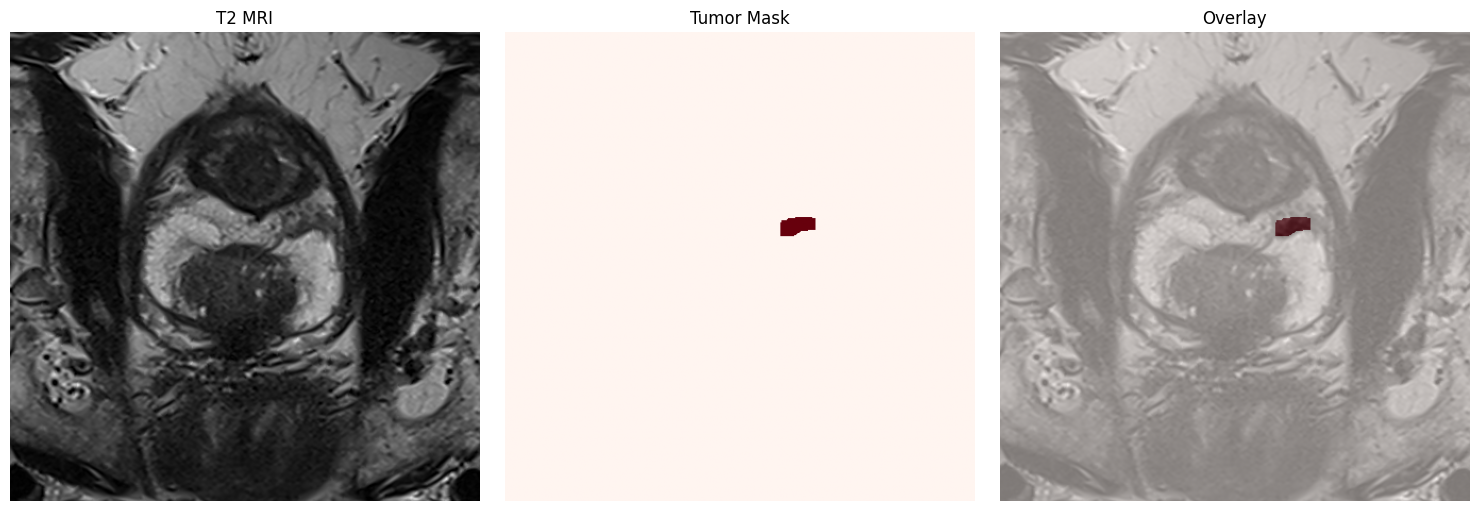


T2 Image Metadata:
Shape: (442, 442, 31)
Voxel sizes (mm): (0.271739, 0.271739, 2.999999)
Data type: float64

Tumor Mask Metadata:
Shape: (442, 442, 31)
Unique values: [0. 3.]
Voxel sizes: (0.271739, 0.271739, 2.999999)


In [5]:
# Path to your files
base_path = r"prostate158\train\060"
t2_path = f"{base_path}/t2.nii.gz"
tumor_mask_path = f"{base_path}/t2_tumor_reader1.nii.gz"

# Load the files
t2_img = nib.load(t2_path)
tumor_mask = nib.load(tumor_mask_path)

# Get the data arrays
t2_data = t2_img.get_fdata()
tumor_data = tumor_mask.get_fdata()

# Visualize middle slices
slice_idx = t2_data.shape[2] // 2

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# T2 image
axes[0].imshow(t2_data[:, :, slice_idx].T, cmap="gray", origin="lower")
axes[0].set_title("T2 MRI")
axes[0].axis("off")

# Tumor mask
axes[1].imshow(tumor_data[:, :, slice_idx].T, cmap="Reds", origin="lower")
axes[1].set_title("Tumor Mask")
axes[1].axis("off")

# Overlay
axes[2].imshow(t2_data[:, :, slice_idx].T, cmap="gray", origin="lower")
axes[2].imshow(tumor_data[:, :, slice_idx].T, cmap="Reds", alpha=0.5, origin="lower")
axes[2].set_title("Overlay")
axes[2].axis("off")

plt.tight_layout()
plt.show()

# Print metadata
print("\nT2 Image Metadata:")
print(f"Shape: {t2_data.shape}")
print(f"Voxel sizes (mm): {t2_img.header.get_zooms()}")
print(f"Data type: {t2_data.dtype}")

print("\nTumor Mask Metadata:")
print(f"Shape: {tumor_data.shape}")
print(
    f"Unique values: {np.unique(tumor_data)}"
)  # Should be 0 (background) and 1 (tumor)
print(f"Voxel sizes: {tumor_mask.header.get_zooms()}")

In [7]:
help(monai.networks.nets)

Help on package monai.networks.nets in monai.networks:

NAME
    monai.networks.nets

DESCRIPTION
    # Copyright (c) MONAI Consortium
    # Licensed under the Apache License, Version 2.0 (the "License");
    # you may not use this file except in compliance with the License.
    # You may obtain a copy of the License at
    #     http://www.apache.org/licenses/LICENSE-2.0
    # Unless required by applicable law or agreed to in writing, software
    # distributed under the License is distributed on an "AS IS" BASIS,
    # WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
    # See the License for the specific language governing permissions and
    # limitations under the License.

PACKAGE CONTENTS
    ahnet
    attentionunet
    autoencoder
    autoencoderkl
    basic_unet
    basic_unetplusplus
    cell_sam_wrapper
    classifier
    controlnet
    daf3d
    densenet
    diffusion_model_unet
    dints
    dynunet
    efficientnet
    flexible_unet
    fullyconnec

All parameters needed for training and evaluation are set in `anatomy.yaml` file.


In [5]:
# config = load_config("tumor.yaml")  # change to 'tumor.yaml' for tumor segmentation
# monai.utils.set_determinism(seed=config.seed)

In [6]:
from prostate158.utils import load_config
from prostate158.model import get_model
import torch  # Import torch to check for CUDA availability

# force‐reload the updated module
# setup_distributed(rank, world_size)
cfg = load_config("tumor.yaml")
monai.utils.set_determinism(seed=cfg.seed)
# Check if CUDA is available and set the device accordingly
if torch.cuda.is_available():
    cfg.device = "cuda"
else:
    cfg.device = "cpu"  # Fallback to CPU if no GPU is available

cfg.model.type = "rrunet3d"
# cfg.model.type = "unet"
model = get_model(cfg).to(cfg.device)  # Move the model to the selected device
print(model)

[get_model] model.type = 'rrunet3d'
RRUNet3D(
  (pool): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (unpool): Upsample(scale_factor=2.0, mode='nearest')
  (input_conv): Conv3d(3, 16, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
  (output_conv): Conv3d(16, 2, kernel_size=(1, 1, 1), stride=(1, 1, 1), bias=False)
  (output_activation): Softmax(dim=1)
  (encoders): ModuleList(
    (0): ResidualBlock(
      (CONV): ConvBlock(
        (ops): ModuleList(
          (0): Conv3d(16, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
          (1): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
      )
      (RCNN): Sequential(
        (0): RecurrentBlock(
          (conv): Sequential(
            (0): Conv3d(16, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
            (1): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_s

In [7]:
# Check GPU availability
gpu_count = torch.cuda.device_count()
print(f"Number of available GPUs: {gpu_count}")

# Print GPU info
for i in range(gpu_count):
    gpu_name = torch.cuda.get_device_name(i)
    gpu_memory = (
        torch.cuda.get_device_properties(i).total_memory / 1024**3
    )  # Convert to GB
    print(f"GPU {i}: {gpu_name} with {gpu_memory:.2f} GB memory")

# Determine if we should use distributed training
is_distributed = hasattr(cfg, "distributed") and cfg.distributed and gpu_count > 1

Number of available GPUs: 2
GPU 0: Quadro RTX 5000 with 16.00 GB memory
GPU 1: Quadro RTX 5000 with 16.00 GB memory


In [8]:
is_distributed

False

In [9]:
cfg.model

Munch({'type': 'rrunet3d', 'channels': [16, 32, 64, 128, 256, 512], 'strides': [2, 2, 2, 2, 2], 'act': 'PRELU', 'norm': 'BATCH', 'dropout': 0.15, 'num_res_units': 4, 'in_channels': 3, 'out_channels': 2, 'blocks_down': '1,2,2,1', 'blocks_up': '1,2,2', 'num_init_kernels': 16, 'recurrent': True, 'residual': True, 'attention': True, 'se': False})

In [10]:
cfg.device

'cuda'

In [7]:
# # Check if GPU is available
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# # 1. Move your model to the device first
# model = model.to(device)

# # 2. Then move your input tensor to the same device
# x = torch.randn(1, 3, 64, 128, 128).to(device)  # dummy 3D batch

# # Now this should work
# y = model(x)
# print(y.shape)

torch.Size([1, 2, 64, 128, 128])


---

**test**


In [ ]:
# # CELL 1: Imports and Setup
# import os
# import sys
# import torch
# import torch.distributed as dist
# import torch.multiprocessing as mp
# import logging
# import copy
# import monai
# from prostate158.utils import load_config
# from prostate158.train_anson import (
#     SegmentationTrainer,
#     setup_distributed,
#     cleanup_distributed,
# )
# from prostate158.report import ReportGenerator

# # CELL 2: Load Configuration
# # Load the tumor.yaml configuration
# config_path = "tumor.yaml"
# cfg = load_config(config_path)

# # CELL 3: Check GPU Availability
# # Check GPU availability
# gpu_count = torch.cuda.device_count()
# print(f"Number of available GPUs: {gpu_count}")

# # Print GPU info
# for i in range(gpu_count):
#     gpu_name = torch.cuda.get_device_name(i)
#     gpu_memory = (
#         torch.cuda.get_device_properties(i).total_memory / 1024**3
#     )  # Convert to GB
#     print(f"GPU {i}: {gpu_name} with {gpu_memory:.2f} GB memory")

# # CELL 4: Setup Directories
# # Make sure the output directories exist
# os.makedirs(cfg.out_dir, exist_ok=True)
# os.makedirs(cfg.model_dir, exist_ok=True)
# os.makedirs(cfg.log_dir, exist_ok=True)

# # Create log directories for each process
# for i in range(gpu_count):
#     os.makedirs(os.path.join(cfg.log_dir, f"rank_{i}"), exist_ok=True)


# # CELL 5: Define the Direct Subprocess Approach for Distributed Training
# def run_distributed_training(config_path):
#     """
#     A safer approach to run distributed training from Jupyter notebooks
#     Using subprocesses instead of PyTorch's multiprocessing
#     """
#     import subprocess
#     import sys
#     import os

#     # Get the number of available GPUs
#     gpu_count = torch.cuda.device_count()
#     if gpu_count <= 1:
#         print("Only one GPU is available. Distributed training requires multiple GPUs.")
#         return False

#     # Use minimal_train.py as the training script
#     # Make sure you've created this file (copy the content from minimal_train.py)
#     train_script = os.path.abspath("minimal_train.py")
#     if not os.path.exists(train_script):
#         print(f"Training script {train_script} not found. Please create it first.")
#         return False

#     # Get the Python executable
#     python_exe = sys.executable

#     # Launch a process for each GPU
#     processes = []
#     for rank in range(gpu_count):
#         # Set environment variables for distributed training
#         env = os.environ.copy()
#         env["CUDA_VISIBLE_DEVICES"] = str(rank)
#         env["MASTER_ADDR"] = "localhost"
#         env["MASTER_PORT"] = "12355"
#         env["WORLD_SIZE"] = str(gpu_count)
#         env["RANK"] = str(rank)

#         # Create log directory
#         log_dir = os.path.join(cfg.log_dir, f"rank_{rank}")
#         os.makedirs(log_dir, exist_ok=True)

#         # Command to run the training script with distributed settings
#         cmd = [
#             python_exe,
#             train_script,
#             "--config",
#             config_path,
#             "--distributed",
#             "True",
#             "--rank",
#             str(rank),
#             "--world_size",
#             str(gpu_count),
#         ]

#         print(f"Starting process for rank {rank} with command: {' '.join(cmd)}")

#         # Start the process
#         process = subprocess.Popen(
#             cmd,
#             env=env,
#             stdout=open(os.path.join(log_dir, "stdout.log"), "w"),
#             stderr=open(os.path.join(log_dir, "stderr.log"), "w"),
#         )
#         processes.append(process)

#     # Wait for all processes to complete
#     print("Waiting for all processes to complete...")
#     for process in processes:
#         process.wait()

#     # Check if any process failed
#     failed = False
#     for i, process in enumerate(processes):
#         if process.returncode != 0:
#             print(f"Process {i} failed with return code {process.returncode}")
#             stderr_file = os.path.join(cfg.log_dir, f"rank_{i}", "stderr.log")
#             if os.path.exists(stderr_file):
#                 with open(stderr_file, "r") as f:
#                     print(f"Error log from rank {i}:\n{f.read()}")
#             failed = True

#     if failed:
#         print("Distributed training failed. Check the logs for details.")
#         return False
#     else:
#         print("Distributed training completed successfully!")
#         return True


# # CELL 6: Run Training (Single or Distributed)
# # Determine if we should use distributed training
# is_distributed = hasattr(cfg, "distributed") and cfg.distributed and gpu_count > 1

# if not is_distributed or gpu_count <= 1:
#     # Single GPU training or distributed flag is off
#     if is_distributed and gpu_count <= 1:
#         print(
#             "Distributed training was enabled but only one GPU is available. Falling back to single GPU training."
#         )
#         cfg.distributed = False

#     print("Starting single GPU training")
#     trainer = SegmentationTrainer(
#         progress_bar=True,
#         early_stopping=True,
#         metrics=["MeanDice", "HausdorffDistance", "SurfaceDistance"],
#         save_latest_metrics=True,
#         config=cfg,
#     )

#     # Add learning rate scheduler
#     trainer.fit_one_cycle()

#     # Train the model
#     trainer.run()

#     # Evaluate the model
#     trainer.evaluate()

#     # Generate report
#     report_generator = ReportGenerator(cfg.run_id, cfg.out_dir, cfg.log_dir)
#     report_generator.generate_report()

#     print("Single GPU training completed!")
# else:
#     # Distributed multi-GPU training
#     print(f"Starting distributed training with {gpu_count} GPUs")

#     # Run distributed training using our safer subprocess approach
#     run_distributed_training(config_path)

#     print("Distributed training process completed!")

Number of available GPUs: 2
GPU 0: Quadro RTX 5000 with 16.00 GB memory
GPU 1: Quadro RTX 5000 with 16.00 GB memory
Starting distributed training with 2 GPUs
Starting process for rank 0 with command: c:\Users\arsonist\Documents\p158\p158-env\Scripts\python.exe c:\Users\arsonist\Documents\p158\minimal_train.py --config tumor.yaml --distributed True --rank 0 --world_size 2
Starting process for rank 1 with command: c:\Users\arsonist\Documents\p158\p158-env\Scripts\python.exe c:\Users\arsonist\Documents\p158\minimal_train.py --config tumor.yaml --distributed True --rank 1 --world_size 2
Waiting for all processes to complete...


In [18]:
# import torch
# import matplotlib.pyplot as plt
# from monai.transforms import (
#     LoadImaged,
#     EnsureChannelFirstd,
#     EnsureTyped,
#     Compose,
#     Orientationd,
#     Spacingd,
#     ScaleIntensityRanged,
# )
# from monai.inferers import sliding_window_inference
# from prostate158.utils import load_config
# from prostate158.model import get_model

# # 1) load config & model
# cfg = load_config("tumor.yaml")
# cfg.device = "cpu"
# model = get_model(cfg).to(cfg.device)
# model.eval()

# # 2) same pre_transforms as before
# pre_transforms = Compose(
#     [
#         LoadImaged(keys=cfg.data.image_cols),
#         EnsureChannelFirstd(keys=cfg.data.image_cols),
#         Orientationd(keys=cfg.data.image_cols, axcodes="RAS"),
#         Spacingd(
#             keys=cfg.data.image_cols,
#             pixdim=cfg.transforms.spacing,
#             mode=tuple("bilinear" for _ in cfg.data.image_cols),
#         ),
#         ScaleIntensityRanged(
#             keys=cfg.data.image_cols,
#             a_min=-200,
#             a_max=200,
#             b_min=0.0,
#             b_max=1.0,
#             clip=True,
#         ),
#         EnsureTyped(keys=cfg.data.image_cols),
#     ]
# )

# # 3) Point to each modality’s file for one patient
# #
# sample_files = {
#     "t2": f"prostate158/train/020/t2.nii.gz",
#     "adc": f"prostate158/train/020/adc.nii.gz",
#     "dwi": f"prostate158/train/020/dwi.nii.gz",
# }

# sample = pre_transforms(sample_files)

# # 4) cat into (1, C, D, H, W)
# img = torch.cat([sample[k] for k in cfg.data.image_cols], dim=0)
# img = img.unsqueeze(0).to(cfg.device)

# # 5) sliding-window inference over, say, 96³ patches
# with torch.no_grad():
#     logits = sliding_window_inference(
#         inputs=img,
#         roi_size=(96, 96, 96),
#         sw_batch_size=1,
#         predictor=model,
#         overlap=0.25,  # 25% overlap between windows
#     )  # → (1, out_ch, D, H, W)

# # 6) convert & plot as before
# probs = torch.softmax(logits, dim=1)[0].cpu().numpy()
# pred = probs.argmax(axis=0)
# mid = pred.shape[0] // 2
# t2w = sample[cfg.data.image_cols[0]].cpu().numpy()[0, mid]

# plt.figure(figsize=(6, 6))
# plt.imshow(t2w, cmap="gray")
# plt.contour(pred[mid], levels=[0.5], colors="r")
# plt.axis("off")
# plt.show()

---


In [11]:
# 4) Print memory before training
print_memory_stats("Before training")


[MEMORY] Before training ▶ System RAM: total 1099.1 GB, used 39.1 GB (3.6%)
[MEMORY] GPU status via nvidia-smi:
name, memory.total [MiB], memory.used [MiB]
Quadro RTX 5000, 16384 MiB, 142 MiB
Quadro RTX 5000, 16384 MiB, 1150 MiB



Create supervised trainer for segmentation task


In [12]:
trainer = SegmentationTrainer(
    progress_bar=True,
    early_stopping=True,
    metrics=["MeanDice", "HausdorffDistance", "SurfaceDistance"],
    save_latest_metrics=True,
    config=cfg,
)

[get_model] model.type = 'rrunet3d'


Adding a learning rate scheduler for one-cylce policy.


In [13]:
trainer.fit_one_cycle()

In [14]:
# 6) Print peak GPU memory after fit_one_cycle
if torch.cuda.is_available():
    peak = torch.cuda.max_memory_allocated() / (1024**3)
    print(f"[MEMORY] Peak GPU memory used during fit_one_cycle: {peak:.2f} GB")

[MEMORY] Peak GPU memory used during fit_one_cycle: 0.01 GB


In [15]:
import torch

print("CUDA available:", torch.cuda.is_available())
print("GPU name:", torch.cuda.get_device_name(0))

CUDA available: True
GPU name: Quadro RTX 5000


Let's train. This can take several hours.


In [11]:
# # Create a comprehensive fix for the KeyError
# import types


# def robust_meta_dict(self, batch):
#     """Extract metadata from any available source in the batch"""
#     # Check what keys are available in the first batch item
#     print(
#         "Available batch keys:",
#         list(batch[0].keys()) if batch and len(batch) > 0 else "Empty batch",
#     )

#     # Try different possible metadata sources
#     possible_keys = [
#         "image_meta_dict",
#         "label_meta_dict",
#     ]  # Standard MONAI keys after concatenation

#     # Also try keys based on original image columns
#     image_cols = self.config.data.image_cols
#     if isinstance(image_cols, (list, tuple)):
#         for col in image_cols:
#             possible_keys.append(f"{col}_meta_dict")
#     else:
#         possible_keys.append(f"{image_cols}_meta_dict")

#     # For each item in batch, find first available metadata or create default
#     result = []
#     for item in batch:
#         # Debug info
#         if len(result) == 0:  # Only print for first item to avoid flooding
#             print(f"Item keys: {list(item.keys())}")

#         # Find the first available metadata key
#         meta = None
#         for key in possible_keys:
#             if key in item:
#                 meta = item[key]
#                 if len(result) == 0:  # Only print for first item
#                     print(f"Found metadata in key: {key}")
#                 break

#         # If no metadata found, create minimal default
#         if meta is None:
#             print("No metadata found, creating default")
#             meta = {
#                 "filename_or_obj": "unknown",
#                 "spatial_shape": [96, 96, 96],
#                 "original_shape": [96, 96, 96],
#             }

#         result.append(meta)

#     return result


# # Create a function to inspect batch structure
# def inspect_batch(batch):
#     """Print the structure of a batch"""
#     print("\n--- BATCH INSPECTION ---")
#     print(f"Batch type: {type(batch)}")
#     print(f"Batch length: {len(batch) if hasattr(batch, '__len__') else 'N/A'}")

#     if hasattr(batch, "__getitem__") and len(batch) > 0:
#         item = batch[0]
#         print(f"First item type: {type(item)}")
#         if hasattr(item, "keys"):
#             print(f"First item keys: {list(item.keys())}")

#             # Check metadata keys specifically
#             meta_keys = [k for k in item.keys() if "meta" in k]
#             print(f"Metadata keys: {meta_keys}")

#             # Print first metadata structure if available
#             if meta_keys and meta_keys[0] in item:
#                 print(f"Structure of {meta_keys[0]}:")
#                 meta = item[meta_keys[0]]
#                 print(f"  Type: {type(meta)}")
#                 if hasattr(meta, "keys"):
#                     print(f"  Keys: {list(meta.keys())}")

#     print("--- END INSPECTION ---\n")
#     return batch


# # Add inspection to trainer
# import monai.engines

# # Save original _get_meta_dict
# original_get_meta_dict = SegmentationTrainer._get_meta_dict

# # Apply the robust metadata extractor
# trainer._get_meta_dict = types.MethodType(robust_meta_dict, trainer)

# # Add batch inspection to the first iteration
# original_process_function = trainer.evaluator._process_function


# def debug_process_function(engine, batch):
#     inspect_batch(batch)
#     return original_process_function(engine, batch)


# trainer.evaluator._process_function = debug_process_function

In [16]:
cfg.model.out_channels

2

In [17]:
trainer.run()

`torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
`torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.


2025-06-02 17:39:21,286 - INFO - Epoch: 1/100, Iter: 1/30 -- train_loss: 1.3149 


[1/30]   3%|3          [00:00<?]

2025-06-02 17:39:27,522 - INFO - Epoch: 1/100, Iter: 2/30 -- train_loss: 1.3394 
2025-06-02 17:39:28,030 - INFO - Epoch: 1/100, Iter: 3/30 -- train_loss: 1.3078 
2025-06-02 17:39:34,747 - INFO - Epoch: 1/100, Iter: 4/30 -- train_loss: 1.3282 
2025-06-02 17:39:35,207 - INFO - Epoch: 1/100, Iter: 5/30 -- train_loss: 1.3407 
2025-06-02 17:39:35,675 - INFO - Epoch: 1/100, Iter: 6/30 -- train_loss: 1.3001 
2025-06-02 17:39:40,768 - INFO - Epoch: 1/100, Iter: 7/30 -- train_loss: 1.3115 
2025-06-02 17:39:41,285 - INFO - Epoch: 1/100, Iter: 8/30 -- train_loss: 1.3322 
2025-06-02 17:39:41,767 - INFO - Epoch: 1/100, Iter: 9/30 -- train_loss: 1.3347 
2025-06-02 17:39:42,249 - INFO - Epoch: 1/100, Iter: 10/30 -- train_loss: 1.3367 
2025-06-02 17:39:42,723 - INFO - Epoch: 1/100, Iter: 11/30 -- train_loss: 1.3159 
2025-06-02 17:39:43,213 - INFO - Epoch: 1/100, Iter: 12/30 -- train_loss: 1.3295 
2025-06-02 17:39:43,688 - INFO - Epoch: 1/100, Iter: 13/30 -- train_loss: 1.3272 
2025-06-02 17:39:52,234 

`torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.


[1/20]   5%|5          [00:00<?]

the ground truth of class 0 is all 0, this may result in nan/inf distance.
Mean of empty slice


2025-06-02 17:47:10,061 - INFO - Epoch: 2/100, Iter: 1/30 -- train_loss: 1.3112 


[1/30]   3%|3          [00:00<?]

2025-06-02 17:47:10,522 - INFO - Epoch: 2/100, Iter: 2/30 -- train_loss: 1.3105 
2025-06-02 17:47:10,980 - INFO - Epoch: 2/100, Iter: 3/30 -- train_loss: 1.3050 
2025-06-02 17:47:11,426 - INFO - Epoch: 2/100, Iter: 4/30 -- train_loss: 1.3082 
2025-06-02 17:47:11,894 - INFO - Epoch: 2/100, Iter: 5/30 -- train_loss: 1.3125 
2025-06-02 17:47:12,349 - INFO - Epoch: 2/100, Iter: 6/30 -- train_loss: 1.3125 
2025-06-02 17:47:12,838 - INFO - Epoch: 2/100, Iter: 7/30 -- train_loss: 1.2934 
2025-06-02 17:47:13,314 - INFO - Epoch: 2/100, Iter: 8/30 -- train_loss: 1.3102 
2025-06-02 17:47:17,014 - INFO - Epoch: 2/100, Iter: 9/30 -- train_loss: 1.3001 
2025-06-02 17:47:17,877 - INFO - Epoch: 2/100, Iter: 10/30 -- train_loss: 1.3080 
2025-06-02 17:47:18,363 - INFO - Epoch: 2/100, Iter: 11/30 -- train_loss: 1.2931 
2025-06-02 17:47:18,876 - INFO - Epoch: 2/100, Iter: 12/30 -- train_loss: 1.2802 
2025-06-02 17:47:19,353 - INFO - Epoch: 2/100, Iter: 13/30 -- train_loss: 1.2687 
2025-06-02 17:47:19,842 

[1/20]   5%|5          [00:00<?]

2025-06-02 17:54:35,721 - INFO - Epoch: 3/100, Iter: 1/30 -- train_loss: 1.2977 


[1/30]   3%|3          [00:00<?]

2025-06-02 17:54:37,282 - INFO - Epoch: 3/100, Iter: 2/30 -- train_loss: 1.2901 
2025-06-02 17:54:51,753 - INFO - Epoch: 3/100, Iter: 3/30 -- train_loss: 1.2770 
2025-06-02 17:54:52,208 - INFO - Epoch: 3/100, Iter: 4/30 -- train_loss: 1.2858 
2025-06-02 17:54:52,697 - INFO - Epoch: 3/100, Iter: 5/30 -- train_loss: 1.2939 
2025-06-02 17:54:53,151 - INFO - Epoch: 3/100, Iter: 6/30 -- train_loss: 1.2894 
2025-06-02 17:54:53,614 - INFO - Epoch: 3/100, Iter: 7/30 -- train_loss: 1.2828 
2025-06-02 17:54:54,089 - INFO - Epoch: 3/100, Iter: 8/30 -- train_loss: 1.2853 
2025-06-02 17:54:54,580 - INFO - Epoch: 3/100, Iter: 9/30 -- train_loss: 1.2642 
2025-06-02 17:55:06,193 - INFO - Epoch: 3/100, Iter: 10/30 -- train_loss: 1.2557 
2025-06-02 17:55:06,663 - INFO - Epoch: 3/100, Iter: 11/30 -- train_loss: 1.2756 
2025-06-02 17:55:07,132 - INFO - Epoch: 3/100, Iter: 12/30 -- train_loss: 1.2825 
2025-06-02 17:55:07,589 - INFO - Epoch: 3/100, Iter: 13/30 -- train_loss: 1.2737 
2025-06-02 17:55:08,078 

[1/20]   5%|5          [00:00<?]

2025-06-02 18:01:58,906 - INFO - Epoch: 4/100, Iter: 1/30 -- train_loss: 1.2641 


[1/30]   3%|3          [00:00<?]

2025-06-02 18:01:59,425 - INFO - Epoch: 4/100, Iter: 2/30 -- train_loss: 1.2684 
2025-06-02 18:02:15,948 - INFO - Epoch: 4/100, Iter: 3/30 -- train_loss: 1.2739 
2025-06-02 18:02:16,402 - INFO - Epoch: 4/100, Iter: 4/30 -- train_loss: 1.2450 
2025-06-02 18:02:16,884 - INFO - Epoch: 4/100, Iter: 5/30 -- train_loss: 1.2324 
2025-06-02 18:02:17,346 - INFO - Epoch: 4/100, Iter: 6/30 -- train_loss: 1.2385 
2025-06-02 18:02:17,824 - INFO - Epoch: 4/100, Iter: 7/30 -- train_loss: 1.2634 
2025-06-02 18:02:18,282 - INFO - Epoch: 4/100, Iter: 8/30 -- train_loss: 1.2689 
2025-06-02 18:02:18,750 - INFO - Epoch: 4/100, Iter: 9/30 -- train_loss: 1.2614 
2025-06-02 18:02:19,659 - INFO - Epoch: 4/100, Iter: 10/30 -- train_loss: 1.2380 
2025-06-02 18:02:20,142 - INFO - Epoch: 4/100, Iter: 11/30 -- train_loss: 1.2701 
2025-06-02 18:02:20,612 - INFO - Epoch: 4/100, Iter: 12/30 -- train_loss: 1.2474 
2025-06-02 18:02:21,086 - INFO - Epoch: 4/100, Iter: 13/30 -- train_loss: 1.2489 
2025-06-02 18:02:21,577 

[1/20]   5%|5          [00:00<?]

2025-06-02 18:09:02,208 - INFO - Epoch: 5/100, Iter: 1/30 -- train_loss: 1.2543 


[1/30]   3%|3          [00:00<?]

2025-06-02 18:09:15,644 - INFO - Epoch: 5/100, Iter: 2/30 -- train_loss: 1.2366 
2025-06-02 18:09:16,164 - INFO - Epoch: 5/100, Iter: 3/30 -- train_loss: 1.2413 
2025-06-02 18:09:16,644 - INFO - Epoch: 5/100, Iter: 4/30 -- train_loss: 1.2505 
2025-06-02 18:09:17,125 - INFO - Epoch: 5/100, Iter: 5/30 -- train_loss: 1.2512 
2025-06-02 18:09:17,629 - INFO - Epoch: 5/100, Iter: 6/30 -- train_loss: 1.2362 
2025-06-02 18:09:18,105 - INFO - Epoch: 5/100, Iter: 7/30 -- train_loss: 1.2436 
2025-06-02 18:09:18,599 - INFO - Epoch: 5/100, Iter: 8/30 -- train_loss: 1.2411 
2025-06-02 18:09:19,092 - INFO - Epoch: 5/100, Iter: 9/30 -- train_loss: 1.2467 
2025-06-02 18:09:19,604 - INFO - Epoch: 5/100, Iter: 10/30 -- train_loss: 1.2307 
2025-06-02 18:09:20,086 - INFO - Epoch: 5/100, Iter: 11/30 -- train_loss: 1.2466 
2025-06-02 18:09:20,567 - INFO - Epoch: 5/100, Iter: 12/30 -- train_loss: 1.2341 
2025-06-02 18:09:21,028 - INFO - Epoch: 5/100, Iter: 13/30 -- train_loss: 1.2425 
2025-06-02 18:09:21,513 

[1/20]   5%|5          [00:00<?]

2025-06-02 18:15:47,838 - INFO - Epoch: 6/100, Iter: 1/30 -- train_loss: 1.1991 


[1/30]   3%|3          [00:00<?]

2025-06-02 18:15:56,055 - INFO - Epoch: 6/100, Iter: 2/30 -- train_loss: 1.2297 
2025-06-02 18:15:56,552 - INFO - Epoch: 6/100, Iter: 3/30 -- train_loss: 1.2359 
2025-06-02 18:15:57,021 - INFO - Epoch: 6/100, Iter: 4/30 -- train_loss: 1.2319 
2025-06-02 18:15:57,489 - INFO - Epoch: 6/100, Iter: 5/30 -- train_loss: 1.2229 
2025-06-02 18:15:57,959 - INFO - Epoch: 6/100, Iter: 6/30 -- train_loss: 1.2300 
2025-06-02 18:15:58,437 - INFO - Epoch: 6/100, Iter: 7/30 -- train_loss: 1.2282 
2025-06-02 18:15:58,925 - INFO - Epoch: 6/100, Iter: 8/30 -- train_loss: 1.2102 
2025-06-02 18:15:59,387 - INFO - Epoch: 6/100, Iter: 9/30 -- train_loss: 1.2310 
2025-06-02 18:15:59,850 - INFO - Epoch: 6/100, Iter: 10/30 -- train_loss: 1.2193 
2025-06-02 18:16:00,318 - INFO - Epoch: 6/100, Iter: 11/30 -- train_loss: 1.2193 
2025-06-02 18:16:00,794 - INFO - Epoch: 6/100, Iter: 12/30 -- train_loss: 1.2245 
2025-06-02 18:16:01,268 - INFO - Epoch: 6/100, Iter: 13/30 -- train_loss: 1.2223 
2025-06-02 18:16:01,747 

[1/20]   5%|5          [00:00<?]

2025-06-02 18:22:42,900 - INFO - Epoch: 7/100, Iter: 1/30 -- train_loss: 1.2189 


[1/30]   3%|3          [00:00<?]

2025-06-02 18:22:43,376 - INFO - Epoch: 7/100, Iter: 2/30 -- train_loss: 1.2054 
2025-06-02 18:22:43,864 - INFO - Epoch: 7/100, Iter: 3/30 -- train_loss: 1.1988 
2025-06-02 18:22:53,938 - INFO - Epoch: 7/100, Iter: 4/30 -- train_loss: 1.2179 
2025-06-02 18:22:54,398 - INFO - Epoch: 7/100, Iter: 5/30 -- train_loss: 1.2154 
2025-06-02 18:22:54,852 - INFO - Epoch: 7/100, Iter: 6/30 -- train_loss: 1.1952 
2025-06-02 18:22:55,304 - INFO - Epoch: 7/100, Iter: 7/30 -- train_loss: 1.2150 
2025-06-02 18:22:55,774 - INFO - Epoch: 7/100, Iter: 8/30 -- train_loss: 1.2143 
2025-06-02 18:22:56,235 - INFO - Epoch: 7/100, Iter: 9/30 -- train_loss: 1.2088 
2025-06-02 18:22:56,693 - INFO - Epoch: 7/100, Iter: 10/30 -- train_loss: 1.2129 
2025-06-02 18:22:57,147 - INFO - Epoch: 7/100, Iter: 11/30 -- train_loss: 1.2085 
2025-06-02 18:22:57,721 - INFO - Epoch: 7/100, Iter: 12/30 -- train_loss: 1.2110 
2025-06-02 18:22:58,190 - INFO - Epoch: 7/100, Iter: 13/30 -- train_loss: 1.2164 
2025-06-02 18:22:58,669 

[1/20]   5%|5          [00:00<?]

the prediction of class 0 is all 0, this may result in nan/inf distance.


2025-06-02 18:29:39,365 - INFO - Epoch: 8/100, Iter: 1/30 -- train_loss: 1.2056 


[1/30]   3%|3          [00:00<?]

2025-06-02 18:29:39,870 - INFO - Epoch: 8/100, Iter: 2/30 -- train_loss: 1.1996 
2025-06-02 18:29:40,360 - INFO - Epoch: 8/100, Iter: 3/30 -- train_loss: 1.1937 
2025-06-02 18:29:40,842 - INFO - Epoch: 8/100, Iter: 4/30 -- train_loss: 1.2066 
2025-06-02 18:29:42,437 - INFO - Epoch: 8/100, Iter: 5/30 -- train_loss: 1.1943 
2025-06-02 18:29:42,923 - INFO - Epoch: 8/100, Iter: 6/30 -- train_loss: 1.2077 
2025-06-02 18:29:43,404 - INFO - Epoch: 8/100, Iter: 7/30 -- train_loss: 1.1952 
2025-06-02 18:29:43,880 - INFO - Epoch: 8/100, Iter: 8/30 -- train_loss: 1.2067 
2025-06-02 18:29:44,353 - INFO - Epoch: 8/100, Iter: 9/30 -- train_loss: 1.2073 
2025-06-02 18:29:44,819 - INFO - Epoch: 8/100, Iter: 10/30 -- train_loss: 1.1832 
2025-06-02 18:29:45,294 - INFO - Epoch: 8/100, Iter: 11/30 -- train_loss: 1.1992 
2025-06-02 18:29:45,765 - INFO - Epoch: 8/100, Iter: 12/30 -- train_loss: 1.1971 
2025-06-02 18:29:46,241 - INFO - Epoch: 8/100, Iter: 13/30 -- train_loss: 1.2053 
2025-06-02 18:29:46,698 

[1/20]   5%|5          [00:00<?]

2025-06-02 18:36:04,962 - INFO - Epoch: 9/100, Iter: 1/30 -- train_loss: 1.1999 


[1/30]   3%|3          [00:00<?]

2025-06-02 18:36:18,387 - INFO - Epoch: 9/100, Iter: 2/30 -- train_loss: 1.1966 
2025-06-02 18:36:18,884 - INFO - Epoch: 9/100, Iter: 3/30 -- train_loss: 1.1976 
2025-06-02 18:36:19,382 - INFO - Epoch: 9/100, Iter: 4/30 -- train_loss: 1.1904 
2025-06-02 18:36:26,650 - INFO - Epoch: 9/100, Iter: 5/30 -- train_loss: 1.1886 
2025-06-02 18:36:27,125 - INFO - Epoch: 9/100, Iter: 6/30 -- train_loss: 1.1975 
2025-06-02 18:36:27,615 - INFO - Epoch: 9/100, Iter: 7/30 -- train_loss: 1.1966 
2025-06-02 18:36:28,119 - INFO - Epoch: 9/100, Iter: 8/30 -- train_loss: 1.1982 
2025-06-02 18:36:28,623 - INFO - Epoch: 9/100, Iter: 9/30 -- train_loss: 1.1899 
2025-06-02 18:36:29,112 - INFO - Epoch: 9/100, Iter: 10/30 -- train_loss: 1.1853 
2025-06-02 18:36:29,597 - INFO - Epoch: 9/100, Iter: 11/30 -- train_loss: 1.1957 
2025-06-02 18:36:30,072 - INFO - Epoch: 9/100, Iter: 12/30 -- train_loss: 1.1836 
2025-06-02 18:36:30,545 - INFO - Epoch: 9/100, Iter: 13/30 -- train_loss: 1.1349 
2025-06-02 18:36:31,060 

[1/20]   5%|5          [00:00<?]

2025-06-02 18:42:52,645 - INFO - Epoch: 10/100, Iter: 1/30 -- train_loss: 1.1935 


[1/30]   3%|3          [00:00<?]

2025-06-02 18:42:54,941 - INFO - Epoch: 10/100, Iter: 2/30 -- train_loss: 1.1839 
2025-06-02 18:43:11,299 - INFO - Epoch: 10/100, Iter: 3/30 -- train_loss: 1.1944 
2025-06-02 18:43:11,766 - INFO - Epoch: 10/100, Iter: 4/30 -- train_loss: 1.1897 
2025-06-02 18:43:12,236 - INFO - Epoch: 10/100, Iter: 5/30 -- train_loss: 1.1934 
2025-06-02 18:43:12,693 - INFO - Epoch: 10/100, Iter: 6/30 -- train_loss: 1.1841 
2025-06-02 18:43:13,153 - INFO - Epoch: 10/100, Iter: 7/30 -- train_loss: 1.1935 
2025-06-02 18:43:13,604 - INFO - Epoch: 10/100, Iter: 8/30 -- train_loss: 1.1710 
2025-06-02 18:43:14,062 - INFO - Epoch: 10/100, Iter: 9/30 -- train_loss: 1.1728 
2025-06-02 18:43:14,516 - INFO - Epoch: 10/100, Iter: 10/30 -- train_loss: 1.1867 
2025-06-02 18:43:14,975 - INFO - Epoch: 10/100, Iter: 11/30 -- train_loss: 1.1878 
2025-06-02 18:43:15,434 - INFO - Epoch: 10/100, Iter: 12/30 -- train_loss: 1.1866 
2025-06-02 18:43:15,878 - INFO - Epoch: 10/100, Iter: 13/30 -- train_loss: 1.1921 
2025-06-02 1

[1/20]   5%|5          [00:00<?]

2025-06-02 18:49:43,896 - INFO - Epoch: 11/100, Iter: 1/30 -- train_loss: 1.1866 


[1/30]   3%|3          [00:00<?]

2025-06-02 18:49:44,382 - INFO - Epoch: 11/100, Iter: 2/30 -- train_loss: 1.1652 
2025-06-02 18:49:44,837 - INFO - Epoch: 11/100, Iter: 3/30 -- train_loss: 1.1887 
2025-06-02 18:49:45,473 - INFO - Epoch: 11/100, Iter: 4/30 -- train_loss: 1.1692 
2025-06-02 18:49:45,949 - INFO - Epoch: 11/100, Iter: 5/30 -- train_loss: 1.1873 
2025-06-02 18:49:46,420 - INFO - Epoch: 11/100, Iter: 6/30 -- train_loss: 1.1515 
2025-06-02 18:49:46,878 - INFO - Epoch: 11/100, Iter: 7/30 -- train_loss: 1.1860 
2025-06-02 18:49:47,333 - INFO - Epoch: 11/100, Iter: 8/30 -- train_loss: 1.1776 
2025-06-02 18:49:47,806 - INFO - Epoch: 11/100, Iter: 9/30 -- train_loss: 1.1718 
2025-06-02 18:49:48,283 - INFO - Epoch: 11/100, Iter: 10/30 -- train_loss: 1.1857 
2025-06-02 18:49:53,895 - INFO - Epoch: 11/100, Iter: 11/30 -- train_loss: 1.1842 
2025-06-02 18:49:54,363 - INFO - Epoch: 11/100, Iter: 12/30 -- train_loss: 1.1862 
2025-06-02 18:49:54,850 - INFO - Epoch: 11/100, Iter: 13/30 -- train_loss: 1.1653 
2025-06-02 1

[1/20]   5%|5          [00:00<?]

2025-06-02 18:56:38,183 - INFO - Epoch: 12/100, Iter: 1/30 -- train_loss: 1.1872 


[1/30]   3%|3          [00:00<?]

2025-06-02 18:56:38,671 - INFO - Epoch: 12/100, Iter: 2/30 -- train_loss: 1.1795 
2025-06-02 18:56:39,140 - INFO - Epoch: 12/100, Iter: 3/30 -- train_loss: 1.1868 
2025-06-02 18:56:39,610 - INFO - Epoch: 12/100, Iter: 4/30 -- train_loss: 1.1857 
2025-06-02 18:56:40,092 - INFO - Epoch: 12/100, Iter: 5/30 -- train_loss: 1.1811 
2025-06-02 18:56:40,575 - INFO - Epoch: 12/100, Iter: 6/30 -- train_loss: 1.1688 
2025-06-02 18:56:41,065 - INFO - Epoch: 12/100, Iter: 7/30 -- train_loss: 1.1785 
2025-06-02 18:56:41,528 - INFO - Epoch: 12/100, Iter: 8/30 -- train_loss: 1.1562 
2025-06-02 18:56:41,995 - INFO - Epoch: 12/100, Iter: 9/30 -- train_loss: 1.1743 
2025-06-02 18:56:42,472 - INFO - Epoch: 12/100, Iter: 10/30 -- train_loss: 1.1760 
2025-06-02 18:56:42,961 - INFO - Epoch: 12/100, Iter: 11/30 -- train_loss: 1.1861 
2025-06-02 18:56:43,413 - INFO - Epoch: 12/100, Iter: 12/30 -- train_loss: 1.1796 
2025-06-02 18:56:43,880 - INFO - Epoch: 12/100, Iter: 13/30 -- train_loss: 1.1812 
2025-06-02 1

[1/20]   5%|5          [00:00<?]

2025-06-02 19:03:20,422 - INFO - Epoch: 13/100, Iter: 1/30 -- train_loss: 1.1845 


[1/30]   3%|3          [00:00<?]

2025-06-02 19:03:20,929 - INFO - Epoch: 13/100, Iter: 2/30 -- train_loss: 1.1830 
2025-06-02 19:03:21,417 - INFO - Epoch: 13/100, Iter: 3/30 -- train_loss: 1.1781 
2025-06-02 19:03:22,863 - INFO - Epoch: 13/100, Iter: 4/30 -- train_loss: 1.1537 
2025-06-02 19:03:23,359 - INFO - Epoch: 13/100, Iter: 5/30 -- train_loss: 1.1795 
2025-06-02 19:03:23,837 - INFO - Epoch: 13/100, Iter: 6/30 -- train_loss: 1.1620 
2025-06-02 19:03:24,333 - INFO - Epoch: 13/100, Iter: 7/30 -- train_loss: 1.1750 
2025-06-02 19:03:24,815 - INFO - Epoch: 13/100, Iter: 8/30 -- train_loss: 1.1796 
2025-06-02 19:03:25,289 - INFO - Epoch: 13/100, Iter: 9/30 -- train_loss: 1.1809 
2025-06-02 19:03:25,770 - INFO - Epoch: 13/100, Iter: 10/30 -- train_loss: 1.1834 
2025-06-02 19:03:26,239 - INFO - Epoch: 13/100, Iter: 11/30 -- train_loss: 1.1847 
2025-06-02 19:03:26,702 - INFO - Epoch: 13/100, Iter: 12/30 -- train_loss: 1.1805 
2025-06-02 19:03:27,209 - INFO - Epoch: 13/100, Iter: 13/30 -- train_loss: 1.1771 
2025-06-02 1

[1/20]   5%|5          [00:00<?]

2025-06-02 19:09:53,233 - INFO - Epoch: 14/100, Iter: 1/30 -- train_loss: 1.1797 


[1/30]   3%|3          [00:00<?]

2025-06-02 19:09:53,758 - INFO - Epoch: 14/100, Iter: 2/30 -- train_loss: 1.1802 
2025-06-02 19:10:00,044 - INFO - Epoch: 14/100, Iter: 3/30 -- train_loss: 1.1814 
2025-06-02 19:10:02,924 - INFO - Epoch: 14/100, Iter: 4/30 -- train_loss: 1.1781 
2025-06-02 19:10:03,414 - INFO - Epoch: 14/100, Iter: 5/30 -- train_loss: 1.1668 
2025-06-02 19:10:03,911 - INFO - Epoch: 14/100, Iter: 6/30 -- train_loss: 1.1710 
2025-06-02 19:10:04,408 - INFO - Epoch: 14/100, Iter: 7/30 -- train_loss: 1.1799 
2025-06-02 19:10:04,915 - INFO - Epoch: 14/100, Iter: 8/30 -- train_loss: 1.1780 
2025-06-02 19:10:05,392 - INFO - Epoch: 14/100, Iter: 9/30 -- train_loss: 1.1698 
2025-06-02 19:10:05,877 - INFO - Epoch: 14/100, Iter: 10/30 -- train_loss: 1.1786 
2025-06-02 19:10:06,359 - INFO - Epoch: 14/100, Iter: 11/30 -- train_loss: 1.1784 
2025-06-02 19:10:07,301 - INFO - Epoch: 14/100, Iter: 12/30 -- train_loss: 1.1716 
2025-06-02 19:10:07,805 - INFO - Epoch: 14/100, Iter: 13/30 -- train_loss: 1.1823 
2025-06-02 1

[1/20]   5%|5          [00:00<?]

2025-06-02 19:16:40,088 - INFO - Epoch: 15/100, Iter: 1/30 -- train_loss: 1.1794 


[1/30]   3%|3          [00:00<?]

2025-06-02 19:16:40,601 - INFO - Epoch: 15/100, Iter: 2/30 -- train_loss: 1.1646 
2025-06-02 19:16:41,080 - INFO - Epoch: 15/100, Iter: 3/30 -- train_loss: 1.1814 
2025-06-02 19:16:41,572 - INFO - Epoch: 15/100, Iter: 4/30 -- train_loss: 1.1470 
2025-06-02 19:16:42,044 - INFO - Epoch: 15/100, Iter: 5/30 -- train_loss: 1.1812 
2025-06-02 19:16:52,113 - INFO - Epoch: 15/100, Iter: 6/30 -- train_loss: 1.1759 
2025-06-02 19:16:52,570 - INFO - Epoch: 15/100, Iter: 7/30 -- train_loss: 1.1763 
2025-06-02 19:16:57,129 - INFO - Epoch: 15/100, Iter: 8/30 -- train_loss: 1.1806 
2025-06-02 19:16:57,585 - INFO - Epoch: 15/100, Iter: 9/30 -- train_loss: 1.1805 
2025-06-02 19:16:58,069 - INFO - Epoch: 15/100, Iter: 10/30 -- train_loss: 1.1730 
2025-06-02 19:16:58,524 - INFO - Epoch: 15/100, Iter: 11/30 -- train_loss: 1.1806 
2025-06-02 19:16:58,994 - INFO - Epoch: 15/100, Iter: 12/30 -- train_loss: 1.1779 
2025-06-02 19:16:59,471 - INFO - Epoch: 15/100, Iter: 13/30 -- train_loss: 1.1774 
2025-06-02 1

[1/20]   5%|5          [00:00<?]

2025-06-02 19:23:37,369 - INFO - Epoch: 16/100, Iter: 1/30 -- train_loss: 1.1748 


[1/30]   3%|3          [00:00<?]

2025-06-02 19:23:37,845 - INFO - Epoch: 16/100, Iter: 2/30 -- train_loss: 1.1673 
2025-06-02 19:23:38,300 - INFO - Epoch: 16/100, Iter: 3/30 -- train_loss: 1.1741 
2025-06-02 19:23:38,761 - INFO - Epoch: 16/100, Iter: 4/30 -- train_loss: 1.1710 
2025-06-02 19:23:39,221 - INFO - Epoch: 16/100, Iter: 5/30 -- train_loss: 1.1808 
2025-06-02 19:23:39,676 - INFO - Epoch: 16/100, Iter: 6/30 -- train_loss: 1.1775 
2025-06-02 19:23:40,126 - INFO - Epoch: 16/100, Iter: 7/30 -- train_loss: 1.1757 
2025-06-02 19:23:42,413 - INFO - Epoch: 16/100, Iter: 8/30 -- train_loss: 1.1511 
2025-06-02 19:23:42,880 - INFO - Epoch: 16/100, Iter: 9/30 -- train_loss: 1.1797 
2025-06-02 19:23:43,351 - INFO - Epoch: 16/100, Iter: 10/30 -- train_loss: 1.1696 
2025-06-02 19:23:43,839 - INFO - Epoch: 16/100, Iter: 11/30 -- train_loss: 1.1797 
2025-06-02 19:23:44,295 - INFO - Epoch: 16/100, Iter: 12/30 -- train_loss: 1.1691 
2025-06-02 19:23:44,760 - INFO - Epoch: 16/100, Iter: 13/30 -- train_loss: 1.1802 
2025-06-02 1

[1/20]   5%|5          [00:00<?]

2025-06-02 19:30:01,799 - INFO - Epoch: 17/100, Iter: 1/30 -- train_loss: 1.1693 


[1/30]   3%|3          [00:00<?]

2025-06-02 19:30:02,329 - INFO - Epoch: 17/100, Iter: 2/30 -- train_loss: 1.1566 
2025-06-02 19:30:15,216 - INFO - Epoch: 17/100, Iter: 3/30 -- train_loss: 1.1723 
2025-06-02 19:30:15,708 - INFO - Epoch: 17/100, Iter: 4/30 -- train_loss: 1.1778 
2025-06-02 19:30:16,184 - INFO - Epoch: 17/100, Iter: 5/30 -- train_loss: 1.1773 
2025-06-02 19:30:16,673 - INFO - Epoch: 17/100, Iter: 6/30 -- train_loss: 1.1781 
2025-06-02 19:30:21,415 - INFO - Epoch: 17/100, Iter: 7/30 -- train_loss: 1.1185 
2025-06-02 19:30:21,894 - INFO - Epoch: 17/100, Iter: 8/30 -- train_loss: 1.1789 
2025-06-02 19:30:22,351 - INFO - Epoch: 17/100, Iter: 9/30 -- train_loss: 1.1787 
2025-06-02 19:30:22,829 - INFO - Epoch: 17/100, Iter: 10/30 -- train_loss: 1.1780 
2025-06-02 19:30:26,981 - INFO - Epoch: 17/100, Iter: 11/30 -- train_loss: 1.1775 
2025-06-02 19:30:27,447 - INFO - Epoch: 17/100, Iter: 12/30 -- train_loss: 1.1710 
2025-06-02 19:30:27,917 - INFO - Epoch: 17/100, Iter: 13/30 -- train_loss: 1.1657 
2025-06-02 1

[1/20]   5%|5          [00:00<?]

2025-06-02 19:36:46,270 - INFO - Epoch: 18/100, Iter: 1/30 -- train_loss: 1.1789 


[1/30]   3%|3          [00:00<?]

2025-06-02 19:37:05,923 - INFO - Epoch: 18/100, Iter: 2/30 -- train_loss: 1.1620 
2025-06-02 19:37:06,399 - INFO - Epoch: 18/100, Iter: 3/30 -- train_loss: 1.1791 
2025-06-02 19:37:06,903 - INFO - Epoch: 18/100, Iter: 4/30 -- train_loss: 1.1684 
2025-06-02 19:37:07,417 - INFO - Epoch: 18/100, Iter: 5/30 -- train_loss: 1.1780 
2025-06-02 19:37:35,421 - INFO - Epoch: 18/100, Iter: 6/30 -- train_loss: 1.1796 
2025-06-02 19:37:35,952 - INFO - Epoch: 18/100, Iter: 7/30 -- train_loss: 1.1627 
2025-06-02 19:37:36,449 - INFO - Epoch: 18/100, Iter: 8/30 -- train_loss: 1.1681 
2025-06-02 19:37:36,960 - INFO - Epoch: 18/100, Iter: 9/30 -- train_loss: 1.1753 
2025-06-02 19:37:37,448 - INFO - Epoch: 18/100, Iter: 10/30 -- train_loss: 1.1727 
2025-06-02 19:37:37,946 - INFO - Epoch: 18/100, Iter: 11/30 -- train_loss: 1.1726 
2025-06-02 19:37:38,454 - INFO - Epoch: 18/100, Iter: 12/30 -- train_loss: 1.1764 
2025-06-02 19:37:38,949 - INFO - Epoch: 18/100, Iter: 13/30 -- train_loss: 1.1625 
2025-06-02 1

[1/20]   5%|5          [00:00<?]

2025-06-02 19:43:59,817 - INFO - Epoch: 19/100, Iter: 1/30 -- train_loss: 1.1555 


[1/30]   3%|3          [00:00<?]

2025-06-02 19:44:05,050 - INFO - Epoch: 19/100, Iter: 2/30 -- train_loss: 1.1726 
2025-06-02 19:44:05,565 - INFO - Epoch: 19/100, Iter: 3/30 -- train_loss: 1.1742 
2025-06-02 19:44:06,068 - INFO - Epoch: 19/100, Iter: 4/30 -- train_loss: 1.1742 
2025-06-02 19:44:12,666 - INFO - Epoch: 19/100, Iter: 5/30 -- train_loss: 1.1750 
2025-06-02 19:44:13,155 - INFO - Epoch: 19/100, Iter: 6/30 -- train_loss: 1.1462 
2025-06-02 19:44:13,637 - INFO - Epoch: 19/100, Iter: 7/30 -- train_loss: 1.1769 
2025-06-02 19:44:14,133 - INFO - Epoch: 19/100, Iter: 8/30 -- train_loss: 1.1764 
2025-06-02 19:44:14,633 - INFO - Epoch: 19/100, Iter: 9/30 -- train_loss: 1.1761 
2025-06-02 19:44:15,117 - INFO - Epoch: 19/100, Iter: 10/30 -- train_loss: 1.1767 
2025-06-02 19:44:15,589 - INFO - Epoch: 19/100, Iter: 11/30 -- train_loss: 1.1662 
2025-06-02 19:44:16,086 - INFO - Epoch: 19/100, Iter: 12/30 -- train_loss: 1.1768 
2025-06-02 19:44:16,591 - INFO - Epoch: 19/100, Iter: 13/30 -- train_loss: 1.1712 
2025-06-02 1

[1/20]   5%|5          [00:00<?]

2025-06-02 19:51:12,542 - INFO - Epoch: 20/100, Iter: 1/30 -- train_loss: 1.1670 


[1/30]   3%|3          [00:00<?]

2025-06-02 19:51:13,032 - INFO - Epoch: 20/100, Iter: 2/30 -- train_loss: 1.1745 
2025-06-02 19:51:13,504 - INFO - Epoch: 20/100, Iter: 3/30 -- train_loss: 1.1781 
2025-06-02 19:51:13,975 - INFO - Epoch: 20/100, Iter: 4/30 -- train_loss: 1.1774 
2025-06-02 19:51:14,443 - INFO - Epoch: 20/100, Iter: 5/30 -- train_loss: 1.1730 
2025-06-02 19:51:14,888 - INFO - Epoch: 20/100, Iter: 6/30 -- train_loss: 1.1762 
2025-06-02 19:51:15,381 - INFO - Epoch: 20/100, Iter: 7/30 -- train_loss: 1.1714 
2025-06-02 19:51:20,759 - INFO - Epoch: 20/100, Iter: 8/30 -- train_loss: 1.1757 
2025-06-02 19:51:21,221 - INFO - Epoch: 20/100, Iter: 9/30 -- train_loss: 1.1575 
2025-06-02 19:51:21,682 - INFO - Epoch: 20/100, Iter: 10/30 -- train_loss: 1.1567 
2025-06-02 19:51:22,144 - INFO - Epoch: 20/100, Iter: 11/30 -- train_loss: 1.1723 
2025-06-02 19:51:22,610 - INFO - Epoch: 20/100, Iter: 12/30 -- train_loss: 1.1762 
2025-06-02 19:51:23,061 - INFO - Epoch: 20/100, Iter: 13/30 -- train_loss: 1.1675 
2025-06-02 1

[1/20]   5%|5          [00:00<?]

2025-06-02 19:57:50,747 - INFO - Epoch: 21/100, Iter: 1/30 -- train_loss: 1.1741 


[1/30]   3%|3          [00:00<?]

2025-06-02 19:57:51,227 - INFO - Epoch: 21/100, Iter: 2/30 -- train_loss: 1.1735 
2025-06-02 19:57:51,684 - INFO - Epoch: 21/100, Iter: 3/30 -- train_loss: 1.1703 
2025-06-02 19:57:52,150 - INFO - Epoch: 21/100, Iter: 4/30 -- train_loss: 1.1695 
2025-06-02 19:57:52,618 - INFO - Epoch: 21/100, Iter: 5/30 -- train_loss: 1.1650 
2025-06-02 19:57:53,096 - INFO - Epoch: 21/100, Iter: 6/30 -- train_loss: 1.1582 
2025-06-02 19:57:53,555 - INFO - Epoch: 21/100, Iter: 7/30 -- train_loss: 1.1738 
2025-06-02 19:57:54,005 - INFO - Epoch: 21/100, Iter: 8/30 -- train_loss: 1.1632 
2025-06-02 19:57:54,940 - INFO - Epoch: 21/100, Iter: 9/30 -- train_loss: 1.1691 
2025-06-02 19:57:55,394 - INFO - Epoch: 21/100, Iter: 10/30 -- train_loss: 1.1735 
2025-06-02 19:57:55,863 - INFO - Epoch: 21/100, Iter: 11/30 -- train_loss: 1.1642 
2025-06-02 19:57:56,324 - INFO - Epoch: 21/100, Iter: 12/30 -- train_loss: 1.1771 
2025-06-02 19:58:08,624 - INFO - Epoch: 21/100, Iter: 13/30 -- train_loss: 1.1768 
2025-06-02 1

[1/20]   5%|5          [00:00<?]

2025-06-02 20:04:25,987 - INFO - Epoch: 22/100, Iter: 1/30 -- train_loss: 1.1603 


[1/30]   3%|3          [00:00<?]

2025-06-02 20:04:26,510 - INFO - Epoch: 22/100, Iter: 2/30 -- train_loss: 1.1737 
2025-06-02 20:04:34,627 - INFO - Epoch: 22/100, Iter: 3/30 -- train_loss: 1.1762 
2025-06-02 20:04:35,096 - INFO - Epoch: 22/100, Iter: 4/30 -- train_loss: 1.1533 
2025-06-02 20:04:35,598 - INFO - Epoch: 22/100, Iter: 5/30 -- train_loss: 1.1722 
2025-06-02 20:04:36,071 - INFO - Epoch: 22/100, Iter: 6/30 -- train_loss: 1.1725 
2025-06-02 20:04:36,587 - INFO - Epoch: 22/100, Iter: 7/30 -- train_loss: 1.1600 
2025-06-02 20:04:37,069 - INFO - Epoch: 22/100, Iter: 8/30 -- train_loss: 1.1733 
2025-06-02 20:04:37,554 - INFO - Epoch: 22/100, Iter: 9/30 -- train_loss: 1.1627 
2025-06-02 20:04:38,032 - INFO - Epoch: 22/100, Iter: 10/30 -- train_loss: 1.1740 
2025-06-02 20:04:38,511 - INFO - Epoch: 22/100, Iter: 11/30 -- train_loss: 1.1634 
2025-06-02 20:04:39,001 - INFO - Epoch: 22/100, Iter: 12/30 -- train_loss: 1.1727 
2025-06-02 20:04:45,235 - INFO - Epoch: 22/100, Iter: 13/30 -- train_loss: 1.1676 
2025-06-02 2

[1/20]   5%|5          [00:00<?]

2025-06-02 20:11:23,702 - INFO - Epoch: 23/100, Iter: 1/30 -- train_loss: 1.1770 


[1/30]   3%|3          [00:00<?]

2025-06-02 20:11:24,218 - INFO - Epoch: 23/100, Iter: 2/30 -- train_loss: 1.1422 
2025-06-02 20:11:24,743 - INFO - Epoch: 23/100, Iter: 3/30 -- train_loss: 1.1739 
2025-06-02 20:11:25,251 - INFO - Epoch: 23/100, Iter: 4/30 -- train_loss: 1.1571 
2025-06-02 20:11:25,739 - INFO - Epoch: 23/100, Iter: 5/30 -- train_loss: 1.1722 
2025-06-02 20:11:26,222 - INFO - Epoch: 23/100, Iter: 6/30 -- train_loss: 1.1707 
2025-06-02 20:11:26,693 - INFO - Epoch: 23/100, Iter: 7/30 -- train_loss: 1.1732 
2025-06-02 20:11:27,165 - INFO - Epoch: 23/100, Iter: 8/30 -- train_loss: 1.1735 
2025-06-02 20:11:36,159 - INFO - Epoch: 23/100, Iter: 9/30 -- train_loss: 1.1730 
2025-06-02 20:11:36,651 - INFO - Epoch: 23/100, Iter: 10/30 -- train_loss: 1.1732 
2025-06-02 20:11:37,144 - INFO - Epoch: 23/100, Iter: 11/30 -- train_loss: 1.1722 
2025-06-02 20:11:37,624 - INFO - Epoch: 23/100, Iter: 12/30 -- train_loss: 1.1648 
2025-06-02 20:11:38,104 - INFO - Epoch: 23/100, Iter: 13/30 -- train_loss: 1.1744 
2025-06-02 2

[1/20]   5%|5          [00:00<?]

2025-06-02 20:18:02,716 - INFO - Epoch: 24/100, Iter: 1/30 -- train_loss: 1.1750 


[1/30]   3%|3          [00:00<?]

2025-06-02 20:18:08,168 - INFO - Epoch: 24/100, Iter: 2/30 -- train_loss: 1.1690 
2025-06-02 20:18:08,641 - INFO - Epoch: 24/100, Iter: 3/30 -- train_loss: 1.1660 
2025-06-02 20:18:09,107 - INFO - Epoch: 24/100, Iter: 4/30 -- train_loss: 1.1738 
2025-06-02 20:18:09,566 - INFO - Epoch: 24/100, Iter: 5/30 -- train_loss: 1.1693 
2025-06-02 20:18:10,039 - INFO - Epoch: 24/100, Iter: 6/30 -- train_loss: 1.1641 
2025-06-02 20:18:10,513 - INFO - Epoch: 24/100, Iter: 7/30 -- train_loss: 1.1723 
2025-06-02 20:18:10,996 - INFO - Epoch: 24/100, Iter: 8/30 -- train_loss: 1.1704 
2025-06-02 20:18:11,504 - INFO - Epoch: 24/100, Iter: 9/30 -- train_loss: 1.1753 
2025-06-02 20:18:11,972 - INFO - Epoch: 24/100, Iter: 10/30 -- train_loss: 1.1610 
2025-06-02 20:18:20,672 - INFO - Epoch: 24/100, Iter: 11/30 -- train_loss: 1.1761 
2025-06-02 20:18:21,139 - INFO - Epoch: 24/100, Iter: 12/30 -- train_loss: 1.1606 
2025-06-02 20:18:21,615 - INFO - Epoch: 24/100, Iter: 13/30 -- train_loss: 1.1732 
2025-06-02 2

[1/20]   5%|5          [00:00<?]

2025-06-02 20:24:35,955 - INFO - Epoch: 25/100, Iter: 1/30 -- train_loss: 1.1646 


[1/30]   3%|3          [00:00<?]

2025-06-02 20:24:54,422 - INFO - Epoch: 25/100, Iter: 2/30 -- train_loss: 1.1731 
2025-06-02 20:24:54,900 - INFO - Epoch: 25/100, Iter: 3/30 -- train_loss: 1.1666 
2025-06-02 20:24:55,368 - INFO - Epoch: 25/100, Iter: 4/30 -- train_loss: 1.1667 
2025-06-02 20:24:55,852 - INFO - Epoch: 25/100, Iter: 5/30 -- train_loss: 1.1718 
2025-06-02 20:24:56,333 - INFO - Epoch: 25/100, Iter: 6/30 -- train_loss: 1.1678 
2025-06-02 20:24:56,811 - INFO - Epoch: 25/100, Iter: 7/30 -- train_loss: 1.1678 
2025-06-02 20:24:57,284 - INFO - Epoch: 25/100, Iter: 8/30 -- train_loss: 1.1766 
2025-06-02 20:24:57,775 - INFO - Epoch: 25/100, Iter: 9/30 -- train_loss: 1.1711 
2025-06-02 20:24:58,273 - INFO - Epoch: 25/100, Iter: 10/30 -- train_loss: 1.1760 
2025-06-02 20:24:58,772 - INFO - Epoch: 25/100, Iter: 11/30 -- train_loss: 1.1760 
2025-06-02 20:24:59,272 - INFO - Epoch: 25/100, Iter: 12/30 -- train_loss: 1.1738 
2025-06-02 20:24:59,748 - INFO - Epoch: 25/100, Iter: 13/30 -- train_loss: 1.1744 
2025-06-02 2

[1/20]   5%|5          [00:00<?]

2025-06-02 20:31:24,027 - INFO - Epoch: 26/100, Iter: 1/30 -- train_loss: 1.1721 


[1/30]   3%|3          [00:00<?]

2025-06-02 20:31:35,040 - INFO - Epoch: 26/100, Iter: 2/30 -- train_loss: 1.1763 
2025-06-02 20:31:35,507 - INFO - Epoch: 26/100, Iter: 3/30 -- train_loss: 1.1724 
2025-06-02 20:31:51,501 - INFO - Epoch: 26/100, Iter: 4/30 -- train_loss: 1.1592 
2025-06-02 20:31:51,980 - INFO - Epoch: 26/100, Iter: 5/30 -- train_loss: 1.1755 
2025-06-02 20:31:52,469 - INFO - Epoch: 26/100, Iter: 6/30 -- train_loss: 1.1745 
2025-06-02 20:31:52,939 - INFO - Epoch: 26/100, Iter: 7/30 -- train_loss: 1.1491 
2025-06-02 20:31:53,397 - INFO - Epoch: 26/100, Iter: 8/30 -- train_loss: 1.1541 
2025-06-02 20:31:53,865 - INFO - Epoch: 26/100, Iter: 9/30 -- train_loss: 1.1390 
2025-06-02 20:31:54,322 - INFO - Epoch: 26/100, Iter: 10/30 -- train_loss: 1.1761 
2025-06-02 20:31:54,790 - INFO - Epoch: 26/100, Iter: 11/30 -- train_loss: 1.1628 
2025-06-02 20:31:55,248 - INFO - Epoch: 26/100, Iter: 12/30 -- train_loss: 1.1757 
2025-06-02 20:31:55,717 - INFO - Epoch: 26/100, Iter: 13/30 -- train_loss: 1.1720 
2025-06-02 2

[1/20]   5%|5          [00:00<?]

2025-06-02 20:38:15,920 - INFO - Epoch: 27/100, Iter: 1/30 -- train_loss: 1.1751 


[1/30]   3%|3          [00:00<?]

2025-06-02 20:38:22,553 - INFO - Epoch: 27/100, Iter: 2/30 -- train_loss: 1.1703 
2025-06-02 20:38:24,841 - INFO - Epoch: 27/100, Iter: 3/30 -- train_loss: 1.1551 
2025-06-02 20:38:25,308 - INFO - Epoch: 27/100, Iter: 4/30 -- train_loss: 1.1761 
2025-06-02 20:38:25,781 - INFO - Epoch: 27/100, Iter: 5/30 -- train_loss: 1.1552 
2025-06-02 20:38:26,255 - INFO - Epoch: 27/100, Iter: 6/30 -- train_loss: 1.1721 
2025-06-02 20:38:32,566 - INFO - Epoch: 27/100, Iter: 7/30 -- train_loss: 1.1728 
2025-06-02 20:38:33,031 - INFO - Epoch: 27/100, Iter: 8/30 -- train_loss: 1.1757 
2025-06-02 20:38:33,527 - INFO - Epoch: 27/100, Iter: 9/30 -- train_loss: 1.1733 
2025-06-02 20:38:34,007 - INFO - Epoch: 27/100, Iter: 10/30 -- train_loss: 1.1728 
2025-06-02 20:38:46,013 - INFO - Epoch: 27/100, Iter: 11/30 -- train_loss: 1.1662 
2025-06-02 20:38:46,501 - INFO - Epoch: 27/100, Iter: 12/30 -- train_loss: 1.1743 
2025-06-02 20:38:46,968 - INFO - Epoch: 27/100, Iter: 13/30 -- train_loss: 1.1708 
2025-06-02 2

[1/20]   5%|5          [00:00<?]

2025-06-02 20:44:38,352 - INFO - Epoch: 28/100, Iter: 1/30 -- train_loss: 1.1482 


[1/30]   3%|3          [00:00<?]

2025-06-02 20:44:38,853 - INFO - Epoch: 28/100, Iter: 2/30 -- train_loss: 1.1583 
2025-06-02 20:44:54,224 - INFO - Epoch: 28/100, Iter: 3/30 -- train_loss: 1.1325 
2025-06-02 20:44:54,722 - INFO - Epoch: 28/100, Iter: 4/30 -- train_loss: 1.1695 
2025-06-02 20:45:07,267 - INFO - Epoch: 28/100, Iter: 5/30 -- train_loss: 1.1761 
2025-06-02 20:45:07,749 - INFO - Epoch: 28/100, Iter: 6/30 -- train_loss: 1.1682 
2025-06-02 20:45:08,223 - INFO - Epoch: 28/100, Iter: 7/30 -- train_loss: 1.1451 
2025-06-02 20:45:08,680 - INFO - Epoch: 28/100, Iter: 8/30 -- train_loss: 1.1709 
2025-06-02 20:45:09,144 - INFO - Epoch: 28/100, Iter: 9/30 -- train_loss: 1.1760 
2025-06-02 20:45:09,625 - INFO - Epoch: 28/100, Iter: 10/30 -- train_loss: 1.1725 
2025-06-02 20:45:10,095 - INFO - Epoch: 28/100, Iter: 11/30 -- train_loss: 1.1700 
2025-06-02 20:45:10,551 - INFO - Epoch: 28/100, Iter: 12/30 -- train_loss: 1.1724 
2025-06-02 20:45:11,015 - INFO - Epoch: 28/100, Iter: 13/30 -- train_loss: 1.1712 
2025-06-02 2

[1/20]   5%|5          [00:00<?]

2025-06-02 20:51:43,685 - INFO - Epoch: 29/100, Iter: 1/30 -- train_loss: 1.1655 


[1/30]   3%|3          [00:00<?]

2025-06-02 20:51:44,168 - INFO - Epoch: 29/100, Iter: 2/30 -- train_loss: 1.1733 
2025-06-02 20:51:51,706 - INFO - Epoch: 29/100, Iter: 3/30 -- train_loss: 1.1727 
2025-06-02 20:51:52,186 - INFO - Epoch: 29/100, Iter: 4/30 -- train_loss: 1.1726 
2025-06-02 20:51:52,657 - INFO - Epoch: 29/100, Iter: 5/30 -- train_loss: 1.1739 
2025-06-02 20:51:53,139 - INFO - Epoch: 29/100, Iter: 6/30 -- train_loss: 1.1685 
2025-06-02 20:51:53,606 - INFO - Epoch: 29/100, Iter: 7/30 -- train_loss: 1.1646 
2025-06-02 20:51:54,077 - INFO - Epoch: 29/100, Iter: 8/30 -- train_loss: 1.1632 
2025-06-02 20:51:54,557 - INFO - Epoch: 29/100, Iter: 9/30 -- train_loss: 1.1586 
2025-06-02 20:51:55,040 - INFO - Epoch: 29/100, Iter: 10/30 -- train_loss: 1.1559 
2025-06-02 20:51:55,516 - INFO - Epoch: 29/100, Iter: 11/30 -- train_loss: 1.1750 
2025-06-02 20:51:55,993 - INFO - Epoch: 29/100, Iter: 12/30 -- train_loss: 1.1716 
2025-06-02 20:51:56,498 - INFO - Epoch: 29/100, Iter: 13/30 -- train_loss: 1.1750 
2025-06-02 2

[1/20]   5%|5          [00:00<?]

2025-06-02 20:58:26,727 - INFO - Epoch: 30/100, Iter: 1/30 -- train_loss: 1.1692 


[1/30]   3%|3          [00:00<?]

2025-06-02 20:58:27,239 - INFO - Epoch: 30/100, Iter: 2/30 -- train_loss: 1.1705 
2025-06-02 20:58:34,755 - INFO - Epoch: 30/100, Iter: 3/30 -- train_loss: 1.1702 
2025-06-02 20:58:35,232 - INFO - Epoch: 30/100, Iter: 4/30 -- train_loss: 1.1700 
2025-06-02 20:58:35,721 - INFO - Epoch: 30/100, Iter: 5/30 -- train_loss: 1.1620 
2025-06-02 20:58:36,281 - INFO - Epoch: 30/100, Iter: 6/30 -- train_loss: 1.1746 
2025-06-02 20:58:36,762 - INFO - Epoch: 30/100, Iter: 7/30 -- train_loss: 1.1628 
2025-06-02 20:58:37,241 - INFO - Epoch: 30/100, Iter: 8/30 -- train_loss: 1.1737 
2025-06-02 20:58:37,744 - INFO - Epoch: 30/100, Iter: 9/30 -- train_loss: 1.1600 
2025-06-02 20:58:38,226 - INFO - Epoch: 30/100, Iter: 10/30 -- train_loss: 1.1745 
2025-06-02 20:58:38,727 - INFO - Epoch: 30/100, Iter: 11/30 -- train_loss: 1.1243 
2025-06-02 20:58:39,211 - INFO - Epoch: 30/100, Iter: 12/30 -- train_loss: 1.1627 
2025-06-02 20:58:39,704 - INFO - Epoch: 30/100, Iter: 13/30 -- train_loss: 1.1648 
2025-06-02 2

[1/20]   5%|5          [00:00<?]

2025-06-02 21:04:49,699 - INFO - Epoch: 31/100, Iter: 1/30 -- train_loss: 1.1631 


[1/30]   3%|3          [00:00<?]

2025-06-02 21:05:07,563 - INFO - Epoch: 31/100, Iter: 2/30 -- train_loss: 1.1516 
2025-06-02 21:05:08,046 - INFO - Epoch: 31/100, Iter: 3/30 -- train_loss: 1.1685 
2025-06-02 21:05:08,542 - INFO - Epoch: 31/100, Iter: 4/30 -- train_loss: 1.1568 
2025-06-02 21:05:09,003 - INFO - Epoch: 31/100, Iter: 5/30 -- train_loss: 1.1743 
2025-06-02 21:05:09,469 - INFO - Epoch: 31/100, Iter: 6/30 -- train_loss: 1.1752 
2025-06-02 21:05:09,939 - INFO - Epoch: 31/100, Iter: 7/30 -- train_loss: 1.1706 
2025-06-02 21:05:10,409 - INFO - Epoch: 31/100, Iter: 8/30 -- train_loss: 1.1714 
2025-06-02 21:05:10,869 - INFO - Epoch: 31/100, Iter: 9/30 -- train_loss: 1.1732 
2025-06-02 21:05:11,349 - INFO - Epoch: 31/100, Iter: 10/30 -- train_loss: 1.1637 
2025-06-02 21:05:20,189 - INFO - Epoch: 31/100, Iter: 11/30 -- train_loss: 1.1747 
2025-06-02 21:05:20,666 - INFO - Epoch: 31/100, Iter: 12/30 -- train_loss: 1.1756 
2025-06-02 21:05:21,160 - INFO - Epoch: 31/100, Iter: 13/30 -- train_loss: 1.1529 
2025-06-02 2

[1/20]   5%|5          [00:00<?]

2025-06-02 21:11:39,821 - INFO - Epoch: 32/100, Iter: 1/30 -- train_loss: 1.1745 


[1/30]   3%|3          [00:00<?]

2025-06-02 21:11:48,637 - INFO - Epoch: 32/100, Iter: 2/30 -- train_loss: 1.1645 
2025-06-02 21:11:49,171 - INFO - Epoch: 32/100, Iter: 3/30 -- train_loss: 1.1674 
2025-06-02 21:11:58,486 - INFO - Epoch: 32/100, Iter: 4/30 -- train_loss: 1.1747 
2025-06-02 21:11:58,965 - INFO - Epoch: 32/100, Iter: 5/30 -- train_loss: 1.1383 
2025-06-02 21:11:59,447 - INFO - Epoch: 32/100, Iter: 6/30 -- train_loss: 1.1296 
2025-06-02 21:11:59,915 - INFO - Epoch: 32/100, Iter: 7/30 -- train_loss: 1.1710 
2025-06-02 21:12:00,402 - INFO - Epoch: 32/100, Iter: 8/30 -- train_loss: 1.1672 
2025-06-02 21:12:00,875 - INFO - Epoch: 32/100, Iter: 9/30 -- train_loss: 1.1731 
2025-06-02 21:12:01,342 - INFO - Epoch: 32/100, Iter: 10/30 -- train_loss: 1.1757 
2025-06-02 21:12:01,808 - INFO - Epoch: 32/100, Iter: 11/30 -- train_loss: 1.1609 
2025-06-02 21:12:02,293 - INFO - Epoch: 32/100, Iter: 12/30 -- train_loss: 1.1757 
2025-06-02 21:12:02,778 - INFO - Epoch: 32/100, Iter: 13/30 -- train_loss: 1.1725 
2025-06-02 2

[1/20]   5%|5          [00:00<?]

2025-06-02 21:18:36,107 - INFO - Epoch: 33/100, Iter: 1/30 -- train_loss: 1.1641 


[1/30]   3%|3          [00:00<?]

2025-06-02 21:18:39,646 - INFO - Epoch: 33/100, Iter: 2/30 -- train_loss: 1.1692 
2025-06-02 21:18:40,236 - INFO - Epoch: 33/100, Iter: 3/30 -- train_loss: 1.1724 
2025-06-02 21:18:40,744 - INFO - Epoch: 33/100, Iter: 4/30 -- train_loss: 1.1757 
2025-06-02 21:18:41,230 - INFO - Epoch: 33/100, Iter: 5/30 -- train_loss: 1.1700 
2025-06-02 21:18:41,711 - INFO - Epoch: 33/100, Iter: 6/30 -- train_loss: 1.1528 
2025-06-02 21:18:42,182 - INFO - Epoch: 33/100, Iter: 7/30 -- train_loss: 1.1663 
2025-06-02 21:18:47,529 - INFO - Epoch: 33/100, Iter: 8/30 -- train_loss: 1.1697 
2025-06-02 21:18:47,994 - INFO - Epoch: 33/100, Iter: 9/30 -- train_loss: 1.1695 
2025-06-02 21:18:48,453 - INFO - Epoch: 33/100, Iter: 10/30 -- train_loss: 1.1692 
2025-06-02 21:18:48,910 - INFO - Epoch: 33/100, Iter: 11/30 -- train_loss: 1.1754 
2025-06-02 21:18:49,391 - INFO - Epoch: 33/100, Iter: 12/30 -- train_loss: 1.1748 
2025-06-02 21:18:49,879 - INFO - Epoch: 33/100, Iter: 13/30 -- train_loss: 1.1719 
2025-06-02 2

[1/20]   5%|5          [00:00<?]

2025-06-02 21:25:13,719 - INFO - Epoch: 34/100, Iter: 1/30 -- train_loss: 1.1757 


[1/30]   3%|3          [00:00<?]

2025-06-02 21:25:14,235 - INFO - Epoch: 34/100, Iter: 2/30 -- train_loss: 1.1215 
2025-06-02 21:25:17,454 - INFO - Epoch: 34/100, Iter: 3/30 -- train_loss: 1.1720 
2025-06-02 21:25:17,922 - INFO - Epoch: 34/100, Iter: 4/30 -- train_loss: 1.1699 
2025-06-02 21:25:18,386 - INFO - Epoch: 34/100, Iter: 5/30 -- train_loss: 1.1647 
2025-06-02 21:25:18,844 - INFO - Epoch: 34/100, Iter: 6/30 -- train_loss: 1.1697 
2025-06-02 21:25:19,301 - INFO - Epoch: 34/100, Iter: 7/30 -- train_loss: 1.1753 
2025-06-02 21:25:19,794 - INFO - Epoch: 34/100, Iter: 8/30 -- train_loss: 1.1728 
2025-06-02 21:25:20,248 - INFO - Epoch: 34/100, Iter: 9/30 -- train_loss: 1.1712 
2025-06-02 21:25:20,705 - INFO - Epoch: 34/100, Iter: 10/30 -- train_loss: 1.1740 
2025-06-02 21:25:21,169 - INFO - Epoch: 34/100, Iter: 11/30 -- train_loss: 1.1692 
2025-06-02 21:25:21,634 - INFO - Epoch: 34/100, Iter: 12/30 -- train_loss: 1.1754 
2025-06-02 21:25:22,120 - INFO - Epoch: 34/100, Iter: 13/30 -- train_loss: 1.1719 
2025-06-02 2

[1/20]   5%|5          [00:00<?]

2025-06-02 21:32:08,178 - INFO - Epoch: 35/100, Iter: 1/30 -- train_loss: 1.1706 


[1/30]   3%|3          [00:00<?]

2025-06-02 21:32:08,663 - INFO - Epoch: 35/100, Iter: 2/30 -- train_loss: 1.1578 
2025-06-02 21:32:09,130 - INFO - Epoch: 35/100, Iter: 3/30 -- train_loss: 1.1732 
2025-06-02 21:32:09,581 - INFO - Epoch: 35/100, Iter: 4/30 -- train_loss: 1.1656 
2025-06-02 21:32:10,032 - INFO - Epoch: 35/100, Iter: 5/30 -- train_loss: 1.1700 
2025-06-02 21:32:10,485 - INFO - Epoch: 35/100, Iter: 6/30 -- train_loss: 1.1709 
2025-06-02 21:32:10,952 - INFO - Epoch: 35/100, Iter: 7/30 -- train_loss: 1.1636 
2025-06-02 21:32:11,400 - INFO - Epoch: 35/100, Iter: 8/30 -- train_loss: 1.1702 
2025-06-02 21:32:11,875 - INFO - Epoch: 35/100, Iter: 9/30 -- train_loss: 1.1409 
2025-06-02 21:32:12,328 - INFO - Epoch: 35/100, Iter: 10/30 -- train_loss: 1.1642 
2025-06-02 21:32:12,788 - INFO - Epoch: 35/100, Iter: 11/30 -- train_loss: 1.1755 
2025-06-02 21:32:13,253 - INFO - Epoch: 35/100, Iter: 12/30 -- train_loss: 1.1729 
2025-06-02 21:32:13,709 - INFO - Epoch: 35/100, Iter: 13/30 -- train_loss: 1.1541 
2025-06-02 2

[1/20]   5%|5          [00:00<?]

2025-06-02 21:38:34,153 - INFO - Epoch: 36/100, Iter: 1/30 -- train_loss: 1.1589 


[1/30]   3%|3          [00:00<?]

2025-06-02 21:38:43,804 - INFO - Epoch: 36/100, Iter: 2/30 -- train_loss: 1.1714 
2025-06-02 21:38:49,406 - INFO - Epoch: 36/100, Iter: 3/30 -- train_loss: 1.1694 
2025-06-02 21:38:49,916 - INFO - Epoch: 36/100, Iter: 4/30 -- train_loss: 1.1654 
2025-06-02 21:38:57,051 - INFO - Epoch: 36/100, Iter: 5/30 -- train_loss: 1.1751 
2025-06-02 21:38:57,530 - INFO - Epoch: 36/100, Iter: 6/30 -- train_loss: 1.1714 
2025-06-02 21:38:58,028 - INFO - Epoch: 36/100, Iter: 7/30 -- train_loss: 1.1691 
2025-06-02 21:38:58,531 - INFO - Epoch: 36/100, Iter: 8/30 -- train_loss: 1.1668 
2025-06-02 21:38:59,051 - INFO - Epoch: 36/100, Iter: 9/30 -- train_loss: 1.1755 
2025-06-02 21:38:59,550 - INFO - Epoch: 36/100, Iter: 10/30 -- train_loss: 1.1467 
2025-06-02 21:39:00,021 - INFO - Epoch: 36/100, Iter: 11/30 -- train_loss: 1.1616 
2025-06-02 21:39:00,485 - INFO - Epoch: 36/100, Iter: 12/30 -- train_loss: 1.1702 
2025-06-02 21:39:00,970 - INFO - Epoch: 36/100, Iter: 13/30 -- train_loss: 1.1755 
2025-06-02 2

[1/20]   5%|5          [00:00<?]

2025-06-02 21:45:28,874 - INFO - Epoch: 37/100, Iter: 1/30 -- train_loss: 1.1757 


[1/30]   3%|3          [00:00<?]

2025-06-02 21:45:29,396 - INFO - Epoch: 37/100, Iter: 2/30 -- train_loss: 1.1605 
2025-06-02 21:45:34,266 - INFO - Epoch: 37/100, Iter: 3/30 -- train_loss: 1.1610 
2025-06-02 21:45:34,742 - INFO - Epoch: 37/100, Iter: 4/30 -- train_loss: 1.1737 
2025-06-02 21:45:35,194 - INFO - Epoch: 37/100, Iter: 5/30 -- train_loss: 1.1533 
2025-06-02 21:45:35,669 - INFO - Epoch: 37/100, Iter: 6/30 -- train_loss: 1.1755 
2025-06-02 21:45:36,120 - INFO - Epoch: 37/100, Iter: 7/30 -- train_loss: 1.1686 
2025-06-02 21:45:36,663 - INFO - Epoch: 37/100, Iter: 8/30 -- train_loss: 1.1724 
2025-06-02 21:45:37,123 - INFO - Epoch: 37/100, Iter: 9/30 -- train_loss: 1.1585 
2025-06-02 21:45:37,590 - INFO - Epoch: 37/100, Iter: 10/30 -- train_loss: 1.1755 
2025-06-02 21:45:49,168 - INFO - Epoch: 37/100, Iter: 11/30 -- train_loss: 1.1754 
2025-06-02 21:45:49,644 - INFO - Epoch: 37/100, Iter: 12/30 -- train_loss: 1.1709 
2025-06-02 21:45:50,157 - INFO - Epoch: 37/100, Iter: 13/30 -- train_loss: 1.1693 
2025-06-02 2

[1/20]   5%|5          [00:00<?]

2025-06-02 21:52:20,551 - INFO - Epoch: 38/100, Iter: 1/30 -- train_loss: 1.1580 


[1/30]   3%|3          [00:00<?]

2025-06-02 21:52:21,054 - INFO - Epoch: 38/100, Iter: 2/30 -- train_loss: 1.1680 
2025-06-02 21:52:21,532 - INFO - Epoch: 38/100, Iter: 3/30 -- train_loss: 1.1716 
2025-06-02 21:52:23,910 - INFO - Epoch: 38/100, Iter: 4/30 -- train_loss: 1.1694 
2025-06-02 21:52:32,816 - INFO - Epoch: 38/100, Iter: 5/30 -- train_loss: 1.1673 
2025-06-02 21:52:33,266 - INFO - Epoch: 38/100, Iter: 6/30 -- train_loss: 1.1655 
2025-06-02 21:52:33,715 - INFO - Epoch: 38/100, Iter: 7/30 -- train_loss: 1.1702 
2025-06-02 21:52:34,204 - INFO - Epoch: 38/100, Iter: 8/30 -- train_loss: 1.1728 
2025-06-02 21:52:34,650 - INFO - Epoch: 38/100, Iter: 9/30 -- train_loss: 1.1754 
2025-06-02 21:52:35,105 - INFO - Epoch: 38/100, Iter: 10/30 -- train_loss: 1.1650 
2025-06-02 21:52:35,566 - INFO - Epoch: 38/100, Iter: 11/30 -- train_loss: 1.1701 
2025-06-02 21:52:36,048 - INFO - Epoch: 38/100, Iter: 12/30 -- train_loss: 1.1756 
2025-06-02 21:52:36,506 - INFO - Epoch: 38/100, Iter: 13/30 -- train_loss: 1.1716 
2025-06-02 2

[1/20]   5%|5          [00:00<?]

2025-06-02 21:58:57,185 - INFO - Epoch: 39/100, Iter: 1/30 -- train_loss: 1.1768 


[1/30]   3%|3          [00:00<?]

2025-06-02 21:59:01,390 - INFO - Epoch: 39/100, Iter: 2/30 -- train_loss: 1.1731 
2025-06-02 21:59:08,632 - INFO - Epoch: 39/100, Iter: 3/30 -- train_loss: 1.1644 
2025-06-02 21:59:09,156 - INFO - Epoch: 39/100, Iter: 4/30 -- train_loss: 1.1748 
2025-06-02 21:59:09,636 - INFO - Epoch: 39/100, Iter: 5/30 -- train_loss: 1.1553 
2025-06-02 21:59:10,113 - INFO - Epoch: 39/100, Iter: 6/30 -- train_loss: 1.1632 
2025-06-02 21:59:10,583 - INFO - Epoch: 39/100, Iter: 7/30 -- train_loss: 1.1658 
2025-06-02 21:59:11,079 - INFO - Epoch: 39/100, Iter: 8/30 -- train_loss: 1.1599 
2025-06-02 21:59:16,034 - INFO - Epoch: 39/100, Iter: 9/30 -- train_loss: 1.1722 
2025-06-02 21:59:16,518 - INFO - Epoch: 39/100, Iter: 10/30 -- train_loss: 1.1476 
2025-06-02 21:59:17,011 - INFO - Epoch: 39/100, Iter: 11/30 -- train_loss: 1.1749 
2025-06-02 21:59:17,478 - INFO - Epoch: 39/100, Iter: 12/30 -- train_loss: 1.1763 
2025-06-02 21:59:17,997 - INFO - Epoch: 39/100, Iter: 13/30 -- train_loss: 1.1499 
2025-06-02 2

[1/20]   5%|5          [00:00<?]

2025-06-02 22:05:41,085 - INFO - Epoch: 40/100, Iter: 1/30 -- train_loss: 1.1758 


[1/30]   3%|3          [00:00<?]

2025-06-02 22:05:41,593 - INFO - Epoch: 40/100, Iter: 2/30 -- train_loss: 1.1736 
2025-06-02 22:05:42,105 - INFO - Epoch: 40/100, Iter: 3/30 -- train_loss: 1.1663 
2025-06-02 22:05:45,153 - INFO - Epoch: 40/100, Iter: 4/30 -- train_loss: 1.1497 
2025-06-02 22:05:49,056 - INFO - Epoch: 40/100, Iter: 5/30 -- train_loss: 1.1656 
2025-06-02 22:05:55,334 - INFO - Epoch: 40/100, Iter: 6/30 -- train_loss: 1.1707 
2025-06-02 22:05:55,810 - INFO - Epoch: 40/100, Iter: 7/30 -- train_loss: 1.1689 
2025-06-02 22:05:56,290 - INFO - Epoch: 40/100, Iter: 8/30 -- train_loss: 1.1762 
2025-06-02 22:05:57,352 - INFO - Epoch: 40/100, Iter: 9/30 -- train_loss: 1.1754 
2025-06-02 22:05:57,858 - INFO - Epoch: 40/100, Iter: 10/30 -- train_loss: 1.1729 
2025-06-02 22:05:58,325 - INFO - Epoch: 40/100, Iter: 11/30 -- train_loss: 1.1753 
2025-06-02 22:05:58,788 - INFO - Epoch: 40/100, Iter: 12/30 -- train_loss: 1.1567 
2025-06-02 22:05:59,252 - INFO - Epoch: 40/100, Iter: 13/30 -- train_loss: 1.1524 
2025-06-02 2

[1/20]   5%|5          [00:00<?]

2025-06-02 22:12:15,302 - INFO - Epoch: 41/100, Iter: 1/30 -- train_loss: 1.1706 


[1/30]   3%|3          [00:00<?]

2025-06-02 22:12:15,802 - INFO - Epoch: 41/100, Iter: 2/30 -- train_loss: 1.1385 
2025-06-02 22:12:23,552 - INFO - Epoch: 41/100, Iter: 3/30 -- train_loss: 1.1736 
2025-06-02 22:12:35,597 - INFO - Epoch: 41/100, Iter: 4/30 -- train_loss: 1.1768 
2025-06-02 22:12:36,066 - INFO - Epoch: 41/100, Iter: 5/30 -- train_loss: 1.1761 
2025-06-02 22:12:36,520 - INFO - Epoch: 41/100, Iter: 6/30 -- train_loss: 1.1626 
2025-06-02 22:12:36,979 - INFO - Epoch: 41/100, Iter: 7/30 -- train_loss: 1.1690 
2025-06-02 22:12:37,449 - INFO - Epoch: 41/100, Iter: 8/30 -- train_loss: 1.1386 
2025-06-02 22:12:37,924 - INFO - Epoch: 41/100, Iter: 9/30 -- train_loss: 1.1775 
2025-06-02 22:12:38,383 - INFO - Epoch: 41/100, Iter: 10/30 -- train_loss: 1.1323 
2025-06-02 22:12:38,852 - INFO - Epoch: 41/100, Iter: 11/30 -- train_loss: 1.1707 
2025-06-02 22:12:39,341 - INFO - Epoch: 41/100, Iter: 12/30 -- train_loss: 1.1746 
2025-06-02 22:12:39,819 - INFO - Epoch: 41/100, Iter: 13/30 -- train_loss: 1.1760 
2025-06-02 2

[1/20]   5%|5          [00:00<?]

2025-06-02 22:19:08,219 - INFO - Epoch: 42/100, Iter: 1/30 -- train_loss: 1.1761 


[1/30]   3%|3          [00:00<?]

2025-06-02 22:19:11,743 - INFO - Epoch: 42/100, Iter: 2/30 -- train_loss: 1.1694 
2025-06-02 22:19:12,247 - INFO - Epoch: 42/100, Iter: 3/30 -- train_loss: 1.1594 
2025-06-02 22:19:19,654 - INFO - Epoch: 42/100, Iter: 4/30 -- train_loss: 1.1235 
2025-06-02 22:19:20,126 - INFO - Epoch: 42/100, Iter: 5/30 -- train_loss: 1.1773 
2025-06-02 22:19:20,608 - INFO - Epoch: 42/100, Iter: 6/30 -- train_loss: 1.1776 
2025-06-02 22:19:21,074 - INFO - Epoch: 42/100, Iter: 7/30 -- train_loss: 1.1674 
2025-06-02 22:19:29,092 - INFO - Epoch: 42/100, Iter: 8/30 -- train_loss: 1.1489 
2025-06-02 22:19:29,599 - INFO - Epoch: 42/100, Iter: 9/30 -- train_loss: 1.1675 
2025-06-02 22:19:30,083 - INFO - Epoch: 42/100, Iter: 10/30 -- train_loss: 1.1587 
2025-06-02 22:19:30,543 - INFO - Epoch: 42/100, Iter: 11/30 -- train_loss: 1.1669 
2025-06-02 22:19:31,002 - INFO - Epoch: 42/100, Iter: 12/30 -- train_loss: 1.1664 
2025-06-02 22:19:31,477 - INFO - Epoch: 42/100, Iter: 13/30 -- train_loss: 1.1481 
2025-06-02 2

[1/20]   5%|5          [00:00<?]

2025-06-02 22:25:51,720 - INFO - Epoch: 43/100, Iter: 1/30 -- train_loss: 1.1758 


[1/30]   3%|3          [00:00<?]

2025-06-02 22:25:59,152 - INFO - Epoch: 43/100, Iter: 2/30 -- train_loss: 1.1759 
2025-06-02 22:25:59,653 - INFO - Epoch: 43/100, Iter: 3/30 -- train_loss: 1.1662 
2025-06-02 22:26:00,142 - INFO - Epoch: 43/100, Iter: 4/30 -- train_loss: 1.1581 
2025-06-02 22:26:07,194 - INFO - Epoch: 43/100, Iter: 5/30 -- train_loss: 1.1630 
2025-06-02 22:26:07,693 - INFO - Epoch: 43/100, Iter: 6/30 -- train_loss: 1.1758 
2025-06-02 22:26:08,213 - INFO - Epoch: 43/100, Iter: 7/30 -- train_loss: 1.1723 
2025-06-02 22:26:08,703 - INFO - Epoch: 43/100, Iter: 8/30 -- train_loss: 1.1759 
2025-06-02 22:26:09,194 - INFO - Epoch: 43/100, Iter: 9/30 -- train_loss: 1.1616 
2025-06-02 22:26:09,675 - INFO - Epoch: 43/100, Iter: 10/30 -- train_loss: 1.1677 
2025-06-02 22:26:10,176 - INFO - Epoch: 43/100, Iter: 11/30 -- train_loss: 1.1475 
2025-06-02 22:26:10,658 - INFO - Epoch: 43/100, Iter: 12/30 -- train_loss: 1.1753 
2025-06-02 22:26:11,143 - INFO - Epoch: 43/100, Iter: 13/30 -- train_loss: 1.1748 
2025-06-02 2

[1/20]   5%|5          [00:00<?]

2025-06-02 22:32:53,230 - INFO - Epoch: 44/100, Iter: 1/30 -- train_loss: 1.1671 


[1/30]   3%|3          [00:00<?]

2025-06-02 22:32:53,742 - INFO - Epoch: 44/100, Iter: 2/30 -- train_loss: 1.1643 
2025-06-02 22:32:54,201 - INFO - Epoch: 44/100, Iter: 3/30 -- train_loss: 1.1758 
2025-06-02 22:32:54,669 - INFO - Epoch: 44/100, Iter: 4/30 -- train_loss: 1.1655 
2025-06-02 22:32:55,123 - INFO - Epoch: 44/100, Iter: 5/30 -- train_loss: 1.1741 
2025-06-02 22:32:55,607 - INFO - Epoch: 44/100, Iter: 6/30 -- train_loss: 1.1376 
2025-06-02 22:32:56,894 - INFO - Epoch: 44/100, Iter: 7/30 -- train_loss: 1.1695 
2025-06-02 22:32:57,374 - INFO - Epoch: 44/100, Iter: 8/30 -- train_loss: 1.1738 
2025-06-02 22:32:58,341 - INFO - Epoch: 44/100, Iter: 9/30 -- train_loss: 1.1654 
2025-06-02 22:32:58,823 - INFO - Epoch: 44/100, Iter: 10/30 -- train_loss: 1.1697 
2025-06-02 22:32:59,288 - INFO - Epoch: 44/100, Iter: 11/30 -- train_loss: 1.1649 
2025-06-02 22:33:00,192 - INFO - Epoch: 44/100, Iter: 12/30 -- train_loss: 1.1707 
2025-06-02 22:33:00,654 - INFO - Epoch: 44/100, Iter: 13/30 -- train_loss: 1.1617 
2025-06-02 2

[1/20]   5%|5          [00:00<?]

2025-06-02 22:39:29,420 - INFO - Epoch: 45/100, Iter: 1/30 -- train_loss: 1.1657 


[1/30]   3%|3          [00:00<?]

2025-06-02 22:39:29,910 - INFO - Epoch: 45/100, Iter: 2/30 -- train_loss: 1.1709 
2025-06-02 22:39:31,162 - INFO - Epoch: 45/100, Iter: 3/30 -- train_loss: 1.1698 
2025-06-02 22:39:36,626 - INFO - Epoch: 45/100, Iter: 4/30 -- train_loss: 1.1543 
2025-06-02 22:39:54,112 - INFO - Epoch: 45/100, Iter: 5/30 -- train_loss: 1.1726 
2025-06-02 22:39:54,589 - INFO - Epoch: 45/100, Iter: 6/30 -- train_loss: 1.1751 
2025-06-02 22:39:55,060 - INFO - Epoch: 45/100, Iter: 7/30 -- train_loss: 1.1294 
2025-06-02 22:39:55,534 - INFO - Epoch: 45/100, Iter: 8/30 -- train_loss: 1.1707 
2025-06-02 22:39:56,044 - INFO - Epoch: 45/100, Iter: 9/30 -- train_loss: 1.1681 
2025-06-02 22:39:56,551 - INFO - Epoch: 45/100, Iter: 10/30 -- train_loss: 1.1752 
2025-06-02 22:39:57,021 - INFO - Epoch: 45/100, Iter: 11/30 -- train_loss: 1.1759 
2025-06-02 22:39:57,503 - INFO - Epoch: 45/100, Iter: 12/30 -- train_loss: 1.1579 
2025-06-02 22:39:57,991 - INFO - Epoch: 45/100, Iter: 13/30 -- train_loss: 1.1706 
2025-06-02 2

[1/20]   5%|5          [00:00<?]

2025-06-02 22:46:13,507 - INFO - Epoch: 46/100, Iter: 1/30 -- train_loss: 1.1610 


[1/30]   3%|3          [00:00<?]

2025-06-02 22:46:14,218 - INFO - Epoch: 46/100, Iter: 2/30 -- train_loss: 1.1709 
2025-06-02 22:46:26,344 - INFO - Epoch: 46/100, Iter: 3/30 -- train_loss: 1.1746 
2025-06-02 22:46:26,816 - INFO - Epoch: 46/100, Iter: 4/30 -- train_loss: 1.1502 
2025-06-02 22:46:27,289 - INFO - Epoch: 46/100, Iter: 5/30 -- train_loss: 1.1644 
2025-06-02 22:46:27,744 - INFO - Epoch: 46/100, Iter: 6/30 -- train_loss: 1.1786 
2025-06-02 22:46:36,397 - INFO - Epoch: 46/100, Iter: 7/30 -- train_loss: 1.1744 
2025-06-02 22:46:36,859 - INFO - Epoch: 46/100, Iter: 8/30 -- train_loss: 1.1674 
2025-06-02 22:46:37,344 - INFO - Epoch: 46/100, Iter: 9/30 -- train_loss: 1.1500 
2025-06-02 22:46:37,826 - INFO - Epoch: 46/100, Iter: 10/30 -- train_loss: 1.1727 
2025-06-02 22:46:38,286 - INFO - Epoch: 46/100, Iter: 11/30 -- train_loss: 1.1767 
2025-06-02 22:46:38,745 - INFO - Epoch: 46/100, Iter: 12/30 -- train_loss: 1.1145 
2025-06-02 22:46:39,235 - INFO - Epoch: 46/100, Iter: 13/30 -- train_loss: 1.1722 
2025-06-02 2

[1/20]   5%|5          [00:00<?]

2025-06-02 22:52:50,996 - INFO - Epoch: 47/100, Iter: 1/30 -- train_loss: 1.1682 


[1/30]   3%|3          [00:00<?]

2025-06-02 22:53:14,644 - INFO - Epoch: 47/100, Iter: 2/30 -- train_loss: 1.1758 
2025-06-02 22:53:15,115 - INFO - Epoch: 47/100, Iter: 3/30 -- train_loss: 1.1623 
2025-06-02 22:53:16,803 - INFO - Epoch: 47/100, Iter: 4/30 -- train_loss: 1.1759 
2025-06-02 22:53:17,291 - INFO - Epoch: 47/100, Iter: 5/30 -- train_loss: 1.1752 
2025-06-02 22:53:17,775 - INFO - Epoch: 47/100, Iter: 6/30 -- train_loss: 1.1481 
2025-06-02 22:53:18,275 - INFO - Epoch: 47/100, Iter: 7/30 -- train_loss: 1.1742 
2025-06-02 22:53:18,752 - INFO - Epoch: 47/100, Iter: 8/30 -- train_loss: 1.1792 
2025-06-02 22:53:19,223 - INFO - Epoch: 47/100, Iter: 9/30 -- train_loss: 1.1743 
2025-06-02 22:53:19,708 - INFO - Epoch: 47/100, Iter: 10/30 -- train_loss: 1.1755 
2025-06-02 22:53:20,183 - INFO - Epoch: 47/100, Iter: 11/30 -- train_loss: 1.1742 
2025-06-02 22:53:20,661 - INFO - Epoch: 47/100, Iter: 12/30 -- train_loss: 1.1733 
2025-06-02 22:53:21,146 - INFO - Epoch: 47/100, Iter: 13/30 -- train_loss: 1.1671 
2025-06-02 2

[1/20]   5%|5          [00:00<?]

2025-06-02 22:59:53,681 - INFO - Epoch: 48/100, Iter: 1/30 -- train_loss: 1.1741 


[1/30]   3%|3          [00:00<?]

2025-06-02 22:59:54,208 - INFO - Epoch: 48/100, Iter: 2/30 -- train_loss: 1.1745 
2025-06-02 22:59:54,703 - INFO - Epoch: 48/100, Iter: 3/30 -- train_loss: 1.1653 
2025-06-02 23:00:02,949 - INFO - Epoch: 48/100, Iter: 4/30 -- train_loss: 1.1756 
2025-06-02 23:00:03,473 - INFO - Epoch: 48/100, Iter: 5/30 -- train_loss: 1.1692 
2025-06-02 23:00:03,947 - INFO - Epoch: 48/100, Iter: 6/30 -- train_loss: 1.1764 
2025-06-02 23:00:04,412 - INFO - Epoch: 48/100, Iter: 7/30 -- train_loss: 1.1631 
2025-06-02 23:00:04,876 - INFO - Epoch: 48/100, Iter: 8/30 -- train_loss: 1.1647 
2025-06-02 23:00:05,362 - INFO - Epoch: 48/100, Iter: 9/30 -- train_loss: 1.1452 
2025-06-02 23:00:05,821 - INFO - Epoch: 48/100, Iter: 10/30 -- train_loss: 1.1397 
2025-06-02 23:00:07,298 - INFO - Epoch: 48/100, Iter: 11/30 -- train_loss: 1.1676 
2025-06-02 23:00:07,761 - INFO - Epoch: 48/100, Iter: 12/30 -- train_loss: 1.1593 
2025-06-02 23:00:11,225 - INFO - Epoch: 48/100, Iter: 13/30 -- train_loss: 1.1617 
2025-06-02 2

[1/20]   5%|5          [00:00<?]

2025-06-02 23:06:36,560 - INFO - Epoch: 49/100, Iter: 1/30 -- train_loss: 1.1747 


[1/30]   3%|3          [00:00<?]

2025-06-02 23:06:37,053 - INFO - Epoch: 49/100, Iter: 2/30 -- train_loss: 1.1706 
2025-06-02 23:06:37,519 - INFO - Epoch: 49/100, Iter: 3/30 -- train_loss: 1.1700 
2025-06-02 23:06:37,997 - INFO - Epoch: 49/100, Iter: 4/30 -- train_loss: 1.1754 
2025-06-02 23:06:38,460 - INFO - Epoch: 49/100, Iter: 5/30 -- train_loss: 1.1723 
2025-06-02 23:06:50,423 - INFO - Epoch: 49/100, Iter: 6/30 -- train_loss: 1.1293 
2025-06-02 23:06:50,887 - INFO - Epoch: 49/100, Iter: 7/30 -- train_loss: 1.1709 
2025-06-02 23:06:51,349 - INFO - Epoch: 49/100, Iter: 8/30 -- train_loss: 1.1719 
2025-06-02 23:06:51,799 - INFO - Epoch: 49/100, Iter: 9/30 -- train_loss: 1.1720 
2025-06-02 23:06:52,271 - INFO - Epoch: 49/100, Iter: 10/30 -- train_loss: 1.1626 
2025-06-02 23:06:52,733 - INFO - Epoch: 49/100, Iter: 11/30 -- train_loss: 1.1688 
2025-06-02 23:06:53,190 - INFO - Epoch: 49/100, Iter: 12/30 -- train_loss: 1.1741 
2025-06-02 23:07:07,662 - INFO - Epoch: 49/100, Iter: 13/30 -- train_loss: 1.1691 
2025-06-02 2

[1/20]   5%|5          [00:00<?]

2025-06-02 23:13:13,632 - INFO - Epoch: 50/100, Iter: 1/30 -- train_loss: 1.1755 


[1/30]   3%|3          [00:00<?]

2025-06-02 23:13:27,860 - INFO - Epoch: 50/100, Iter: 2/30 -- train_loss: 1.1420 
2025-06-02 23:13:37,708 - INFO - Epoch: 50/100, Iter: 3/30 -- train_loss: 1.1634 
2025-06-02 23:13:38,159 - INFO - Epoch: 50/100, Iter: 4/30 -- train_loss: 1.1764 
2025-06-02 23:13:38,622 - INFO - Epoch: 50/100, Iter: 5/30 -- train_loss: 1.1762 
2025-06-02 23:13:39,088 - INFO - Epoch: 50/100, Iter: 6/30 -- train_loss: 1.1588 
2025-06-02 23:13:39,555 - INFO - Epoch: 50/100, Iter: 7/30 -- train_loss: 1.1761 
2025-06-02 23:13:40,028 - INFO - Epoch: 50/100, Iter: 8/30 -- train_loss: 1.1807 
2025-06-02 23:13:40,481 - INFO - Epoch: 50/100, Iter: 9/30 -- train_loss: 1.1761 
2025-06-02 23:13:40,935 - INFO - Epoch: 50/100, Iter: 10/30 -- train_loss: 1.1581 
2025-06-02 23:13:41,397 - INFO - Epoch: 50/100, Iter: 11/30 -- train_loss: 1.1655 
2025-06-02 23:13:41,878 - INFO - Epoch: 50/100, Iter: 12/30 -- train_loss: 1.1678 
2025-06-02 23:13:42,346 - INFO - Epoch: 50/100, Iter: 13/30 -- train_loss: 1.1451 
2025-06-02 2

[1/20]   5%|5          [00:00<?]

2025-06-02 23:19:53,075 - INFO - Epoch: 51/100, Iter: 1/30 -- train_loss: 1.1709 


[1/30]   3%|3          [00:00<?]

2025-06-02 23:20:14,379 - INFO - Epoch: 51/100, Iter: 2/30 -- train_loss: 1.1734 
2025-06-02 23:20:14,905 - INFO - Epoch: 51/100, Iter: 3/30 -- train_loss: 1.1316 
2025-06-02 23:20:15,386 - INFO - Epoch: 51/100, Iter: 4/30 -- train_loss: 1.1576 
2025-06-02 23:20:15,852 - INFO - Epoch: 51/100, Iter: 5/30 -- train_loss: 1.1696 
2025-06-02 23:20:16,345 - INFO - Epoch: 51/100, Iter: 6/30 -- train_loss: 1.1645 
2025-06-02 23:20:18,912 - INFO - Epoch: 51/100, Iter: 7/30 -- train_loss: 1.1716 
2025-06-02 23:20:19,429 - INFO - Epoch: 51/100, Iter: 8/30 -- train_loss: 1.1483 
2025-06-02 23:20:35,817 - INFO - Epoch: 51/100, Iter: 9/30 -- train_loss: 1.1670 
2025-06-02 23:20:36,306 - INFO - Epoch: 51/100, Iter: 10/30 -- train_loss: 1.1579 
2025-06-02 23:20:36,780 - INFO - Epoch: 51/100, Iter: 11/30 -- train_loss: 1.1711 
2025-06-02 23:20:37,248 - INFO - Epoch: 51/100, Iter: 12/30 -- train_loss: 1.1792 
2025-06-02 23:20:37,725 - INFO - Epoch: 51/100, Iter: 13/30 -- train_loss: 1.1676 
2025-06-02 2

[1/20]   5%|5          [00:00<?]

2025-06-02 23:27:20,640 - INFO - Epoch: 52/100, Iter: 1/30 -- train_loss: 1.1632 


[1/30]   3%|3          [00:00<?]

2025-06-02 23:27:21,109 - INFO - Epoch: 52/100, Iter: 2/30 -- train_loss: 1.1699 
2025-06-02 23:27:21,601 - INFO - Epoch: 52/100, Iter: 3/30 -- train_loss: 1.1755 
2025-06-02 23:27:22,069 - INFO - Epoch: 52/100, Iter: 4/30 -- train_loss: 1.1549 
2025-06-02 23:27:22,537 - INFO - Epoch: 52/100, Iter: 5/30 -- train_loss: 1.1580 
2025-06-02 23:27:22,995 - INFO - Epoch: 52/100, Iter: 6/30 -- train_loss: 1.1751 
2025-06-02 23:27:23,480 - INFO - Epoch: 52/100, Iter: 7/30 -- train_loss: 1.1736 
2025-06-02 23:27:23,938 - INFO - Epoch: 52/100, Iter: 8/30 -- train_loss: 1.1643 
2025-06-02 23:27:24,413 - INFO - Epoch: 52/100, Iter: 9/30 -- train_loss: 1.1679 
2025-06-02 23:27:24,886 - INFO - Epoch: 52/100, Iter: 10/30 -- train_loss: 1.1486 
2025-06-02 23:27:25,345 - INFO - Epoch: 52/100, Iter: 11/30 -- train_loss: 1.1685 
2025-06-02 23:27:25,833 - INFO - Epoch: 52/100, Iter: 12/30 -- train_loss: 1.1628 
2025-06-02 23:27:26,292 - INFO - Epoch: 52/100, Iter: 13/30 -- train_loss: 1.1639 
2025-06-02 2

[1/20]   5%|5          [00:00<?]

2025-06-02 23:33:41,032 - INFO - Epoch: 53/100, Iter: 1/30 -- train_loss: 1.1560 


[1/30]   3%|3          [00:00<?]

2025-06-02 23:33:46,234 - INFO - Epoch: 53/100, Iter: 2/30 -- train_loss: 1.1691 
2025-06-02 23:33:46,689 - INFO - Epoch: 53/100, Iter: 3/30 -- train_loss: 1.1728 
2025-06-02 23:33:48,022 - INFO - Epoch: 53/100, Iter: 4/30 -- train_loss: 1.1288 
2025-06-02 23:33:48,599 - INFO - Epoch: 53/100, Iter: 5/30 -- train_loss: 1.1699 
2025-06-02 23:33:50,874 - INFO - Epoch: 53/100, Iter: 6/30 -- train_loss: 1.1742 
2025-06-02 23:33:51,355 - INFO - Epoch: 53/100, Iter: 7/30 -- train_loss: 1.1515 
2025-06-02 23:33:51,833 - INFO - Epoch: 53/100, Iter: 8/30 -- train_loss: 1.1395 
2025-06-02 23:34:15,749 - INFO - Epoch: 53/100, Iter: 9/30 -- train_loss: 1.1734 
2025-06-02 23:34:16,211 - INFO - Epoch: 53/100, Iter: 10/30 -- train_loss: 1.1735 
2025-06-02 23:34:16,659 - INFO - Epoch: 53/100, Iter: 11/30 -- train_loss: 1.1736 
2025-06-02 23:34:17,142 - INFO - Epoch: 53/100, Iter: 12/30 -- train_loss: 1.1650 
2025-06-02 23:34:17,654 - INFO - Epoch: 53/100, Iter: 13/30 -- train_loss: 1.1729 
2025-06-02 2

[1/20]   5%|5          [00:00<?]

2025-06-02 23:40:57,795 - INFO - Epoch: 54/100, Iter: 1/30 -- train_loss: 1.1729 


[1/30]   3%|3          [00:00<?]

2025-06-02 23:40:59,319 - INFO - Epoch: 54/100, Iter: 2/30 -- train_loss: 1.1678 
2025-06-02 23:41:06,631 - INFO - Epoch: 54/100, Iter: 3/30 -- train_loss: 1.1705 
2025-06-02 23:41:07,112 - INFO - Epoch: 54/100, Iter: 4/30 -- train_loss: 1.1713 
2025-06-02 23:41:07,578 - INFO - Epoch: 54/100, Iter: 5/30 -- train_loss: 1.1723 
2025-06-02 23:41:08,037 - INFO - Epoch: 54/100, Iter: 6/30 -- train_loss: 1.1752 
2025-06-02 23:41:08,510 - INFO - Epoch: 54/100, Iter: 7/30 -- train_loss: 1.1745 
2025-06-02 23:41:08,979 - INFO - Epoch: 54/100, Iter: 8/30 -- train_loss: 1.1492 
2025-06-02 23:41:09,450 - INFO - Epoch: 54/100, Iter: 9/30 -- train_loss: 1.1585 
2025-06-02 23:41:09,906 - INFO - Epoch: 54/100, Iter: 10/30 -- train_loss: 1.1717 
2025-06-02 23:41:10,365 - INFO - Epoch: 54/100, Iter: 11/30 -- train_loss: 1.1537 
2025-06-02 23:41:10,843 - INFO - Epoch: 54/100, Iter: 12/30 -- train_loss: 1.1601 
2025-06-02 23:41:11,340 - INFO - Epoch: 54/100, Iter: 13/30 -- train_loss: 1.1730 
2025-06-02 2

[1/20]   5%|5          [00:00<?]

2025-06-02 23:47:47,486 - INFO - Epoch: 55/100, Iter: 1/30 -- train_loss: 1.1684 


[1/30]   3%|3          [00:00<?]

2025-06-02 23:47:47,988 - INFO - Epoch: 55/100, Iter: 2/30 -- train_loss: 1.1633 
2025-06-02 23:47:48,469 - INFO - Epoch: 55/100, Iter: 3/30 -- train_loss: 1.1696 
2025-06-02 23:47:48,945 - INFO - Epoch: 55/100, Iter: 4/30 -- train_loss: 1.1618 
2025-06-02 23:47:49,428 - INFO - Epoch: 55/100, Iter: 5/30 -- train_loss: 1.1699 
2025-06-02 23:47:49,920 - INFO - Epoch: 55/100, Iter: 6/30 -- train_loss: 1.1517 
2025-06-02 23:47:50,374 - INFO - Epoch: 55/100, Iter: 7/30 -- train_loss: 1.1513 
2025-06-02 23:47:50,851 - INFO - Epoch: 55/100, Iter: 8/30 -- train_loss: 1.1543 
2025-06-02 23:47:51,321 - INFO - Epoch: 55/100, Iter: 9/30 -- train_loss: 1.1720 
2025-06-02 23:47:51,783 - INFO - Epoch: 55/100, Iter: 10/30 -- train_loss: 1.1752 
2025-06-02 23:47:52,252 - INFO - Epoch: 55/100, Iter: 11/30 -- train_loss: 1.1760 
2025-06-02 23:47:52,699 - INFO - Epoch: 55/100, Iter: 12/30 -- train_loss: 1.1717 
2025-06-02 23:47:53,168 - INFO - Epoch: 55/100, Iter: 13/30 -- train_loss: 1.1719 
2025-06-02 2

[1/20]   5%|5          [00:00<?]

2025-06-02 23:54:30,329 - INFO - Epoch: 56/100, Iter: 1/30 -- train_loss: 1.1673 


[1/30]   3%|3          [00:00<?]

2025-06-02 23:54:30,818 - INFO - Epoch: 56/100, Iter: 2/30 -- train_loss: 1.1729 
2025-06-02 23:54:31,304 - INFO - Epoch: 56/100, Iter: 3/30 -- train_loss: 1.1760 
2025-06-02 23:54:31,785 - INFO - Epoch: 56/100, Iter: 4/30 -- train_loss: 1.1632 
2025-06-02 23:54:32,244 - INFO - Epoch: 56/100, Iter: 5/30 -- train_loss: 1.1686 
2025-06-02 23:54:32,720 - INFO - Epoch: 56/100, Iter: 6/30 -- train_loss: 1.1739 
2025-06-02 23:54:33,186 - INFO - Epoch: 56/100, Iter: 7/30 -- train_loss: 1.1654 
2025-06-02 23:54:38,529 - INFO - Epoch: 56/100, Iter: 8/30 -- train_loss: 1.1744 
2025-06-02 23:54:38,993 - INFO - Epoch: 56/100, Iter: 9/30 -- train_loss: 1.1745 
2025-06-02 23:54:39,492 - INFO - Epoch: 56/100, Iter: 10/30 -- train_loss: 1.1751 
2025-06-02 23:54:39,969 - INFO - Epoch: 56/100, Iter: 11/30 -- train_loss: 1.1730 
2025-06-02 23:54:40,458 - INFO - Epoch: 56/100, Iter: 12/30 -- train_loss: 1.1643 
2025-06-02 23:54:40,958 - INFO - Epoch: 56/100, Iter: 13/30 -- train_loss: 1.1695 
2025-06-02 2

[1/20]   5%|5          [00:00<?]

2025-06-03 00:01:02,573 - INFO - Epoch: 57/100, Iter: 1/30 -- train_loss: 1.1717 


[1/30]   3%|3          [00:00<?]

2025-06-03 00:01:23,385 - INFO - Epoch: 57/100, Iter: 2/30 -- train_loss: 1.1714 
2025-06-03 00:01:23,853 - INFO - Epoch: 57/100, Iter: 3/30 -- train_loss: 1.1708 
2025-06-03 00:01:24,329 - INFO - Epoch: 57/100, Iter: 4/30 -- train_loss: 1.1720 
2025-06-03 00:01:24,799 - INFO - Epoch: 57/100, Iter: 5/30 -- train_loss: 1.1547 
2025-06-03 00:01:32,628 - INFO - Epoch: 57/100, Iter: 6/30 -- train_loss: 1.1527 
2025-06-03 00:01:33,088 - INFO - Epoch: 57/100, Iter: 7/30 -- train_loss: 1.1735 
2025-06-03 00:01:33,553 - INFO - Epoch: 57/100, Iter: 8/30 -- train_loss: 1.1413 
2025-06-03 00:01:34,020 - INFO - Epoch: 57/100, Iter: 9/30 -- train_loss: 1.1712 
2025-06-03 00:01:34,487 - INFO - Epoch: 57/100, Iter: 10/30 -- train_loss: 1.1736 
2025-06-03 00:01:34,965 - INFO - Epoch: 57/100, Iter: 11/30 -- train_loss: 1.1706 
2025-06-03 00:01:35,423 - INFO - Epoch: 57/100, Iter: 12/30 -- train_loss: 1.1733 
2025-06-03 00:01:35,925 - INFO - Epoch: 57/100, Iter: 13/30 -- train_loss: 1.1693 
2025-06-03 0

[1/20]   5%|5          [00:00<?]

2025-06-03 00:07:57,457 - INFO - Epoch: 58/100, Iter: 1/30 -- train_loss: 1.1460 


[1/30]   3%|3          [00:00<?]

2025-06-03 00:08:14,099 - INFO - Epoch: 58/100, Iter: 2/30 -- train_loss: 1.1753 
2025-06-03 00:08:14,590 - INFO - Epoch: 58/100, Iter: 3/30 -- train_loss: 1.1720 
2025-06-03 00:08:15,112 - INFO - Epoch: 58/100, Iter: 4/30 -- train_loss: 1.1389 
2025-06-03 00:08:15,614 - INFO - Epoch: 58/100, Iter: 5/30 -- train_loss: 1.1683 
2025-06-03 00:08:16,062 - INFO - Epoch: 58/100, Iter: 6/30 -- train_loss: 1.1742 
2025-06-03 00:08:16,539 - INFO - Epoch: 58/100, Iter: 7/30 -- train_loss: 1.1506 
2025-06-03 00:08:16,990 - INFO - Epoch: 58/100, Iter: 8/30 -- train_loss: 1.1753 
2025-06-03 00:08:18,722 - INFO - Epoch: 58/100, Iter: 9/30 -- train_loss: 1.1708 
2025-06-03 00:08:19,193 - INFO - Epoch: 58/100, Iter: 10/30 -- train_loss: 1.1714 
2025-06-03 00:08:19,663 - INFO - Epoch: 58/100, Iter: 11/30 -- train_loss: 1.1640 
2025-06-03 00:08:20,121 - INFO - Epoch: 58/100, Iter: 12/30 -- train_loss: 1.1578 
2025-06-03 00:08:20,584 - INFO - Epoch: 58/100, Iter: 13/30 -- train_loss: 1.1738 
2025-06-03 0

[1/20]   5%|5          [00:00<?]

2025-06-03 00:14:55,532 - INFO - Epoch: 59/100, Iter: 1/30 -- train_loss: 1.1280 


[1/30]   3%|3          [00:00<?]

2025-06-03 00:14:56,049 - INFO - Epoch: 59/100, Iter: 2/30 -- train_loss: 1.1740 
2025-06-03 00:14:56,556 - INFO - Epoch: 59/100, Iter: 3/30 -- train_loss: 1.1751 
2025-06-03 00:14:57,035 - INFO - Epoch: 59/100, Iter: 4/30 -- train_loss: 1.1655 
2025-06-03 00:14:57,527 - INFO - Epoch: 59/100, Iter: 5/30 -- train_loss: 1.1696 
2025-06-03 00:14:57,998 - INFO - Epoch: 59/100, Iter: 6/30 -- train_loss: 1.1439 
2025-06-03 00:14:58,470 - INFO - Epoch: 59/100, Iter: 7/30 -- train_loss: 1.1701 
2025-06-03 00:15:02,089 - INFO - Epoch: 59/100, Iter: 8/30 -- train_loss: 1.1607 
2025-06-03 00:15:02,586 - INFO - Epoch: 59/100, Iter: 9/30 -- train_loss: 1.1544 
2025-06-03 00:15:03,055 - INFO - Epoch: 59/100, Iter: 10/30 -- train_loss: 1.1679 
2025-06-03 00:15:14,592 - INFO - Epoch: 59/100, Iter: 11/30 -- train_loss: 1.1552 
2025-06-03 00:15:15,078 - INFO - Epoch: 59/100, Iter: 12/30 -- train_loss: 1.1529 
2025-06-03 00:15:15,600 - INFO - Epoch: 59/100, Iter: 13/30 -- train_loss: 1.1632 
2025-06-03 0

[1/20]   5%|5          [00:00<?]

2025-06-03 00:21:36,598 - INFO - Epoch: 60/100, Iter: 1/30 -- train_loss: 1.1706 


[1/30]   3%|3          [00:00<?]

2025-06-03 00:21:50,633 - INFO - Epoch: 60/100, Iter: 2/30 -- train_loss: 1.1751 
2025-06-03 00:21:51,087 - INFO - Epoch: 60/100, Iter: 3/30 -- train_loss: 1.1347 
2025-06-03 00:21:51,548 - INFO - Epoch: 60/100, Iter: 4/30 -- train_loss: 1.1389 
2025-06-03 00:21:52,020 - INFO - Epoch: 60/100, Iter: 5/30 -- train_loss: 1.1656 
2025-06-03 00:21:52,549 - INFO - Epoch: 60/100, Iter: 6/30 -- train_loss: 1.1523 
2025-06-03 00:21:53,112 - INFO - Epoch: 60/100, Iter: 7/30 -- train_loss: 1.1675 
2025-06-03 00:21:53,590 - INFO - Epoch: 60/100, Iter: 8/30 -- train_loss: 1.1733 
2025-06-03 00:21:54,068 - INFO - Epoch: 60/100, Iter: 9/30 -- train_loss: 1.1646 
2025-06-03 00:21:54,554 - INFO - Epoch: 60/100, Iter: 10/30 -- train_loss: 1.1525 
2025-06-03 00:21:55,031 - INFO - Epoch: 60/100, Iter: 11/30 -- train_loss: 1.1747 
2025-06-03 00:22:01,028 - INFO - Epoch: 60/100, Iter: 12/30 -- train_loss: 1.1724 
2025-06-03 00:22:01,499 - INFO - Epoch: 60/100, Iter: 13/30 -- train_loss: 1.1731 
2025-06-03 0

[1/20]   5%|5          [00:00<?]

2025-06-03 00:28:13,621 - INFO - Epoch: 61/100, Iter: 1/30 -- train_loss: 1.1625 


[1/30]   3%|3          [00:00<?]

2025-06-03 00:28:22,261 - INFO - Epoch: 61/100, Iter: 2/30 -- train_loss: 1.1710 
2025-06-03 00:28:22,744 - INFO - Epoch: 61/100, Iter: 3/30 -- train_loss: 1.1727 
2025-06-03 00:28:25,823 - INFO - Epoch: 61/100, Iter: 4/30 -- train_loss: 1.1652 
2025-06-03 00:28:31,505 - INFO - Epoch: 61/100, Iter: 5/30 -- train_loss: 1.1758 
2025-06-03 00:28:31,973 - INFO - Epoch: 61/100, Iter: 6/30 -- train_loss: 1.1571 
2025-06-03 00:28:32,431 - INFO - Epoch: 61/100, Iter: 7/30 -- train_loss: 1.1393 
2025-06-03 00:28:34,636 - INFO - Epoch: 61/100, Iter: 8/30 -- train_loss: 1.1725 
2025-06-03 00:28:35,118 - INFO - Epoch: 61/100, Iter: 9/30 -- train_loss: 1.1743 
2025-06-03 00:28:35,581 - INFO - Epoch: 61/100, Iter: 10/30 -- train_loss: 1.1687 
2025-06-03 00:28:36,054 - INFO - Epoch: 61/100, Iter: 11/30 -- train_loss: 1.1749 
2025-06-03 00:28:36,512 - INFO - Epoch: 61/100, Iter: 12/30 -- train_loss: 1.1640 
2025-06-03 00:28:36,982 - INFO - Epoch: 61/100, Iter: 13/30 -- train_loss: 1.1569 
2025-06-03 0

[1/20]   5%|5          [00:00<?]

2025-06-03 00:35:06,934 - INFO - Epoch: 62/100, Iter: 1/30 -- train_loss: 1.1683 


[1/30]   3%|3          [00:00<?]

2025-06-03 00:35:07,435 - INFO - Epoch: 62/100, Iter: 2/30 -- train_loss: 1.1758 
2025-06-03 00:35:07,901 - INFO - Epoch: 62/100, Iter: 3/30 -- train_loss: 1.1673 
2025-06-03 00:35:08,383 - INFO - Epoch: 62/100, Iter: 4/30 -- train_loss: 1.1614 
2025-06-03 00:35:08,865 - INFO - Epoch: 62/100, Iter: 5/30 -- train_loss: 1.1494 
2025-06-03 00:35:09,371 - INFO - Epoch: 62/100, Iter: 6/30 -- train_loss: 1.1392 
2025-06-03 00:35:09,832 - INFO - Epoch: 62/100, Iter: 7/30 -- train_loss: 1.1763 
2025-06-03 00:35:10,294 - INFO - Epoch: 62/100, Iter: 8/30 -- train_loss: 1.1739 
2025-06-03 00:35:10,791 - INFO - Epoch: 62/100, Iter: 9/30 -- train_loss: 1.1694 
2025-06-03 00:35:17,984 - INFO - Epoch: 62/100, Iter: 10/30 -- train_loss: 1.1739 
2025-06-03 00:35:18,449 - INFO - Epoch: 62/100, Iter: 11/30 -- train_loss: 1.1622 
2025-06-03 00:35:18,946 - INFO - Epoch: 62/100, Iter: 12/30 -- train_loss: 1.1692 
2025-06-03 00:35:19,411 - INFO - Epoch: 62/100, Iter: 13/30 -- train_loss: 1.1681 
2025-06-03 0

[1/20]   5%|5          [00:00<?]

2025-06-03 00:41:50,178 - INFO - Epoch: 63/100, Iter: 1/30 -- train_loss: 1.1743 


[1/30]   3%|3          [00:00<?]

2025-06-03 00:41:50,677 - INFO - Epoch: 63/100, Iter: 2/30 -- train_loss: 1.1730 
2025-06-03 00:41:51,163 - INFO - Epoch: 63/100, Iter: 3/30 -- train_loss: 1.1725 
2025-06-03 00:41:51,642 - INFO - Epoch: 63/100, Iter: 4/30 -- train_loss: 1.1754 
2025-06-03 00:41:53,219 - INFO - Epoch: 63/100, Iter: 5/30 -- train_loss: 1.1653 
2025-06-03 00:41:53,803 - INFO - Epoch: 63/100, Iter: 6/30 -- train_loss: 1.1726 
2025-06-03 00:41:54,346 - INFO - Epoch: 63/100, Iter: 7/30 -- train_loss: 1.1704 
2025-06-03 00:41:54,838 - INFO - Epoch: 63/100, Iter: 8/30 -- train_loss: 1.1565 
2025-06-03 00:41:55,349 - INFO - Epoch: 63/100, Iter: 9/30 -- train_loss: 1.1639 
2025-06-03 00:41:55,845 - INFO - Epoch: 63/100, Iter: 10/30 -- train_loss: 1.1734 
2025-06-03 00:41:56,324 - INFO - Epoch: 63/100, Iter: 11/30 -- train_loss: 1.1624 
2025-06-03 00:41:56,817 - INFO - Epoch: 63/100, Iter: 12/30 -- train_loss: 1.1694 
2025-06-03 00:42:03,640 - INFO - Epoch: 63/100, Iter: 13/30 -- train_loss: 1.1696 
2025-06-03 0

[1/20]   5%|5          [00:00<?]

2025-06-03 00:48:37,240 - INFO - Epoch: 64/100, Iter: 1/30 -- train_loss: 1.1720 


[1/30]   3%|3          [00:00<?]

2025-06-03 00:48:37,729 - INFO - Epoch: 64/100, Iter: 2/30 -- train_loss: 1.1753 
2025-06-03 00:48:40,032 - INFO - Epoch: 64/100, Iter: 3/30 -- train_loss: 1.1740 
2025-06-03 00:48:40,535 - INFO - Epoch: 64/100, Iter: 4/30 -- train_loss: 1.1674 
2025-06-03 00:48:41,009 - INFO - Epoch: 64/100, Iter: 5/30 -- train_loss: 1.1681 
2025-06-03 00:48:41,483 - INFO - Epoch: 64/100, Iter: 6/30 -- train_loss: 1.1647 
2025-06-03 00:48:41,995 - INFO - Epoch: 64/100, Iter: 7/30 -- train_loss: 1.1631 
2025-06-03 00:48:42,472 - INFO - Epoch: 64/100, Iter: 8/30 -- train_loss: 1.1676 
2025-06-03 00:48:42,973 - INFO - Epoch: 64/100, Iter: 9/30 -- train_loss: 1.1424 
2025-06-03 00:48:43,440 - INFO - Epoch: 64/100, Iter: 10/30 -- train_loss: 1.1319 
2025-06-03 00:48:43,914 - INFO - Epoch: 64/100, Iter: 11/30 -- train_loss: 1.1627 
2025-06-03 00:48:44,388 - INFO - Epoch: 64/100, Iter: 12/30 -- train_loss: 1.1529 
2025-06-03 00:48:44,855 - INFO - Epoch: 64/100, Iter: 13/30 -- train_loss: 1.1762 
2025-06-03 0

[1/20]   5%|5          [00:00<?]

2025-06-03 00:55:34,709 - INFO - Epoch: 65/100, Iter: 1/30 -- train_loss: 1.1701 


[1/30]   3%|3          [00:00<?]

2025-06-03 00:55:35,203 - INFO - Epoch: 65/100, Iter: 2/30 -- train_loss: 1.1734 
2025-06-03 00:55:35,687 - INFO - Epoch: 65/100, Iter: 3/30 -- train_loss: 1.1726 
2025-06-03 00:55:36,169 - INFO - Epoch: 65/100, Iter: 4/30 -- train_loss: 1.1758 
2025-06-03 00:55:36,628 - INFO - Epoch: 65/100, Iter: 5/30 -- train_loss: 1.1494 
2025-06-03 00:55:37,102 - INFO - Epoch: 65/100, Iter: 6/30 -- train_loss: 1.1603 
2025-06-03 00:55:37,905 - INFO - Epoch: 65/100, Iter: 7/30 -- train_loss: 1.1613 
2025-06-03 00:55:38,381 - INFO - Epoch: 65/100, Iter: 8/30 -- train_loss: 1.1678 
2025-06-03 00:55:38,861 - INFO - Epoch: 65/100, Iter: 9/30 -- train_loss: 1.1688 
2025-06-03 00:55:39,336 - INFO - Epoch: 65/100, Iter: 10/30 -- train_loss: 1.1735 
2025-06-03 00:55:39,802 - INFO - Epoch: 65/100, Iter: 11/30 -- train_loss: 1.1672 
2025-06-03 00:55:40,252 - INFO - Epoch: 65/100, Iter: 12/30 -- train_loss: 1.1764 
2025-06-03 00:55:40,721 - INFO - Epoch: 65/100, Iter: 13/30 -- train_loss: 1.1639 
2025-06-03 0

[1/20]   5%|5          [00:00<?]

2025-06-03 01:02:20,723 - INFO - Epoch: 66/100, Iter: 1/30 -- train_loss: 1.1743 


[1/30]   3%|3          [00:00<?]

2025-06-03 01:02:29,169 - INFO - Epoch: 66/100, Iter: 2/30 -- train_loss: 1.1726 
2025-06-03 01:02:29,654 - INFO - Epoch: 66/100, Iter: 3/30 -- train_loss: 1.1703 
2025-06-03 01:02:30,145 - INFO - Epoch: 66/100, Iter: 4/30 -- train_loss: 1.1749 
2025-06-03 01:02:30,650 - INFO - Epoch: 66/100, Iter: 5/30 -- train_loss: 1.1520 
2025-06-03 01:02:31,130 - INFO - Epoch: 66/100, Iter: 6/30 -- train_loss: 1.1616 
2025-06-03 01:02:32,370 - INFO - Epoch: 66/100, Iter: 7/30 -- train_loss: 1.1749 
2025-06-03 01:02:32,865 - INFO - Epoch: 66/100, Iter: 8/30 -- train_loss: 1.1775 
2025-06-03 01:02:33,362 - INFO - Epoch: 66/100, Iter: 9/30 -- train_loss: 1.1545 
2025-06-03 01:02:33,853 - INFO - Epoch: 66/100, Iter: 10/30 -- train_loss: 1.1764 
2025-06-03 01:02:34,381 - INFO - Epoch: 66/100, Iter: 11/30 -- train_loss: 1.1740 
2025-06-03 01:02:34,861 - INFO - Epoch: 66/100, Iter: 12/30 -- train_loss: 1.1581 
2025-06-03 01:02:35,341 - INFO - Epoch: 66/100, Iter: 13/30 -- train_loss: 1.1595 
2025-06-03 0

[1/20]   5%|5          [00:00<?]

2025-06-03 01:09:23,823 - INFO - Epoch: 67/100, Iter: 1/30 -- train_loss: 1.1742 


[1/30]   3%|3          [00:00<?]

2025-06-03 01:09:24,290 - INFO - Epoch: 67/100, Iter: 2/30 -- train_loss: 1.1567 
2025-06-03 01:09:24,771 - INFO - Epoch: 67/100, Iter: 3/30 -- train_loss: 1.1309 
2025-06-03 01:09:25,226 - INFO - Epoch: 67/100, Iter: 4/30 -- train_loss: 1.1601 
2025-06-03 01:09:25,708 - INFO - Epoch: 67/100, Iter: 5/30 -- train_loss: 1.1749 
2025-06-03 01:09:26,172 - INFO - Epoch: 67/100, Iter: 6/30 -- train_loss: 1.1747 
2025-06-03 01:09:26,622 - INFO - Epoch: 67/100, Iter: 7/30 -- train_loss: 1.1750 
2025-06-03 01:09:27,092 - INFO - Epoch: 67/100, Iter: 8/30 -- train_loss: 1.1751 
2025-06-03 01:09:27,553 - INFO - Epoch: 67/100, Iter: 9/30 -- train_loss: 1.1560 
2025-06-03 01:09:28,026 - INFO - Epoch: 67/100, Iter: 10/30 -- train_loss: 1.1662 
2025-06-03 01:09:28,507 - INFO - Epoch: 67/100, Iter: 11/30 -- train_loss: 1.1746 
2025-06-03 01:09:28,964 - INFO - Epoch: 67/100, Iter: 12/30 -- train_loss: 1.1723 
2025-06-03 01:09:29,429 - INFO - Epoch: 67/100, Iter: 13/30 -- train_loss: 1.1709 
2025-06-03 0

[1/20]   5%|5          [00:00<?]

2025-06-03 01:15:56,072 - INFO - Epoch: 68/100, Iter: 1/30 -- train_loss: 1.1745 


[1/30]   3%|3          [00:00<?]

2025-06-03 01:16:14,523 - INFO - Epoch: 68/100, Iter: 2/30 -- train_loss: 1.1605 
2025-06-03 01:16:15,004 - INFO - Epoch: 68/100, Iter: 3/30 -- train_loss: 1.1631 
2025-06-03 01:16:15,503 - INFO - Epoch: 68/100, Iter: 4/30 -- train_loss: 1.1712 
2025-06-03 01:16:15,984 - INFO - Epoch: 68/100, Iter: 5/30 -- train_loss: 1.1682 
2025-06-03 01:16:17,094 - INFO - Epoch: 68/100, Iter: 6/30 -- train_loss: 1.1205 
2025-06-03 01:16:17,624 - INFO - Epoch: 68/100, Iter: 7/30 -- train_loss: 1.1693 
2025-06-03 01:16:18,139 - INFO - Epoch: 68/100, Iter: 8/30 -- train_loss: 1.1733 
2025-06-03 01:16:19,123 - INFO - Epoch: 68/100, Iter: 9/30 -- train_loss: 1.1723 
2025-06-03 01:16:19,642 - INFO - Epoch: 68/100, Iter: 10/30 -- train_loss: 1.1138 
2025-06-03 01:16:20,163 - INFO - Epoch: 68/100, Iter: 11/30 -- train_loss: 1.1648 
2025-06-03 01:16:20,646 - INFO - Epoch: 68/100, Iter: 12/30 -- train_loss: 1.1650 
2025-06-03 01:16:21,133 - INFO - Epoch: 68/100, Iter: 13/30 -- train_loss: 1.1652 
2025-06-03 0

[1/20]   5%|5          [00:00<?]

2025-06-03 01:22:58,773 - INFO - Epoch: 69/100, Iter: 1/30 -- train_loss: 1.1720 


[1/30]   3%|3          [00:00<?]

2025-06-03 01:22:59,288 - INFO - Epoch: 69/100, Iter: 2/30 -- train_loss: 1.1589 
2025-06-03 01:22:59,767 - INFO - Epoch: 69/100, Iter: 3/30 -- train_loss: 1.1610 
2025-06-03 01:23:00,295 - INFO - Epoch: 69/100, Iter: 4/30 -- train_loss: 1.1719 
2025-06-03 01:23:00,792 - INFO - Epoch: 69/100, Iter: 5/30 -- train_loss: 1.1697 
2025-06-03 01:23:01,297 - INFO - Epoch: 69/100, Iter: 6/30 -- train_loss: 1.1760 
2025-06-03 01:23:01,776 - INFO - Epoch: 69/100, Iter: 7/30 -- train_loss: 1.1564 
2025-06-03 01:23:05,917 - INFO - Epoch: 69/100, Iter: 8/30 -- train_loss: 1.1746 
2025-06-03 01:23:06,391 - INFO - Epoch: 69/100, Iter: 9/30 -- train_loss: 1.1699 
2025-06-03 01:23:06,884 - INFO - Epoch: 69/100, Iter: 10/30 -- train_loss: 1.1228 
2025-06-03 01:23:16,413 - INFO - Epoch: 69/100, Iter: 11/30 -- train_loss: 1.1705 
2025-06-03 01:23:16,883 - INFO - Epoch: 69/100, Iter: 12/30 -- train_loss: 1.1571 
2025-06-03 01:23:17,379 - INFO - Epoch: 69/100, Iter: 13/30 -- train_loss: 1.1703 
2025-06-03 0

[1/20]   5%|5          [00:00<?]

2025-06-03 01:29:56,265 - INFO - Epoch: 70/100, Iter: 1/30 -- train_loss: 1.1619 


[1/30]   3%|3          [00:00<?]

2025-06-03 01:29:56,757 - INFO - Epoch: 70/100, Iter: 2/30 -- train_loss: 1.1692 
2025-06-03 01:29:57,233 - INFO - Epoch: 70/100, Iter: 3/30 -- train_loss: 1.1704 
2025-06-03 01:29:57,704 - INFO - Epoch: 70/100, Iter: 4/30 -- train_loss: 1.1754 
2025-06-03 01:29:58,185 - INFO - Epoch: 70/100, Iter: 5/30 -- train_loss: 1.1597 
2025-06-03 01:29:58,663 - INFO - Epoch: 70/100, Iter: 6/30 -- train_loss: 1.1742 
2025-06-03 01:30:09,916 - INFO - Epoch: 70/100, Iter: 7/30 -- train_loss: 1.1342 
2025-06-03 01:30:10,385 - INFO - Epoch: 70/100, Iter: 8/30 -- train_loss: 1.1574 
2025-06-03 01:30:10,856 - INFO - Epoch: 70/100, Iter: 9/30 -- train_loss: 1.1747 
2025-06-03 01:30:11,321 - INFO - Epoch: 70/100, Iter: 10/30 -- train_loss: 1.1741 
2025-06-03 01:30:11,785 - INFO - Epoch: 70/100, Iter: 11/30 -- train_loss: 1.1651 
2025-06-03 01:30:12,252 - INFO - Epoch: 70/100, Iter: 12/30 -- train_loss: 1.1385 
2025-06-03 01:30:12,722 - INFO - Epoch: 70/100, Iter: 13/30 -- train_loss: 1.1696 
2025-06-03 0

[1/20]   5%|5          [00:00<?]

2025-06-03 01:36:34,510 - INFO - Epoch: 71/100, Iter: 1/30 -- train_loss: 1.1712 


[1/30]   3%|3          [00:00<?]

2025-06-03 01:36:35,726 - INFO - Epoch: 71/100, Iter: 2/30 -- train_loss: 1.1638 
2025-06-03 01:36:36,223 - INFO - Epoch: 71/100, Iter: 3/30 -- train_loss: 1.1711 
2025-06-03 01:36:36,700 - INFO - Epoch: 71/100, Iter: 4/30 -- train_loss: 1.1611 
2025-06-03 01:36:45,351 - INFO - Epoch: 71/100, Iter: 5/30 -- train_loss: 1.1647 
2025-06-03 01:36:45,793 - INFO - Epoch: 71/100, Iter: 6/30 -- train_loss: 1.1715 
2025-06-03 01:36:46,251 - INFO - Epoch: 71/100, Iter: 7/30 -- train_loss: 1.1377 
2025-06-03 01:36:48,610 - INFO - Epoch: 71/100, Iter: 8/30 -- train_loss: 1.1711 
2025-06-03 01:36:51,252 - INFO - Epoch: 71/100, Iter: 9/30 -- train_loss: 1.1559 
2025-06-03 01:36:51,756 - INFO - Epoch: 71/100, Iter: 10/30 -- train_loss: 1.1638 
2025-06-03 01:36:52,230 - INFO - Epoch: 71/100, Iter: 11/30 -- train_loss: 1.1672 
2025-06-03 01:36:52,675 - INFO - Epoch: 71/100, Iter: 12/30 -- train_loss: 1.1724 
2025-06-03 01:36:53,142 - INFO - Epoch: 71/100, Iter: 13/30 -- train_loss: 1.1660 
2025-06-03 0

[1/20]   5%|5          [00:00<?]

2025-06-03 01:43:17,578 - INFO - Epoch: 72/100, Iter: 1/30 -- train_loss: 1.1751 


[1/30]   3%|3          [00:00<?]

2025-06-03 01:43:26,036 - INFO - Epoch: 72/100, Iter: 2/30 -- train_loss: 1.1290 
2025-06-03 01:43:40,886 - INFO - Epoch: 72/100, Iter: 3/30 -- train_loss: 1.1670 
2025-06-03 01:43:41,359 - INFO - Epoch: 72/100, Iter: 4/30 -- train_loss: 1.1747 
2025-06-03 01:43:41,822 - INFO - Epoch: 72/100, Iter: 5/30 -- train_loss: 1.1711 
2025-06-03 01:43:44,181 - INFO - Epoch: 72/100, Iter: 6/30 -- train_loss: 1.1764 
2025-06-03 01:43:44,651 - INFO - Epoch: 72/100, Iter: 7/30 -- train_loss: 1.1703 
2025-06-03 01:43:45,108 - INFO - Epoch: 72/100, Iter: 8/30 -- train_loss: 1.1667 
2025-06-03 01:43:45,567 - INFO - Epoch: 72/100, Iter: 9/30 -- train_loss: 1.1636 
2025-06-03 01:43:46,020 - INFO - Epoch: 72/100, Iter: 10/30 -- train_loss: 1.1700 
2025-06-03 01:43:46,484 - INFO - Epoch: 72/100, Iter: 11/30 -- train_loss: 1.1671 
2025-06-03 01:43:46,953 - INFO - Epoch: 72/100, Iter: 12/30 -- train_loss: 1.1634 
2025-06-03 01:43:47,400 - INFO - Epoch: 72/100, Iter: 13/30 -- train_loss: 1.1665 
2025-06-03 0

[1/20]   5%|5          [00:00<?]

2025-06-03 01:50:19,922 - INFO - Epoch: 73/100, Iter: 1/30 -- train_loss: 1.1664 


[1/30]   3%|3          [00:00<?]

2025-06-03 01:50:20,398 - INFO - Epoch: 73/100, Iter: 2/30 -- train_loss: 1.1646 
2025-06-03 01:50:20,872 - INFO - Epoch: 73/100, Iter: 3/30 -- train_loss: 1.1660 
2025-06-03 01:50:21,329 - INFO - Epoch: 73/100, Iter: 4/30 -- train_loss: 1.1742 
2025-06-03 01:50:21,815 - INFO - Epoch: 73/100, Iter: 5/30 -- train_loss: 1.1753 
2025-06-03 01:50:22,272 - INFO - Epoch: 73/100, Iter: 6/30 -- train_loss: 1.1705 
2025-06-03 01:50:22,737 - INFO - Epoch: 73/100, Iter: 7/30 -- train_loss: 1.1601 
2025-06-03 01:50:23,743 - INFO - Epoch: 73/100, Iter: 8/30 -- train_loss: 1.1727 
2025-06-03 01:50:24,246 - INFO - Epoch: 73/100, Iter: 9/30 -- train_loss: 1.1683 
2025-06-03 01:50:24,699 - INFO - Epoch: 73/100, Iter: 10/30 -- train_loss: 1.1579 
2025-06-03 01:50:25,164 - INFO - Epoch: 73/100, Iter: 11/30 -- train_loss: 1.1644 
2025-06-03 01:50:28,048 - INFO - Epoch: 73/100, Iter: 12/30 -- train_loss: 1.1745 
2025-06-03 01:50:28,504 - INFO - Epoch: 73/100, Iter: 13/30 -- train_loss: 1.1631 
2025-06-03 0

[1/20]   5%|5          [00:00<?]

2025-06-03 01:56:51,169 - INFO - Epoch: 74/100, Iter: 1/30 -- train_loss: 1.1764 


[1/30]   3%|3          [00:00<?]

2025-06-03 01:57:01,991 - INFO - Epoch: 74/100, Iter: 2/30 -- train_loss: 1.1671 
2025-06-03 01:57:02,452 - INFO - Epoch: 74/100, Iter: 3/30 -- train_loss: 1.1734 
2025-06-03 01:57:11,812 - INFO - Epoch: 74/100, Iter: 4/30 -- train_loss: 1.1700 
2025-06-03 01:57:12,291 - INFO - Epoch: 74/100, Iter: 5/30 -- train_loss: 1.1415 
2025-06-03 01:57:12,756 - INFO - Epoch: 74/100, Iter: 6/30 -- train_loss: 1.1575 
2025-06-03 01:57:13,233 - INFO - Epoch: 74/100, Iter: 7/30 -- train_loss: 1.1534 
2025-06-03 01:57:13,706 - INFO - Epoch: 74/100, Iter: 8/30 -- train_loss: 1.1594 
2025-06-03 01:57:14,177 - INFO - Epoch: 74/100, Iter: 9/30 -- train_loss: 1.1625 
2025-06-03 01:57:14,708 - INFO - Epoch: 74/100, Iter: 10/30 -- train_loss: 1.1761 
2025-06-03 01:57:15,174 - INFO - Epoch: 74/100, Iter: 11/30 -- train_loss: 1.1696 
2025-06-03 01:57:15,671 - INFO - Epoch: 74/100, Iter: 12/30 -- train_loss: 1.1758 
2025-06-03 01:57:16,195 - INFO - Epoch: 74/100, Iter: 13/30 -- train_loss: 1.1775 
2025-06-03 0

[1/20]   5%|5          [00:00<?]

2025-06-03 02:04:04,396 - INFO - Epoch: 75/100, Iter: 1/30 -- train_loss: 1.1710 


[1/30]   3%|3          [00:00<?]

2025-06-03 02:04:04,863 - INFO - Epoch: 75/100, Iter: 2/30 -- train_loss: 1.1596 
2025-06-03 02:04:11,819 - INFO - Epoch: 75/100, Iter: 3/30 -- train_loss: 1.1766 
2025-06-03 02:04:12,294 - INFO - Epoch: 75/100, Iter: 4/30 -- train_loss: 1.1295 
2025-06-03 02:04:12,791 - INFO - Epoch: 75/100, Iter: 5/30 -- train_loss: 1.1715 
2025-06-03 02:04:13,254 - INFO - Epoch: 75/100, Iter: 6/30 -- train_loss: 1.1382 
2025-06-03 02:04:13,729 - INFO - Epoch: 75/100, Iter: 7/30 -- train_loss: 1.1752 
2025-06-03 02:04:14,186 - INFO - Epoch: 75/100, Iter: 8/30 -- train_loss: 1.1505 
2025-06-03 02:04:14,637 - INFO - Epoch: 75/100, Iter: 9/30 -- train_loss: 1.1400 
2025-06-03 02:04:15,110 - INFO - Epoch: 75/100, Iter: 10/30 -- train_loss: 1.1722 
2025-06-03 02:04:15,625 - INFO - Epoch: 75/100, Iter: 11/30 -- train_loss: 1.1606 
2025-06-03 02:04:16,099 - INFO - Epoch: 75/100, Iter: 12/30 -- train_loss: 1.1727 
2025-06-03 02:04:16,584 - INFO - Epoch: 75/100, Iter: 13/30 -- train_loss: 1.1640 
2025-06-03 0

[1/20]   5%|5          [00:00<?]

2025-06-03 02:10:39,642 - INFO - Epoch: 76/100, Iter: 1/30 -- train_loss: 1.1731 


[1/30]   3%|3          [00:00<?]

2025-06-03 02:10:40,170 - INFO - Epoch: 76/100, Iter: 2/30 -- train_loss: 1.1641 
2025-06-03 02:10:55,684 - INFO - Epoch: 76/100, Iter: 3/30 -- train_loss: 1.1484 
2025-06-03 02:10:56,161 - INFO - Epoch: 76/100, Iter: 4/30 -- train_loss: 1.1737 
2025-06-03 02:10:56,633 - INFO - Epoch: 76/100, Iter: 5/30 -- train_loss: 1.1707 
2025-06-03 02:10:57,115 - INFO - Epoch: 76/100, Iter: 6/30 -- train_loss: 1.1590 
2025-06-03 02:10:57,602 - INFO - Epoch: 76/100, Iter: 7/30 -- train_loss: 1.1606 
2025-06-03 02:11:06,315 - INFO - Epoch: 76/100, Iter: 8/30 -- train_loss: 1.1449 
2025-06-03 02:11:06,804 - INFO - Epoch: 76/100, Iter: 9/30 -- train_loss: 1.1421 
2025-06-03 02:11:07,293 - INFO - Epoch: 76/100, Iter: 10/30 -- train_loss: 1.1735 
2025-06-03 02:11:07,758 - INFO - Epoch: 76/100, Iter: 11/30 -- train_loss: 1.1693 
2025-06-03 02:11:08,237 - INFO - Epoch: 76/100, Iter: 12/30 -- train_loss: 1.1675 
2025-06-03 02:11:08,708 - INFO - Epoch: 76/100, Iter: 13/30 -- train_loss: 1.1625 
2025-06-03 0

[1/20]   5%|5          [00:00<?]

2025-06-03 02:17:42,726 - INFO - Epoch: 77/100, Iter: 1/30 -- train_loss: 1.1637 


[1/30]   3%|3          [00:00<?]

2025-06-03 02:17:43,219 - INFO - Epoch: 77/100, Iter: 2/30 -- train_loss: 1.1499 
2025-06-03 02:17:43,696 - INFO - Epoch: 77/100, Iter: 3/30 -- train_loss: 1.1674 
2025-06-03 02:17:47,010 - INFO - Epoch: 77/100, Iter: 4/30 -- train_loss: 1.1727 
2025-06-03 02:17:47,481 - INFO - Epoch: 77/100, Iter: 5/30 -- train_loss: 1.1773 
2025-06-03 02:17:47,973 - INFO - Epoch: 77/100, Iter: 6/30 -- train_loss: 1.1629 
2025-06-03 02:17:48,438 - INFO - Epoch: 77/100, Iter: 7/30 -- train_loss: 1.1659 
2025-06-03 02:17:48,908 - INFO - Epoch: 77/100, Iter: 8/30 -- train_loss: 1.1764 
2025-06-03 02:17:49,397 - INFO - Epoch: 77/100, Iter: 9/30 -- train_loss: 1.1716 
2025-06-03 02:17:49,867 - INFO - Epoch: 77/100, Iter: 10/30 -- train_loss: 1.1667 
2025-06-03 02:17:50,330 - INFO - Epoch: 77/100, Iter: 11/30 -- train_loss: 1.1780 
2025-06-03 02:17:50,789 - INFO - Epoch: 77/100, Iter: 12/30 -- train_loss: 1.1476 
2025-06-03 02:17:51,250 - INFO - Epoch: 77/100, Iter: 13/30 -- train_loss: 1.1411 
2025-06-03 0

[1/20]   5%|5          [00:00<?]

2025-06-03 02:24:38,786 - INFO - Epoch: 78/100, Iter: 1/30 -- train_loss: 1.1560 


[1/30]   3%|3          [00:00<?]

2025-06-03 02:24:39,261 - INFO - Epoch: 78/100, Iter: 2/30 -- train_loss: 1.1741 
2025-06-03 02:24:40,174 - INFO - Epoch: 78/100, Iter: 3/30 -- train_loss: 1.1713 
2025-06-03 02:24:41,618 - INFO - Epoch: 78/100, Iter: 4/30 -- train_loss: 1.1644 
2025-06-03 02:24:42,132 - INFO - Epoch: 78/100, Iter: 5/30 -- train_loss: 1.1464 
2025-06-03 02:24:42,681 - INFO - Epoch: 78/100, Iter: 6/30 -- train_loss: 1.1669 
2025-06-03 02:24:43,244 - INFO - Epoch: 78/100, Iter: 7/30 -- train_loss: 1.1678 
2025-06-03 02:24:43,704 - INFO - Epoch: 78/100, Iter: 8/30 -- train_loss: 1.1318 
2025-06-03 02:24:44,234 - INFO - Epoch: 78/100, Iter: 9/30 -- train_loss: 1.1709 
2025-06-03 02:24:44,702 - INFO - Epoch: 78/100, Iter: 10/30 -- train_loss: 1.1614 
2025-06-03 02:24:45,174 - INFO - Epoch: 78/100, Iter: 11/30 -- train_loss: 1.1682 
2025-06-03 02:24:45,643 - INFO - Epoch: 78/100, Iter: 12/30 -- train_loss: 1.1690 
2025-06-03 02:24:46,105 - INFO - Epoch: 78/100, Iter: 13/30 -- train_loss: 1.1637 
2025-06-03 0

[1/20]   5%|5          [00:00<?]

2025-06-03 02:31:10,193 - INFO - Epoch: 79/100, Iter: 1/30 -- train_loss: 1.1358 


[1/30]   3%|3          [00:00<?]

2025-06-03 02:31:16,633 - INFO - Epoch: 79/100, Iter: 2/30 -- train_loss: 1.1618 
2025-06-03 02:31:17,129 - INFO - Epoch: 79/100, Iter: 3/30 -- train_loss: 1.1690 
2025-06-03 02:31:17,626 - INFO - Epoch: 79/100, Iter: 4/30 -- train_loss: 1.1466 
2025-06-03 02:31:18,141 - INFO - Epoch: 79/100, Iter: 5/30 -- train_loss: 1.1748 
2025-06-03 02:31:18,624 - INFO - Epoch: 79/100, Iter: 6/30 -- train_loss: 1.1740 
2025-06-03 02:31:26,668 - INFO - Epoch: 79/100, Iter: 7/30 -- train_loss: 1.1659 
2025-06-03 02:31:27,137 - INFO - Epoch: 79/100, Iter: 8/30 -- train_loss: 1.1748 
2025-06-03 02:31:30,314 - INFO - Epoch: 79/100, Iter: 9/30 -- train_loss: 1.1312 
2025-06-03 02:31:30,780 - INFO - Epoch: 79/100, Iter: 10/30 -- train_loss: 1.1507 
2025-06-03 02:31:31,247 - INFO - Epoch: 79/100, Iter: 11/30 -- train_loss: 1.1556 
2025-06-03 02:31:31,719 - INFO - Epoch: 79/100, Iter: 12/30 -- train_loss: 1.1661 
2025-06-03 02:31:32,184 - INFO - Epoch: 79/100, Iter: 13/30 -- train_loss: 1.1666 
2025-06-03 0

[1/20]   5%|5          [00:00<?]

2025-06-03 02:37:59,107 - INFO - Epoch: 80/100, Iter: 1/30 -- train_loss: 1.1553 


[1/30]   3%|3          [00:00<?]

2025-06-03 02:37:59,618 - INFO - Epoch: 80/100, Iter: 2/30 -- train_loss: 1.1684 
2025-06-03 02:38:00,101 - INFO - Epoch: 80/100, Iter: 3/30 -- train_loss: 1.1586 
2025-06-03 02:38:01,420 - INFO - Epoch: 80/100, Iter: 4/30 -- train_loss: 1.1753 
2025-06-03 02:38:01,983 - INFO - Epoch: 80/100, Iter: 5/30 -- train_loss: 1.1734 
2025-06-03 02:38:02,816 - INFO - Epoch: 80/100, Iter: 6/30 -- train_loss: 1.1618 
2025-06-03 02:38:10,148 - INFO - Epoch: 80/100, Iter: 7/30 -- train_loss: 1.1696 
2025-06-03 02:38:10,618 - INFO - Epoch: 80/100, Iter: 8/30 -- train_loss: 1.1579 
2025-06-03 02:38:11,095 - INFO - Epoch: 80/100, Iter: 9/30 -- train_loss: 1.1740 
2025-06-03 02:38:11,548 - INFO - Epoch: 80/100, Iter: 10/30 -- train_loss: 1.1738 
2025-06-03 02:38:12,018 - INFO - Epoch: 80/100, Iter: 11/30 -- train_loss: 1.1183 
2025-06-03 02:38:12,480 - INFO - Epoch: 80/100, Iter: 12/30 -- train_loss: 1.1680 
2025-06-03 02:38:16,468 - INFO - Epoch: 80/100, Iter: 13/30 -- train_loss: 1.1720 
2025-06-03 0

[1/20]   5%|5          [00:00<?]

2025-06-03 02:44:53,207 - INFO - Epoch: 81/100, Iter: 1/30 -- train_loss: 1.1733 


[1/30]   3%|3          [00:00<?]

2025-06-03 02:44:53,752 - INFO - Epoch: 81/100, Iter: 2/30 -- train_loss: 1.1639 
2025-06-03 02:44:54,249 - INFO - Epoch: 81/100, Iter: 3/30 -- train_loss: 1.1685 
2025-06-03 02:44:54,722 - INFO - Epoch: 81/100, Iter: 4/30 -- train_loss: 1.1735 
2025-06-03 02:45:02,447 - INFO - Epoch: 81/100, Iter: 5/30 -- train_loss: 1.1655 
2025-06-03 02:45:02,926 - INFO - Epoch: 81/100, Iter: 6/30 -- train_loss: 1.1678 
2025-06-03 02:45:03,414 - INFO - Epoch: 81/100, Iter: 7/30 -- train_loss: 1.1720 
2025-06-03 02:45:03,875 - INFO - Epoch: 81/100, Iter: 8/30 -- train_loss: 1.1720 
2025-06-03 02:45:04,365 - INFO - Epoch: 81/100, Iter: 9/30 -- train_loss: 1.1673 
2025-06-03 02:45:04,833 - INFO - Epoch: 81/100, Iter: 10/30 -- train_loss: 1.1721 
2025-06-03 02:45:05,299 - INFO - Epoch: 81/100, Iter: 11/30 -- train_loss: 1.1398 
2025-06-03 02:45:05,753 - INFO - Epoch: 81/100, Iter: 12/30 -- train_loss: 1.1711 
2025-06-03 02:45:06,236 - INFO - Epoch: 81/100, Iter: 13/30 -- train_loss: 1.1582 
2025-06-03 0

[1/20]   5%|5          [00:00<?]

2025-06-03 02:51:15,599 - INFO - Epoch: 82/100, Iter: 1/30 -- train_loss: 1.1505 


[1/30]   3%|3          [00:00<?]

2025-06-03 02:51:36,255 - INFO - Epoch: 82/100, Iter: 2/30 -- train_loss: 1.1726 
2025-06-03 02:51:36,741 - INFO - Epoch: 82/100, Iter: 3/30 -- train_loss: 1.1380 
2025-06-03 02:51:37,234 - INFO - Epoch: 82/100, Iter: 4/30 -- train_loss: 1.1628 
2025-06-03 02:51:37,703 - INFO - Epoch: 82/100, Iter: 5/30 -- train_loss: 1.1774 
2025-06-03 02:51:38,186 - INFO - Epoch: 82/100, Iter: 6/30 -- train_loss: 1.1387 
2025-06-03 02:51:38,680 - INFO - Epoch: 82/100, Iter: 7/30 -- train_loss: 1.1767 
2025-06-03 02:51:39,158 - INFO - Epoch: 82/100, Iter: 8/30 -- train_loss: 1.1697 
2025-06-03 02:51:39,626 - INFO - Epoch: 82/100, Iter: 9/30 -- train_loss: 1.1704 
2025-06-03 02:51:40,105 - INFO - Epoch: 82/100, Iter: 10/30 -- train_loss: 1.1626 
2025-06-03 02:51:58,327 - INFO - Epoch: 82/100, Iter: 11/30 -- train_loss: 1.1742 
2025-06-03 02:51:58,796 - INFO - Epoch: 82/100, Iter: 12/30 -- train_loss: 1.1480 
2025-06-03 02:51:59,252 - INFO - Epoch: 82/100, Iter: 13/30 -- train_loss: 1.1700 
2025-06-03 0

[1/20]   5%|5          [00:00<?]

2025-06-03 02:58:11,691 - INFO - Epoch: 83/100, Iter: 1/30 -- train_loss: 1.1741 


[1/30]   3%|3          [00:00<?]

2025-06-03 02:58:12,190 - INFO - Epoch: 83/100, Iter: 2/30 -- train_loss: 1.1593 
2025-06-03 02:58:15,986 - INFO - Epoch: 83/100, Iter: 3/30 -- train_loss: 1.1760 
2025-06-03 02:58:19,899 - INFO - Epoch: 83/100, Iter: 4/30 -- train_loss: 1.1520 
2025-06-03 02:58:20,365 - INFO - Epoch: 83/100, Iter: 5/30 -- train_loss: 1.1765 
2025-06-03 02:58:20,817 - INFO - Epoch: 83/100, Iter: 6/30 -- train_loss: 1.1706 
2025-06-03 02:58:21,348 - INFO - Epoch: 83/100, Iter: 7/30 -- train_loss: 1.1447 
2025-06-03 02:58:23,839 - INFO - Epoch: 83/100, Iter: 8/30 -- train_loss: 1.1477 
2025-06-03 02:58:24,294 - INFO - Epoch: 83/100, Iter: 9/30 -- train_loss: 1.1748 
2025-06-03 02:58:24,746 - INFO - Epoch: 83/100, Iter: 10/30 -- train_loss: 1.1751 
2025-06-03 02:58:26,589 - INFO - Epoch: 83/100, Iter: 11/30 -- train_loss: 1.1741 
2025-06-03 02:58:27,049 - INFO - Epoch: 83/100, Iter: 12/30 -- train_loss: 1.1666 
2025-06-03 02:58:27,528 - INFO - Epoch: 83/100, Iter: 13/30 -- train_loss: 1.1716 
2025-06-03 0

[1/20]   5%|5          [00:00<?]

2025-06-03 03:04:57,780 - INFO - Epoch: 84/100, Iter: 1/30 -- train_loss: 1.1704 


[1/30]   3%|3          [00:00<?]

2025-06-03 03:04:58,279 - INFO - Epoch: 84/100, Iter: 2/30 -- train_loss: 1.1744 
2025-06-03 03:04:58,759 - INFO - Epoch: 84/100, Iter: 3/30 -- train_loss: 1.1641 
2025-06-03 03:04:59,234 - INFO - Epoch: 84/100, Iter: 4/30 -- train_loss: 1.1684 
2025-06-03 03:04:59,720 - INFO - Epoch: 84/100, Iter: 5/30 -- train_loss: 1.1593 
2025-06-03 03:05:17,037 - INFO - Epoch: 84/100, Iter: 6/30 -- train_loss: 1.1440 
2025-06-03 03:05:17,496 - INFO - Epoch: 84/100, Iter: 7/30 -- train_loss: 1.1621 
2025-06-03 03:05:17,958 - INFO - Epoch: 84/100, Iter: 8/30 -- train_loss: 1.1738 
2025-06-03 03:05:18,435 - INFO - Epoch: 84/100, Iter: 9/30 -- train_loss: 1.1715 
2025-06-03 03:05:18,901 - INFO - Epoch: 84/100, Iter: 10/30 -- train_loss: 1.1360 
2025-06-03 03:05:19,353 - INFO - Epoch: 84/100, Iter: 11/30 -- train_loss: 1.1728 
2025-06-03 03:05:19,821 - INFO - Epoch: 84/100, Iter: 12/30 -- train_loss: 1.1517 
2025-06-03 03:05:20,309 - INFO - Epoch: 84/100, Iter: 13/30 -- train_loss: 1.1723 
2025-06-03 0

[1/20]   5%|5          [00:00<?]

2025-06-03 03:11:46,836 - INFO - Epoch: 85/100, Iter: 1/30 -- train_loss: 1.1744 


[1/30]   3%|3          [00:00<?]

2025-06-03 03:11:58,097 - INFO - Epoch: 85/100, Iter: 2/30 -- train_loss: 1.1737 
2025-06-03 03:11:58,573 - INFO - Epoch: 85/100, Iter: 3/30 -- train_loss: 1.1431 
2025-06-03 03:11:59,030 - INFO - Epoch: 85/100, Iter: 4/30 -- train_loss: 1.1680 
2025-06-03 03:11:59,502 - INFO - Epoch: 85/100, Iter: 5/30 -- train_loss: 1.1643 
2025-06-03 03:12:06,717 - INFO - Epoch: 85/100, Iter: 6/30 -- train_loss: 1.1582 
2025-06-03 03:12:07,195 - INFO - Epoch: 85/100, Iter: 7/30 -- train_loss: 1.1711 
2025-06-03 03:12:07,676 - INFO - Epoch: 85/100, Iter: 8/30 -- train_loss: 1.1442 
2025-06-03 03:12:08,136 - INFO - Epoch: 85/100, Iter: 9/30 -- train_loss: 1.1544 
2025-06-03 03:12:08,598 - INFO - Epoch: 85/100, Iter: 10/30 -- train_loss: 1.1755 
2025-06-03 03:12:09,071 - INFO - Epoch: 85/100, Iter: 11/30 -- train_loss: 1.1647 
2025-06-03 03:12:09,617 - INFO - Epoch: 85/100, Iter: 12/30 -- train_loss: 1.1568 
2025-06-03 03:12:10,151 - INFO - Epoch: 85/100, Iter: 13/30 -- train_loss: 1.1716 
2025-06-03 0

[1/20]   5%|5          [00:00<?]

2025-06-03 03:18:50,950 - INFO - Epoch: 86/100, Iter: 1/30 -- train_loss: 1.1720 


[1/30]   3%|3          [00:00<?]

2025-06-03 03:18:51,415 - INFO - Epoch: 86/100, Iter: 2/30 -- train_loss: 1.1561 
2025-06-03 03:18:51,905 - INFO - Epoch: 86/100, Iter: 3/30 -- train_loss: 1.1656 
2025-06-03 03:18:52,360 - INFO - Epoch: 86/100, Iter: 4/30 -- train_loss: 1.1706 
2025-06-03 03:18:56,962 - INFO - Epoch: 86/100, Iter: 5/30 -- train_loss: 1.1728 
2025-06-03 03:18:57,427 - INFO - Epoch: 86/100, Iter: 6/30 -- train_loss: 1.1680 
2025-06-03 03:18:57,883 - INFO - Epoch: 86/100, Iter: 7/30 -- train_loss: 1.1730 
2025-06-03 03:19:03,616 - INFO - Epoch: 86/100, Iter: 8/30 -- train_loss: 1.1100 
2025-06-03 03:19:04,083 - INFO - Epoch: 86/100, Iter: 9/30 -- train_loss: 1.1352 
2025-06-03 03:19:04,562 - INFO - Epoch: 86/100, Iter: 10/30 -- train_loss: 1.1741 
2025-06-03 03:19:05,023 - INFO - Epoch: 86/100, Iter: 11/30 -- train_loss: 1.1606 
2025-06-03 03:19:05,496 - INFO - Epoch: 86/100, Iter: 12/30 -- train_loss: 1.1497 
2025-06-03 03:19:05,946 - INFO - Epoch: 86/100, Iter: 13/30 -- train_loss: 1.1694 
2025-06-03 0

[1/20]   5%|5          [00:00<?]

2025-06-03 03:25:52,650 - INFO - Epoch: 87/100, Iter: 1/30 -- train_loss: 1.1771 


[1/30]   3%|3          [00:00<?]

2025-06-03 03:25:53,150 - INFO - Epoch: 87/100, Iter: 2/30 -- train_loss: 1.1598 
2025-06-03 03:25:55,074 - INFO - Epoch: 87/100, Iter: 3/30 -- train_loss: 1.1761 
2025-06-03 03:25:55,578 - INFO - Epoch: 87/100, Iter: 4/30 -- train_loss: 1.1760 
2025-06-03 03:25:56,048 - INFO - Epoch: 87/100, Iter: 5/30 -- train_loss: 1.1574 
2025-06-03 03:25:56,506 - INFO - Epoch: 87/100, Iter: 6/30 -- train_loss: 1.1457 
2025-06-03 03:25:56,985 - INFO - Epoch: 87/100, Iter: 7/30 -- train_loss: 1.1487 
2025-06-03 03:25:57,454 - INFO - Epoch: 87/100, Iter: 8/30 -- train_loss: 1.1671 
2025-06-03 03:25:57,931 - INFO - Epoch: 87/100, Iter: 9/30 -- train_loss: 1.1568 
2025-06-03 03:25:58,399 - INFO - Epoch: 87/100, Iter: 10/30 -- train_loss: 1.1659 
2025-06-03 03:25:58,862 - INFO - Epoch: 87/100, Iter: 11/30 -- train_loss: 1.1546 
2025-06-03 03:25:59,330 - INFO - Epoch: 87/100, Iter: 12/30 -- train_loss: 1.1705 
2025-06-03 03:25:59,792 - INFO - Epoch: 87/100, Iter: 13/30 -- train_loss: 1.1728 
2025-06-03 0

[1/20]   5%|5          [00:00<?]

2025-06-03 03:32:35,475 - INFO - Epoch: 88/100, Iter: 1/30 -- train_loss: 1.1718 


[1/30]   3%|3          [00:00<?]

2025-06-03 03:32:35,979 - INFO - Epoch: 88/100, Iter: 2/30 -- train_loss: 1.1543 
2025-06-03 03:32:36,441 - INFO - Epoch: 88/100, Iter: 3/30 -- train_loss: 1.1491 
2025-06-03 03:32:36,914 - INFO - Epoch: 88/100, Iter: 4/30 -- train_loss: 1.1658 
2025-06-03 03:32:37,379 - INFO - Epoch: 88/100, Iter: 5/30 -- train_loss: 1.1641 
2025-06-03 03:32:37,836 - INFO - Epoch: 88/100, Iter: 6/30 -- train_loss: 1.1592 
2025-06-03 03:32:38,323 - INFO - Epoch: 88/100, Iter: 7/30 -- train_loss: 1.1720 
2025-06-03 03:32:38,783 - INFO - Epoch: 88/100, Iter: 8/30 -- train_loss: 1.1590 
2025-06-03 03:32:47,932 - INFO - Epoch: 88/100, Iter: 9/30 -- train_loss: 1.1698 
2025-06-03 03:32:48,413 - INFO - Epoch: 88/100, Iter: 10/30 -- train_loss: 1.1274 
2025-06-03 03:32:48,879 - INFO - Epoch: 88/100, Iter: 11/30 -- train_loss: 1.1483 
2025-06-03 03:32:57,782 - INFO - Epoch: 88/100, Iter: 12/30 -- train_loss: 1.1751 
2025-06-03 03:32:58,250 - INFO - Epoch: 88/100, Iter: 13/30 -- train_loss: 1.1377 
2025-06-03 0

[1/20]   5%|5          [00:00<?]

2025-06-03 03:39:12,356 - INFO - Epoch: 89/100, Iter: 1/30 -- train_loss: 1.1745 


[1/30]   3%|3          [00:00<?]

2025-06-03 03:39:33,613 - INFO - Epoch: 89/100, Iter: 2/30 -- train_loss: 1.1437 
2025-06-03 03:39:34,079 - INFO - Epoch: 89/100, Iter: 3/30 -- train_loss: 1.1696 
2025-06-03 03:39:34,547 - INFO - Epoch: 89/100, Iter: 4/30 -- train_loss: 1.1634 
2025-06-03 03:39:35,018 - INFO - Epoch: 89/100, Iter: 5/30 -- train_loss: 1.1733 
2025-06-03 03:39:35,488 - INFO - Epoch: 89/100, Iter: 6/30 -- train_loss: 1.1717 
2025-06-03 03:39:35,949 - INFO - Epoch: 89/100, Iter: 7/30 -- train_loss: 1.1584 
2025-06-03 03:39:36,417 - INFO - Epoch: 89/100, Iter: 8/30 -- train_loss: 1.1731 
2025-06-03 03:39:36,873 - INFO - Epoch: 89/100, Iter: 9/30 -- train_loss: 1.1474 
2025-06-03 03:39:37,333 - INFO - Epoch: 89/100, Iter: 10/30 -- train_loss: 1.1763 
2025-06-03 03:39:37,797 - INFO - Epoch: 89/100, Iter: 11/30 -- train_loss: 1.1597 
2025-06-03 03:39:38,270 - INFO - Epoch: 89/100, Iter: 12/30 -- train_loss: 1.1289 
2025-06-03 03:39:38,740 - INFO - Epoch: 89/100, Iter: 13/30 -- train_loss: 1.1720 
2025-06-03 0

[1/20]   5%|5          [00:00<?]

2025-06-03 03:46:17,672 - INFO - Epoch: 90/100, Iter: 1/30 -- train_loss: 1.1657 


[1/30]   3%|3          [00:00<?]

2025-06-03 03:46:18,180 - INFO - Epoch: 90/100, Iter: 2/30 -- train_loss: 1.1607 
2025-06-03 03:46:18,653 - INFO - Epoch: 90/100, Iter: 3/30 -- train_loss: 1.1606 
2025-06-03 03:46:19,138 - INFO - Epoch: 90/100, Iter: 4/30 -- train_loss: 1.1615 
2025-06-03 03:46:19,671 - INFO - Epoch: 90/100, Iter: 5/30 -- train_loss: 1.1588 
2025-06-03 03:46:20,152 - INFO - Epoch: 90/100, Iter: 6/30 -- train_loss: 1.1741 
2025-06-03 03:46:20,646 - INFO - Epoch: 90/100, Iter: 7/30 -- train_loss: 1.1748 
2025-06-03 03:46:21,130 - INFO - Epoch: 90/100, Iter: 8/30 -- train_loss: 1.1688 
2025-06-03 03:46:21,621 - INFO - Epoch: 90/100, Iter: 9/30 -- train_loss: 1.1630 
2025-06-03 03:46:24,387 - INFO - Epoch: 90/100, Iter: 10/30 -- train_loss: 1.1489 
2025-06-03 03:46:24,877 - INFO - Epoch: 90/100, Iter: 11/30 -- train_loss: 1.1349 
2025-06-03 03:46:25,361 - INFO - Epoch: 90/100, Iter: 12/30 -- train_loss: 1.1744 
2025-06-03 03:46:25,834 - INFO - Epoch: 90/100, Iter: 13/30 -- train_loss: 1.1494 
2025-06-03 0

[1/20]   5%|5          [00:00<?]

2025-06-03 03:53:05,720 - INFO - Epoch: 91/100, Iter: 1/30 -- train_loss: 1.1720 


[1/30]   3%|3          [00:00<?]

2025-06-03 03:53:06,224 - INFO - Epoch: 91/100, Iter: 2/30 -- train_loss: 1.1693 
2025-06-03 03:53:06,693 - INFO - Epoch: 91/100, Iter: 3/30 -- train_loss: 1.1724 
2025-06-03 03:53:07,186 - INFO - Epoch: 91/100, Iter: 4/30 -- train_loss: 1.1589 
2025-06-03 03:53:07,645 - INFO - Epoch: 91/100, Iter: 5/30 -- train_loss: 1.1745 
2025-06-03 03:53:08,119 - INFO - Epoch: 91/100, Iter: 6/30 -- train_loss: 1.1570 
2025-06-03 03:53:08,586 - INFO - Epoch: 91/100, Iter: 7/30 -- train_loss: 1.1582 
2025-06-03 03:53:16,369 - INFO - Epoch: 91/100, Iter: 8/30 -- train_loss: 1.1709 
2025-06-03 03:53:16,954 - INFO - Epoch: 91/100, Iter: 9/30 -- train_loss: 1.1609 
2025-06-03 03:53:17,447 - INFO - Epoch: 91/100, Iter: 10/30 -- train_loss: 1.1685 
2025-06-03 03:53:17,952 - INFO - Epoch: 91/100, Iter: 11/30 -- train_loss: 1.1752 
2025-06-03 03:53:18,449 - INFO - Epoch: 91/100, Iter: 12/30 -- train_loss: 1.1736 
2025-06-03 03:53:18,939 - INFO - Epoch: 91/100, Iter: 13/30 -- train_loss: 1.1562 
2025-06-03 0

[1/20]   5%|5          [00:00<?]

2025-06-03 03:59:41,549 - INFO - Epoch: 92/100, Iter: 1/30 -- train_loss: 1.1745 


[1/30]   3%|3          [00:00<?]

2025-06-03 03:59:42,084 - INFO - Epoch: 92/100, Iter: 2/30 -- train_loss: 1.1535 
2025-06-03 03:59:52,188 - INFO - Epoch: 92/100, Iter: 3/30 -- train_loss: 1.1686 
2025-06-03 03:59:52,665 - INFO - Epoch: 92/100, Iter: 4/30 -- train_loss: 1.1324 
2025-06-03 03:59:53,153 - INFO - Epoch: 92/100, Iter: 5/30 -- train_loss: 1.1695 
2025-06-03 03:59:53,634 - INFO - Epoch: 92/100, Iter: 6/30 -- train_loss: 1.1682 
2025-06-03 03:59:54,118 - INFO - Epoch: 92/100, Iter: 7/30 -- train_loss: 1.1454 
2025-06-03 03:59:58,191 - INFO - Epoch: 92/100, Iter: 8/30 -- train_loss: 1.1679 
2025-06-03 03:59:58,672 - INFO - Epoch: 92/100, Iter: 9/30 -- train_loss: 1.1603 
2025-06-03 03:59:59,154 - INFO - Epoch: 92/100, Iter: 10/30 -- train_loss: 1.1682 
2025-06-03 03:59:59,650 - INFO - Epoch: 92/100, Iter: 11/30 -- train_loss: 1.1550 
2025-06-03 04:00:00,129 - INFO - Epoch: 92/100, Iter: 12/30 -- train_loss: 1.1600 
2025-06-03 04:00:00,589 - INFO - Epoch: 92/100, Iter: 13/30 -- train_loss: 1.1724 
2025-06-03 0

[1/20]   5%|5          [00:00<?]

2025-06-03 04:06:32,235 - INFO - Epoch: 93/100, Iter: 1/30 -- train_loss: 1.1313 


[1/30]   3%|3          [00:00<?]

2025-06-03 04:06:32,733 - INFO - Epoch: 93/100, Iter: 2/30 -- train_loss: 1.1629 
2025-06-03 04:06:33,210 - INFO - Epoch: 93/100, Iter: 3/30 -- train_loss: 1.1553 
2025-06-03 04:06:33,716 - INFO - Epoch: 93/100, Iter: 4/30 -- train_loss: 1.1750 
2025-06-03 04:06:41,064 - INFO - Epoch: 93/100, Iter: 5/30 -- train_loss: 1.1613 
2025-06-03 04:06:41,543 - INFO - Epoch: 93/100, Iter: 6/30 -- train_loss: 1.1643 
2025-06-03 04:06:42,007 - INFO - Epoch: 93/100, Iter: 7/30 -- train_loss: 1.1713 
2025-06-03 04:06:43,676 - INFO - Epoch: 93/100, Iter: 8/30 -- train_loss: 1.1525 
2025-06-03 04:06:49,883 - INFO - Epoch: 93/100, Iter: 9/30 -- train_loss: 1.1734 
2025-06-03 04:06:50,340 - INFO - Epoch: 93/100, Iter: 10/30 -- train_loss: 1.1442 
2025-06-03 04:06:50,805 - INFO - Epoch: 93/100, Iter: 11/30 -- train_loss: 1.1720 
2025-06-03 04:06:51,273 - INFO - Epoch: 93/100, Iter: 12/30 -- train_loss: 1.1759 
2025-06-03 04:06:51,728 - INFO - Epoch: 93/100, Iter: 13/30 -- train_loss: 1.1745 
2025-06-03 0

[1/20]   5%|5          [00:00<?]

2025-06-03 04:13:32,763 - INFO - Epoch: 94/100, Iter: 1/30 -- train_loss: 1.1738 


[1/30]   3%|3          [00:00<?]

2025-06-03 04:13:33,257 - INFO - Epoch: 94/100, Iter: 2/30 -- train_loss: 1.1560 
2025-06-03 04:13:33,726 - INFO - Epoch: 94/100, Iter: 3/30 -- train_loss: 1.1653 
2025-06-03 04:13:34,195 - INFO - Epoch: 94/100, Iter: 4/30 -- train_loss: 1.1747 
2025-06-03 04:13:34,686 - INFO - Epoch: 94/100, Iter: 5/30 -- train_loss: 1.1711 
2025-06-03 04:13:35,151 - INFO - Epoch: 94/100, Iter: 6/30 -- train_loss: 1.1673 
2025-06-03 04:13:35,611 - INFO - Epoch: 94/100, Iter: 7/30 -- train_loss: 1.1730 
2025-06-03 04:13:36,073 - INFO - Epoch: 94/100, Iter: 8/30 -- train_loss: 1.1714 
2025-06-03 04:13:36,531 - INFO - Epoch: 94/100, Iter: 9/30 -- train_loss: 1.1542 
2025-06-03 04:13:36,999 - INFO - Epoch: 94/100, Iter: 10/30 -- train_loss: 1.1661 
2025-06-03 04:13:37,454 - INFO - Epoch: 94/100, Iter: 11/30 -- train_loss: 1.1562 
2025-06-03 04:13:37,924 - INFO - Epoch: 94/100, Iter: 12/30 -- train_loss: 1.1694 
2025-06-03 04:13:38,389 - INFO - Epoch: 94/100, Iter: 13/30 -- train_loss: 1.1489 
2025-06-03 0

[1/20]   5%|5          [00:00<?]

2025-06-03 04:20:18,777 - INFO - Epoch: 95/100, Iter: 1/30 -- train_loss: 1.1665 


[1/30]   3%|3          [00:00<?]

2025-06-03 04:20:19,265 - INFO - Epoch: 95/100, Iter: 2/30 -- train_loss: 1.1642 
2025-06-03 04:20:19,721 - INFO - Epoch: 95/100, Iter: 3/30 -- train_loss: 1.1621 
2025-06-03 04:20:20,195 - INFO - Epoch: 95/100, Iter: 4/30 -- train_loss: 1.1435 
2025-06-03 04:20:20,671 - INFO - Epoch: 95/100, Iter: 5/30 -- train_loss: 1.1734 
2025-06-03 04:20:21,134 - INFO - Epoch: 95/100, Iter: 6/30 -- train_loss: 1.1607 
2025-06-03 04:20:21,583 - INFO - Epoch: 95/100, Iter: 7/30 -- train_loss: 1.1728 
2025-06-03 04:20:22,048 - INFO - Epoch: 95/100, Iter: 8/30 -- train_loss: 1.1790 
2025-06-03 04:20:22,541 - INFO - Epoch: 95/100, Iter: 9/30 -- train_loss: 1.1532 
2025-06-03 04:20:23,004 - INFO - Epoch: 95/100, Iter: 10/30 -- train_loss: 1.1662 
2025-06-03 04:20:23,490 - INFO - Epoch: 95/100, Iter: 11/30 -- train_loss: 1.1739 
2025-06-03 04:20:24,001 - INFO - Epoch: 95/100, Iter: 12/30 -- train_loss: 1.1755 
2025-06-03 04:20:24,482 - INFO - Epoch: 95/100, Iter: 13/30 -- train_loss: 1.1340 
2025-06-03 0

[1/20]   5%|5          [00:00<?]

2025-06-03 04:26:44,957 - INFO - Epoch: 96/100, Iter: 1/30 -- train_loss: 1.1567 


[1/30]   3%|3          [00:00<?]

2025-06-03 04:26:47,700 - INFO - Epoch: 96/100, Iter: 2/30 -- train_loss: 1.1723 
2025-06-03 04:27:09,230 - INFO - Epoch: 96/100, Iter: 3/30 -- train_loss: 1.1449 
2025-06-03 04:27:09,704 - INFO - Epoch: 96/100, Iter: 4/30 -- train_loss: 1.1522 
2025-06-03 04:27:10,180 - INFO - Epoch: 96/100, Iter: 5/30 -- train_loss: 1.1695 
2025-06-03 04:27:10,643 - INFO - Epoch: 96/100, Iter: 6/30 -- train_loss: 1.1721 
2025-06-03 04:27:11,129 - INFO - Epoch: 96/100, Iter: 7/30 -- train_loss: 1.1775 
2025-06-03 04:27:11,600 - INFO - Epoch: 96/100, Iter: 8/30 -- train_loss: 1.1742 
2025-06-03 04:27:12,108 - INFO - Epoch: 96/100, Iter: 9/30 -- train_loss: 1.1632 
2025-06-03 04:27:12,591 - INFO - Epoch: 96/100, Iter: 10/30 -- train_loss: 1.1691 
2025-06-03 04:27:13,083 - INFO - Epoch: 96/100, Iter: 11/30 -- train_loss: 1.1633 
2025-06-03 04:27:13,560 - INFO - Epoch: 96/100, Iter: 12/30 -- train_loss: 1.1751 
2025-06-03 04:27:14,043 - INFO - Epoch: 96/100, Iter: 13/30 -- train_loss: 1.1114 
2025-06-03 0

[1/20]   5%|5          [00:00<?]

2025-06-03 04:33:36,455 - INFO - Epoch: 97/100, Iter: 1/30 -- train_loss: 1.1588 


[1/30]   3%|3          [00:00<?]

2025-06-03 04:33:36,940 - INFO - Epoch: 97/100, Iter: 2/30 -- train_loss: 1.1667 
2025-06-03 04:33:37,435 - INFO - Epoch: 97/100, Iter: 3/30 -- train_loss: 1.1625 
2025-06-03 04:33:54,919 - INFO - Epoch: 97/100, Iter: 4/30 -- train_loss: 1.1733 
2025-06-03 04:33:55,412 - INFO - Epoch: 97/100, Iter: 5/30 -- train_loss: 1.1722 
2025-06-03 04:33:55,889 - INFO - Epoch: 97/100, Iter: 6/30 -- train_loss: 1.1737 
2025-06-03 04:33:56,368 - INFO - Epoch: 97/100, Iter: 7/30 -- train_loss: 1.1379 
2025-06-03 04:33:56,840 - INFO - Epoch: 97/100, Iter: 8/30 -- train_loss: 1.1475 
2025-06-03 04:33:57,503 - INFO - Epoch: 97/100, Iter: 9/30 -- train_loss: 1.1737 
2025-06-03 04:33:57,966 - INFO - Epoch: 97/100, Iter: 10/30 -- train_loss: 1.1346 
2025-06-03 04:33:58,426 - INFO - Epoch: 97/100, Iter: 11/30 -- train_loss: 1.1666 
2025-06-03 04:33:58,897 - INFO - Epoch: 97/100, Iter: 12/30 -- train_loss: 1.1664 
2025-06-03 04:33:59,359 - INFO - Epoch: 97/100, Iter: 13/30 -- train_loss: 1.1579 
2025-06-03 0

[1/20]   5%|5          [00:00<?]

2025-06-03 04:40:24,344 - INFO - Epoch: 98/100, Iter: 1/30 -- train_loss: 1.1708 


[1/30]   3%|3          [00:00<?]

2025-06-03 04:40:38,410 - INFO - Epoch: 98/100, Iter: 2/30 -- train_loss: 1.1674 
2025-06-03 04:40:38,901 - INFO - Epoch: 98/100, Iter: 3/30 -- train_loss: 1.1704 
2025-06-03 04:40:39,382 - INFO - Epoch: 98/100, Iter: 4/30 -- train_loss: 1.1528 
2025-06-03 04:40:39,846 - INFO - Epoch: 98/100, Iter: 5/30 -- train_loss: 1.1657 
2025-06-03 04:40:40,303 - INFO - Epoch: 98/100, Iter: 6/30 -- train_loss: 1.1498 
2025-06-03 04:40:40,806 - INFO - Epoch: 98/100, Iter: 7/30 -- train_loss: 1.1497 
2025-06-03 04:40:44,538 - INFO - Epoch: 98/100, Iter: 8/30 -- train_loss: 1.1718 
2025-06-03 04:40:45,012 - INFO - Epoch: 98/100, Iter: 9/30 -- train_loss: 1.1691 
2025-06-03 04:40:45,503 - INFO - Epoch: 98/100, Iter: 10/30 -- train_loss: 1.1399 
2025-06-03 04:40:45,960 - INFO - Epoch: 98/100, Iter: 11/30 -- train_loss: 1.1563 
2025-06-03 04:40:46,437 - INFO - Epoch: 98/100, Iter: 12/30 -- train_loss: 1.1701 
2025-06-03 04:40:46,893 - INFO - Epoch: 98/100, Iter: 13/30 -- train_loss: 1.1646 
2025-06-03 0

[1/20]   5%|5          [00:00<?]

2025-06-03 04:47:09,255 - INFO - Epoch: 99/100, Iter: 1/30 -- train_loss: 1.1693 


[1/30]   3%|3          [00:00<?]

2025-06-03 04:47:32,923 - INFO - Epoch: 99/100, Iter: 2/30 -- train_loss: 1.1247 
2025-06-03 04:47:33,382 - INFO - Epoch: 99/100, Iter: 3/30 -- train_loss: 1.1661 
2025-06-03 04:47:33,846 - INFO - Epoch: 99/100, Iter: 4/30 -- train_loss: 1.1587 
2025-06-03 04:47:34,293 - INFO - Epoch: 99/100, Iter: 5/30 -- train_loss: 1.1718 
2025-06-03 04:47:34,746 - INFO - Epoch: 99/100, Iter: 6/30 -- train_loss: 1.1675 
2025-06-03 04:47:35,201 - INFO - Epoch: 99/100, Iter: 7/30 -- train_loss: 1.1442 
2025-06-03 04:47:35,655 - INFO - Epoch: 99/100, Iter: 8/30 -- train_loss: 1.1728 
2025-06-03 04:47:36,110 - INFO - Epoch: 99/100, Iter: 9/30 -- train_loss: 1.1738 
2025-06-03 04:47:36,563 - INFO - Epoch: 99/100, Iter: 10/30 -- train_loss: 1.1724 
2025-06-03 04:47:37,026 - INFO - Epoch: 99/100, Iter: 11/30 -- train_loss: 1.1666 
2025-06-03 04:47:37,492 - INFO - Epoch: 99/100, Iter: 12/30 -- train_loss: 1.1595 
2025-06-03 04:47:37,952 - INFO - Epoch: 99/100, Iter: 13/30 -- train_loss: 1.1610 
2025-06-03 0

[1/20]   5%|5          [00:00<?]

2025-06-03 04:53:58,907 - INFO - Epoch: 100/100, Iter: 1/30 -- train_loss: 1.1768 


[1/30]   3%|3          [00:00<?]

2025-06-03 04:54:08,957 - INFO - Epoch: 100/100, Iter: 2/30 -- train_loss: 1.1741 
2025-06-03 04:54:09,420 - INFO - Epoch: 100/100, Iter: 3/30 -- train_loss: 1.1714 
2025-06-03 04:54:09,893 - INFO - Epoch: 100/100, Iter: 4/30 -- train_loss: 1.1542 
2025-06-03 04:54:24,624 - INFO - Epoch: 100/100, Iter: 5/30 -- train_loss: 1.1187 
2025-06-03 04:54:25,090 - INFO - Epoch: 100/100, Iter: 6/30 -- train_loss: 1.1601 
2025-06-03 04:54:25,572 - INFO - Epoch: 100/100, Iter: 7/30 -- train_loss: 1.1528 
2025-06-03 04:54:26,028 - INFO - Epoch: 100/100, Iter: 8/30 -- train_loss: 1.1534 
2025-06-03 04:54:26,491 - INFO - Epoch: 100/100, Iter: 9/30 -- train_loss: 1.1579 
2025-06-03 04:54:26,954 - INFO - Epoch: 100/100, Iter: 10/30 -- train_loss: 1.1597 
2025-06-03 04:54:27,431 - INFO - Epoch: 100/100, Iter: 11/30 -- train_loss: 1.1642 
2025-06-03 04:54:27,886 - INFO - Epoch: 100/100, Iter: 12/30 -- train_loss: 1.1683 
2025-06-03 04:54:28,347 - INFO - Epoch: 100/100, Iter: 13/30 -- train_loss: 1.1630 


[1/20]   5%|5          [00:00<?]

In [15]:
trainer.network.load_state_dict(
    torch.load(r"models\network_tumor_3_key_metric=0.0001.pt", weights_only=False)
)

<All keys matched successfully>

In [18]:
# 9) Final memory report
if torch.cuda.is_available():
    peak_total = torch.cuda.max_memory_allocated() / (1024**3)
    print(f"[MEMORY] Peak GPU memory used across all: {peak_total:.2f} GB")
print_memory_stats("After trainer.run()")

[MEMORY] Peak GPU memory used across all: 3.13 GB

[MEMORY] After trainer.run() ▶ System RAM: total 1099.1 GB, used 43.9 GB (4.0%)
[MEMORY] GPU status via nvidia-smi:
name, memory.total [MiB], memory.used [MiB]
Quadro RTX 5000, 16384 MiB, 1 MiB
Quadro RTX 5000, 16384 MiB, 344 MiB



In [ ]:
import os
import nibabel as nib
from monai.transforms import LoadImage

# Path to the file
file_path = r"prostate158\train\121\t2.nii.gz"

print("=== Method 1: Using nibabel directly ===")
# Load with nibabel
nifti_img = nib.load(file_path)

# Get header info
header = nifti_img.header

# Print basic metadata
print(f"Image dimensions: {nifti_img.shape}")
print(f"Voxel dimensions (mm): {nifti_img.header.get_zooms()}")
print(f"Data type: {nifti_img.get_data_dtype()}")
print(f"Affine transform:\n{nifti_img.affine}")

# Print full header details
print("\nFull header details:")
print(header)

print("\n=== Method 2: Using MONAI LoadImage ===")
# Load with MONAI
loader = LoadImage(image_only=False)
img_data, meta_data = loader(file_path)

# Print the metadata
print("\nMONAI metadata:")
for key, value in meta_data.items():
    print(f"{key}: {value}")

# Show the actual keys that would be accessible in the transform pipeline
print("\nThe metadata key that would be used in transforms:")
print(
    f"'{os.path.basename(file_path).split('.')[0]}_meta_dict'"
)  # This should be 't2_meta_dict'

=== Method 1: Using nibabel directly ===
Image dimensions: (270, 270, 26)
Voxel dimensions (mm): (0.4017857, 0.4017857, 3.0000002)
Data type: float32
Affine transform:
[[-4.01785702e-01  1.97053420e-12  6.32558731e-05  5.72257080e+01]
 [-3.10285742e-07 -4.01516140e-01 -1.09876879e-01  4.39487762e+01]
 [ 8.46608327e-06 -1.47156520e-02  2.99798751e+00 -8.06455688e+01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]

Full header details:
<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : b''
db_name         : b''
extents         : 0
session_error   : 0
regular         : b'r'
dim_info        : 0
dim             : [  3 270 270  26   1   1   1   1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : float32
bitpix          : 32
slice_start     : 0
pixdim          : [1.        0.4017857 0.4017857 3.0000002 0.        0.        0.
 0.       ]
vox_offset      : 0.0
scl_slope  

Finish the training with final evaluation of the best model. To allow visualization of all outputs, add OutputStore handler first. Otherwise only output form the last epoch will be accessible.


In [19]:
eos_handler = ignite.handlers.EpochOutputStore()
eos_handler.attach(trainer.evaluator, "output")

In [ ]:
checkpoint = r"models\network_tumor_22_key_metric=0.2091.pt"
torch.load(checkpoint, map_location=torch.device("cpu"))



trainer.evaluate(checkpoint=checkpoint)

RuntimeError: CUDA error: unknown error
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


Generate a markdown document with segmentation results


In [18]:
report_generator = ReportGenerator(cfg.run_id, cfg.out_dir, cfg.log_dir)
report_generator.generate_report()

FileNotFoundError: [Errno 2] No such file or directory: 'tumor_3\\logs\\metric_logs.csv'

Have a look at some outputs


In [ ]:
output = trainer.evaluator.state.output
keys = ["image", "label", "pred"]
outputs = {k: [o[0][k].detach().cpu().squeeze() for o in output] for k in keys}

In [ ]:
ListViewer(
    [o.transpose(0, 2).flip(-2) for o in outputs["image"][0:3]]
    + [o.argmax(0).transpose(0, 2).flip(-2).float() for o in outputs["label"][0:3]]
    + [o.argmax(0).transpose(0, 2).flip(-2).float() for o in outputs["pred"][0:3]]
).show()